In [2]:
#GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import math
import time
import itertools
import json

#PATH PROCESS
import os
from pathlib import Path
import glob
import scipy.io as sio
from scipy.io import loadmat

# image processing
import cv2
from scipy.ndimage import gaussian_filter

# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import torchvision
import torch.nn.functional as F
from torchvision import models, transforms
from torch.optim.lr_scheduler import StepLR

# # Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploring Dataset

In [3]:
# Dataset Path
label_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/train_data/ground_truth"
label_files = [f for f in os.listdir(label_dir) if f.endswith('.mat')]

if not label_files:
    print(f"No .mat files found in {label_dir}")
else:
    # Pick a random .mat file
    random_file = random.choice(label_files)
    print("Inspecting:", random_file)
    full_path = os.path.join(label_dir, random_file)

    # Load the .mat data
    mat_data = sio.loadmat(full_path)
    points_array = mat_data["image_info"][0,0]["location"][0,0]
    num_points = points_array.shape[0]

    print(f"\nThis file contains {num_points} annotated points.")
    print("First 5 points (x, y):")
    for i in range(min(10, num_points)):
        x_coord, y_coord = points_array[i]
        print(f"  Point {i+1}: ({x_coord:.2f}, {y_coord:.2f})")

    # Derive matching image name
    base_name = os.path.splitext(random_file)[0]
    img_name = base_name[3:]
    img_file = img_name + ".jpg"

    # Load the image to see shape
    images_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/train_data/images"
    img_path = os.path.join(images_dir, img_file)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load image: {img_path}")
    else:
        H, W = img.shape[:2]
        print(f"\nLoaded image: {img_file} => shape (H,W) = ({H},{W})")

    # Heuristic check if points are normalized or absolute:
    max_x = points_array[:,0].max()
    max_y = points_array[:,1].max()
    if max_x <= 1.0 and max_y <= 1.0:
        coord_type = "likely NORMALIZED (0..1)"
    else:
        coord_type = "likely ABSOLUTE (pixel coords)"
    print(f"\nCoordinate type: {coord_type}")

Inspecting: GT_IMG_392.mat

This file contains 95 annotated points.
First 5 points (x, y):
  Point 1: (128.16, 390.84)
  Point 2: (112.36, 496.56)
  Point 3: (305.57, 237.73)
  Point 4: (363.90, 217.07)
  Point 5: (568.06, 336.16)
  Point 6: (606.94, 324.00)
  Point 7: (598.44, 166.03)
  Point 8: (582.64, 138.08)
  Point 9: (461.12, 91.90)
  Point 10: (435.60, 71.25)

Loaded image: IMG_392.jpg => shape (H,W) = (768,1024)

Coordinate type: likely ABSOLUTE (pixel coords)


Random label file selected: GT_IMG_233.mat
Total points = 23


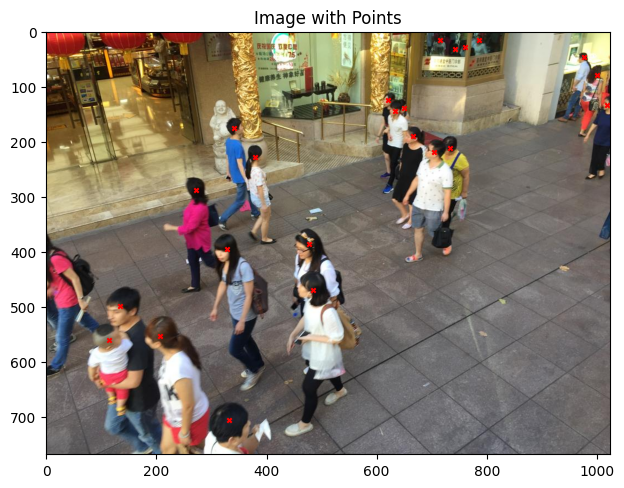

In [4]:
# Dataset Path
base_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/train_data"

labels_dir = os.path.join(base_dir, "ground_truth")
images_dir = os.path.join(base_dir, "images")
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.mat')]
if not label_files:
    raise FileNotFoundError(f"No .mat files found in {labels_dir}")

random_label_file = random.choice(label_files)
print("Random label file selected:", random_label_file)

base_name = os.path.splitext(random_label_file)[0]
img_name = base_name[3:]
img_file = f"{img_name}.jpg"

img_path = os.path.join(images_dir, img_file)
label_path = os.path.join(labels_dir, random_label_file)

# Load the image
img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise FileNotFoundError(f"Could not load image: {img_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Load the .mat file and parse the point locations
mat_data = sio.loadmat(label_path)
points_array = mat_data["image_info"][0,0]["location"][0,0]

points = []
for i in range(points_array.shape[0]):
    x_coord = points_array[i, 0]
    y_coord = points_array[i, 1]
    points.append((x_coord, y_coord))

print(f"Total points = {len(points)}")

# Visualize
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
if points:
    px, py = zip(*points)
    plt.scatter(px, py, s=10, c='red', marker='x')
    plt.title('Image with Points')

Mean crowd count: 123.20
Median crowd count: 99.5
Min crowd count: 12
Max crowd count: 578


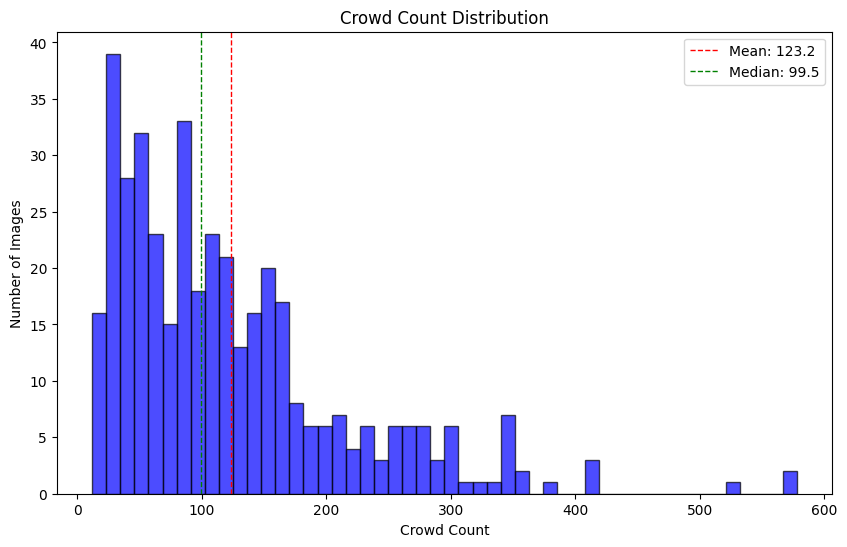

In [8]:
# Dataset Path
base_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/train_data"
labels_dir = os.path.join(base_dir, "ground_truth")

# Get list of .mat label files
label_files = [f for f in os.listdir(labels_dir) if f.endswith('.mat')]
if not label_files:
    raise FileNotFoundError(f"No .mat files found in {labels_dir}")

crowd_counts = []

# Loop over each label file and count the points
for label_file in label_files:
    label_path = os.path.join(labels_dir, label_file)
    mat_data = sio.loadmat(label_path)
    points_array = mat_data["image_info"][0, 0]["location"][0, 0]
    num_points = points_array.shape[0]
    crowd_counts.append(num_points)

crowd_counts = np.array(crowd_counts)

# Compute descriptive statistics
mean_count = np.mean(crowd_counts)
median_count = np.median(crowd_counts)
min_count = np.min(crowd_counts)
max_count = np.max(crowd_counts)

print(f"Mean crowd count: {mean_count:.2f}")
print(f"Median crowd count: {median_count}")
print(f"Min crowd count: {min_count}")
print(f"Max crowd count: {max_count}")

# Plot the distribution of crowd counts
plt.figure(figsize=(10, 6))
num_bins = 50
plt.hist(crowd_counts, bins=num_bins, color='blue', alpha=0.7, edgecolor='black')
plt.title("Crowd Count Distribution")
plt.xlabel("Crowd Count")
plt.ylabel("Number of Images")
plt.axvline(mean_count, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_count:.1f}')
plt.axvline(median_count, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_count}')
plt.legend()
plt.show()

# Preprocessing

In [ ]:
def generate_gaussian_kernel(k_size=15, sigma=4):
    """
    Creates a 2D Gaussian kernel of size (k_size x k_size) with integral = 1.
    """
    ax = np.arange(-k_size // 2 + 1., k_size // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel /= kernel.sum()
    return kernel


def get_density_map_gaussian(img, points, k_size=15, sigma=4):
    """
    Generate a density map using a Gaussian filter for each point.
    Places a 1.0 at each (x, y), then smooths with a Gaussian.
    """
    H, W = img.shape[:2]
    density = np.zeros((H, W), dtype=np.float32)

    for (x, y) in points:
        x_i, y_i = int(round(x)), int(round(y))
        if 0 <= x_i < W and 0 <= y_i < H:
            density[y_i, x_i] += 1.0

    density = gaussian_filter(density, sigma=sigma,
                              truncate=(k_size / (2 * sigma)))
    return density


def horizontal_flip(img, coords, flip_prob=0.5):
    """
    Flip image horizontally with probability flip_prob, adjusting x-coordinates.
    """
    if random.random() < flip_prob:
        flipped_img = cv2.flip(img, 1)
        H, W = img.shape[:2]
        flipped_coords = [(W - 1 - x, y) for (x, y) in coords]
        return flipped_img, flipped_coords
    return img, coords


def random_crop(img, coords, crop_prob=0.5, scale_range=(0.8, 1.0)):
    """
    With probability crop_prob, randomly crop the image to a random scale in scale_range.
    """
    if random.random() > crop_prob:
        return img, coords

    H, W = img.shape[:2]
    scale = random.uniform(*scale_range)
    if scale >= 1.0:
        return img, coords

    new_h = int(H * scale)
    new_w = int(W * scale)
    top = random.randint(0, H - new_h)
    left = random.randint(0, W - new_w)

    cropped_img = img[top : top + new_h, left : left + new_w]

    cropped_coords = []
    for (x, y) in coords:
        if left <= x < left + new_w and top <= y < top + new_h:
            cropped_coords.append((x - left, y - top))

    return cropped_img, cropped_coords


def augment_sample(img, coords, flip_prob=0.5, crop_prob=0.5, scale_range=(0.8, 1.0)):
    """
    Apply horizontal flip and random crop (no rotation).
    """
    # Horizontal flip
    img, coords = horizontal_flip(img, coords, flip_prob)
    # Random crop
    img, coords = random_crop(img, coords, crop_prob, scale_range)
    return img, coords


def preprocess_shanghaitech_dataset(
    images_dir,
    labels_dir,
    out_dir,
    target_size=None,
    k_size=15,
    sigma=4,
    augment=False,
    flip_prob=0.5,
    crop_prob=0.5,
    scale_range=(0.8, 1.0)
):
    """
    Preprocess the ShanghaiTech Part_B dataset:
      - Reads each .mat file in `labels_dir`,
      - Matches the corresponding image in `images_dir`,
      - Extracts (x,y) coords from .mat,
      - Optionally resizes images (and scales coords),
      - Generates a density map,
      - Optionally applies data augmentations,
      - Saves results.
    """
    os.makedirs(out_dir, exist_ok=True)
    img_out = os.path.join(out_dir, "images")
    den_out = os.path.join(out_dir, "density")
    coords_out = os.path.join(out_dir, "coords")
    for d in [img_out, den_out, coords_out]:
        os.makedirs(d, exist_ok=True)

    # Gather all .mat files
    mat_files = [f for f in os.listdir(labels_dir) if f.lower().endswith('.mat')]
    print(f"Found {len(mat_files)} ground-truth .mat files in {labels_dir}. Augment={augment}")

    for idx, mat_file in enumerate(mat_files):
        base_mat_name = os.path.splitext(mat_file)[0]
        img_name = base_mat_name[3:]
        img_file = img_name + ".jpg"

        img_path = os.path.join(images_dir, img_file)
        mat_path = os.path.join(labels_dir, mat_file)

        # Load the image
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Warning: Could not load image {img_path}. Skipping.")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Load the .mat data and parse (x,y) coords
        mat_data = sio.loadmat(mat_path)
        points_array = mat_data["image_info"][0,0]["location"][0,0]
        coords = [(float(x), float(y)) for x, y in points_array]

        # Resize image & scale coords
        if target_size is not None:
            new_width, new_height = target_size
            old_height, old_width = img_rgb.shape[:2]

            img_rgb_resized = cv2.resize(img_rgb, (new_width, new_height),
                                         interpolation=cv2.INTER_LINEAR)

            scale_x = new_width / old_width
            scale_y = new_height / old_height
            scaled_coords = [(x * scale_x, y * scale_y) for (x, y) in coords]
        else:
            img_rgb_resized = img_rgb
            scaled_coords = coords

        # Generate density map
        density_map = get_density_map_gaussian(img_rgb_resized, scaled_coords, k_size, sigma)

        # Save original outputs
        base_name = img_name
        out_img_bgr = cv2.cvtColor(img_rgb_resized, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(img_out, base_name + ".jpg"), out_img_bgr)
        np.savetxt(os.path.join(den_out, base_name + ".csv"), density_map, delimiter=",")
        if scaled_coords:
            np.savetxt(os.path.join(coords_out, base_name + ".txt"), scaled_coords, fmt="%.2f")
        else:
            open(os.path.join(coords_out, base_name + ".txt"), "w").close()

        # Augment
        if augment:
            aug_img, aug_coords = augment_sample(
                img_rgb_resized,
                scaled_coords,
                flip_prob=flip_prob,
                crop_prob=crop_prob,
                scale_range=scale_range
            )
            aug_den = get_density_map_gaussian(aug_img, aug_coords, k_size, sigma)
            aug_base_name = base_name + "_aug"

            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(os.path.join(img_out, aug_base_name + ".jpg"), aug_img_bgr)
            np.savetxt(os.path.join(den_out, aug_base_name + ".csv"), aug_den, delimiter=",")
            if aug_coords:
                np.savetxt(os.path.join(coords_out, aug_base_name + ".txt"), aug_coords, fmt="%.2f")
            else:
                open(os.path.join(coords_out, aug_base_name + ".txt"), "w").close()

    print("ShanghaiTech dataset preprocessing completed.")

In [ ]:
# Preprocessing Training dataset with augmentation.
images_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/train_data/images"
labels_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/train_data/ground_truth"
out_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/processed_train"

preprocess_shanghaitech_dataset(
    images_dir=images_dir,
    labels_dir=labels_dir,
    out_dir=out_dir,
    target_size=(640, 480) ,
    k_size=15,
    sigma=4,
    augment=True,
    flip_prob=0.5,
    crop_prob=0.5,
    scale_range=(0.8, 1.0)
)

Found 400 ground-truth .mat files in /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/train_data/ground_truth. Augment=True
ShanghaiTech dataset preprocessing completed.


In [ ]:
# Preprocessing Testing dataset without augmentation.
images_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/images"
labels_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/ground_truth"
out_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/processed_test"

preprocess_shanghaitech_dataset(
    images_dir=images_dir,
    labels_dir=labels_dir,
    out_dir=out_dir,
    target_size=(640, 480) ,
    k_size=15,
    sigma=4,
    augment=False,
    flip_prob=0.5,
    crop_prob=0.5,
    scale_range=(0.8, 1.0)
)

Found 316 ground-truth .mat files in /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/ground_truth. Augment=False
ShanghaiTech dataset preprocessing completed.


# Visualizing Preprocessed Data

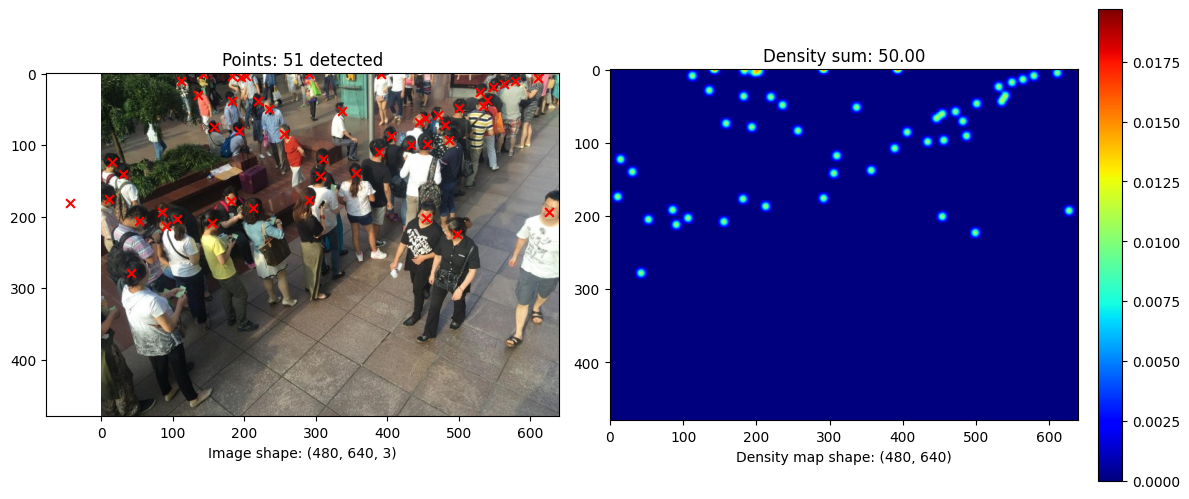

In [ ]:
# Dataset Path
preprocessed_dir = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/processed_test"

images_path = os.path.join(preprocessed_dir, "images")
density_path = os.path.join(preprocessed_dir, "density")
coords_path = os.path.join(preprocessed_dir, "coords")


img_files = [f for f in os.listdir(images_path) if f.lower().endswith('.jpg')]

index = random.randint(0, len(img_files) - 1)

img_file = img_files[index]
base_name = os.path.splitext(img_file)[0]
full_img_path = os.path.join(images_path, base_name + ".jpg")
full_dm_path = os.path.join(density_path, base_name + ".csv")
full_coords_path = os.path.join(coords_path, base_name + ".txt")

# Load the image
img_bgr = cv2.imread(full_img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

dm_np = np.loadtxt(full_dm_path, delimiter=",")
dm_sum = dm_np.sum()

coords_list = []
if os.path.exists(full_coords_path):
    try:
        raw_coords = np.loadtxt(full_coords_path)
        if raw_coords.size != 0:
            if raw_coords.ndim == 1:
                raw_coords = raw_coords.reshape(1, -1)
            coords_list = [tuple(pt[:2]) for pt in raw_coords]
    except Exception as e:
        print(f"Warning: Could not load coordinates from {full_coords_path}: {e}")

plt.figure(figsize=(12, 6))

# Left subplot: Display image with coordinate markers
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img_rgb)
ax1.set_title(f"Points: {len(coords_list)} detected")
ax1.set_xlabel(f"Image shape: {img_rgb.shape}")
if coords_list:
    xs, ys = zip(*coords_list)
    ax1.scatter(xs, ys, s=40, c="red", marker="x")
else:
    print("No coordinates to plot for this sample.")

# Right subplot: Display density map
ax2 = plt.subplot(1, 2, 2)
im = ax2.imshow(dm_np, cmap="jet")
ax2.set_title(f"Density sum: {dm_sum:.2f}")
ax2.set_xlabel(f"Density map shape: {dm_np.shape}")
plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# Model

Dataset Class

In [ ]:
class CrowdCountingDataset(Dataset):
    def __init__(self, preprocessed_dir, target_size=None, transform=None):
        """
        preprocessed_dir: folder containing subfolders:
          images/   -> .jpg files
          density/  -> .csv files
        target_size: tuple (width, height) to resize images and density maps.
        transform: additional transforms (if any) to apply to the image.
        """
        self.preprocessed_dir = preprocessed_dir
        self.transform = transform
        self.target_size = target_size

        self.images_dir  = os.path.join(preprocessed_dir, "images")
        self.density_dir = os.path.join(preprocessed_dir, "density")
        self.img_files = sorted([f for f in os.listdir(self.images_dir) if f.lower().endswith(".jpg")])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        base_name = os.path.splitext(img_file)[0]

        img_path = os.path.join(self.images_dir, img_file)
        dm_path = os.path.join(self.density_dir, base_name + ".csv")

        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            raise FileNotFoundError(f"Could not load image: {img_path}")
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        dm_np = np.loadtxt(dm_path, delimiter=",").astype(np.float32)

        if self.target_size is not None:
            img_rgb = cv2.resize(img_rgb, self.target_size, interpolation=cv2.INTER_LINEAR)
            dm_np = cv2.resize(dm_np, self.target_size, interpolation=cv2.INTER_LINEAR)

        img_rgb = img_rgb.astype(np.float32) / 255.0
        img_tensor = torch.from_numpy(img_rgb.transpose(2, 0, 1))
        dm_tensor = torch.from_numpy(dm_np).unsqueeze(0)

        gt_count = float(dm_np.sum())
        return img_tensor, dm_tensor, gt_count


def custom_collate(batch):
    """
    Pads images and density maps to the maximum height and width in the batch.
    """
    imgs, dms, counts = zip(*batch)
    max_h = max(img.shape[1] for img in imgs)
    max_w = max(img.shape[2] for img in imgs)

    padded_imgs = []
    padded_dms = []
    for img, dm in zip(imgs, dms):
        _, h, w = img.shape
        pad_h = max_h - h
        pad_w = max_w - w
        padded_img = F.pad(img, (0, pad_w, 0, pad_h), mode='constant', value=0)
        padded_imgs.append(padded_img)

        _, h_dm, w_dm = dm.shape
        pad_h_dm = max_h - h_dm
        pad_w_dm = max_w - w_dm
        padded_dm = F.pad(dm, (0, pad_w_dm, 0, pad_h_dm), mode='constant', value=0)
        padded_dms.append(padded_dm)

    imgs_batch = torch.stack(padded_imgs, dim=0)
    dms_batch = torch.stack(padded_dms, dim=0)
    counts_batch = torch.tensor(counts, dtype=torch.float32)
    return imgs_batch, dms_batch, counts_batch

CSRNet Model


In [ ]:
def make_backend(cfg, in_channels, dilation_rate=2):
    """
    Create the dilated backend layers.
    """
    layers = []
    for v in cfg:
        layers.append(nn.Conv2d(in_channels, v, kernel_size=3, padding=dilation_rate, dilation=dilation_rate))
        layers.append(nn.ReLU(inplace=True))
        in_channels = v
    return nn.Sequential(*layers)


class CSRNet(nn.Module):
    """
    CSRNet Model Defenition.
    """
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        self.frontend = nn.Sequential(*list(models.vgg16(pretrained=True).features)[:23])
        self.backend_cfg = [512, 512, 512, 256, 128, 64]
        self.backend = make_backend(self.backend_cfg, in_channels=512, dilation_rate=2)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


class CombinedLoss(nn.Module):
    """
    Loss calculation for CSRNet.
    """
    def __init__(self, weight_dmap=0.8, weight_sum_gt=0.2):
        super(CombinedLoss, self).__init__()
        self.weight_dmap = weight_dmap
        self.weight_sum_gt = weight_sum_gt
        self.img_loss = nn.MSELoss()
        self.gt_loss_mae = nn.L1Loss()

    def forward(self, logits, batch_dmap, batch_gts):
        batch_gts = batch_gts.float().view(-1)
        img_loss = self.img_loss(logits, batch_dmap)
        pred_counts = logits.sum(dim=(2, 3)).view(-1)
        gt_loss_mae = self.gt_loss_mae(pred_counts, batch_gts)
        combined_loss = self.weight_dmap * img_loss + self.weight_sum_gt * gt_loss_mae
        return combined_loss, gt_loss_mae

# Hyperparameter Tunning


=== Starting experiment: LR=0.0001_BS=8_Gamma=0.5 ===



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 109MB/s]


[Epoch 1/5] LR=0.0001, Batch=8, Gamma=0.5 Train Loss: 748.0786, Val Loss: 32.0621 (Best=32.0621)
[Epoch 2/5] LR=0.0001, Batch=8, Gamma=0.5 Train Loss: 138.4616, Val Loss: 751.9608 (Best=32.0621)
[Epoch 3/5] LR=0.0001, Batch=8, Gamma=0.5 Train Loss: 133.5127, Val Loss: 22.1094 (Best=22.1094)
[Epoch 4/5] LR=0.0001, Batch=8, Gamma=0.5 Train Loss: 47.0782, Val Loss: 49.9541 (Best=22.1094)
[Epoch 5/5] LR=0.0001, Batch=8, Gamma=0.5 Train Loss: 24.7956, Val Loss: 10.4740 (Best=10.4740)

=== Starting experiment: LR=0.0001_BS=8_Gamma=0.1 ===

[Epoch 1/5] LR=0.0001, Batch=8, Gamma=0.1 Train Loss: 47.2956, Val Loss: 9.1900 (Best=9.1900)
[Epoch 2/5] LR=0.0001, Batch=8, Gamma=0.1 Train Loss: 8.7125, Val Loss: 14.3518 (Best=9.1900)
[Epoch 3/5] LR=0.0001, Batch=8, Gamma=0.1 Train Loss: 7.3896, Val Loss: 5.9650 (Best=5.9650)
[Epoch 4/5] LR=0.0001, Batch=8, Gamma=0.1 Train Loss: 7.3755, Val Loss: 8.1200 (Best=5.9650)
[Epoch 5/5] LR=0.0001, Batch=8, Gamma=0.1 Train Loss: 6.8929, Val Loss: 5.3711 (Best=5

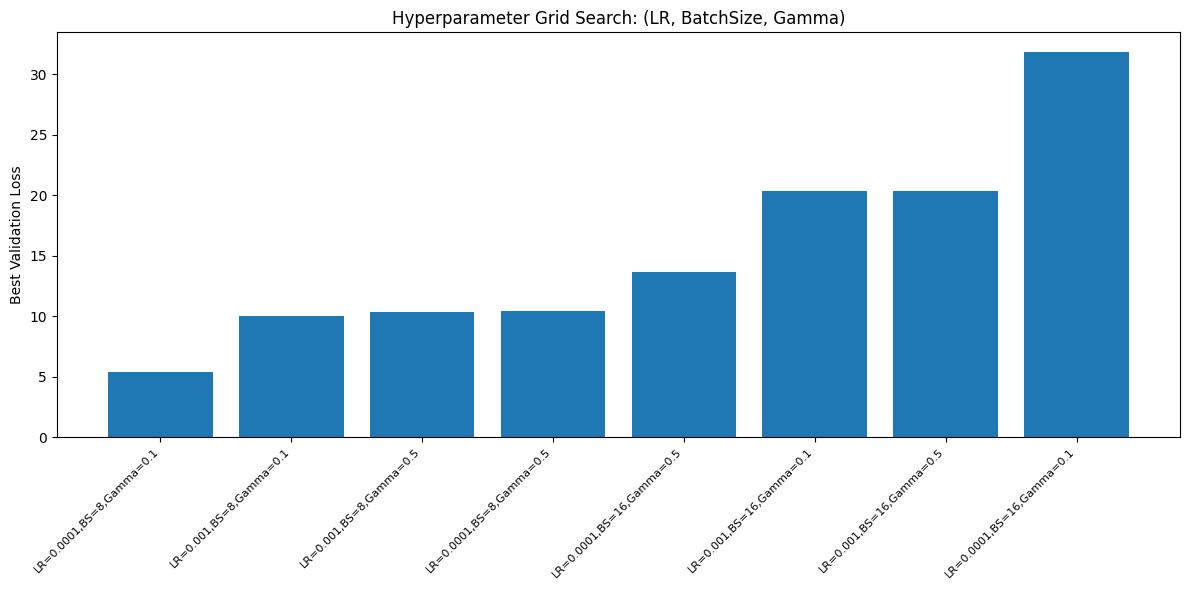

In [ ]:
CHECKPOINT_FILE = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/hyperparam_results_checkpoint.json"


def train_one_epoch(model, train_loader, criterion, optimizer, device='cuda'):
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    for images, density_maps, gts in train_loader:
        images = images.to(device)
        density_maps = density_maps.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = F.interpolate(outputs, size=density_maps.shape[2:], mode='bilinear')
        loss = criterion(outputs, density_maps)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)

    return epoch_loss


def validate(model, val_loader, criterion, device='cuda'):
    """
    Validate the model on the validation set.
    """
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, density_maps, gts in val_loader:
            images = images.to(device)
            density_maps = density_maps.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=density_maps.shape[2:], mode='bilinear')
            loss = criterion(outputs, density_maps)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    return val_loss


def save_checkpoint(results):
    """
    Save the results to a JSON file.
    """
    with open(CHECKPOINT_FILE, 'w') as f:
        json.dump(results, f)


def load_checkpoint():
    """
    Load the results from a JSON file.
    """
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'r') as f:
            return json.load(f)
    else:
        return {}


def run_experiment(lr, batch_size, gamma, train_dataset, val_dataset, num_epochs=5, device='cuda'):
    """
      Train a CSRNet model using:
        - learning rate = lr
        - batch size    = batch_size
        - gamma
      Returns best validation loss over 'num_epochs'.
      """

    weight_decay = 1e-5
    step_size    = 5

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = CSRNet().to(device)
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss   = validate(model, val_loader, criterion, device)
        scheduler.step()
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        print(f"[Epoch {epoch+1}/{num_epochs}] LR={lr}, Batch={batch_size}, Gamma={gamma} "
              f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} (Best={best_val_loss:.4f})")

    return best_val_loss


def hyperparam_search():
    """
    Hyperparameter tunning with different combinations.
    """
    train_all = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/processed_train"
    train_dataset = CrowdCountingDataset(train_all, target_size=(640, 480), transform=None)
    test_all = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/processed_test"
    test_dataset_all = CrowdCountingDataset(test_all, target_size=(640, 480), transform=None)
    val_subset_size = len(test_dataset_all) // 2
    val_dataset = Subset(test_dataset_all, list(range(val_subset_size)))

    learning_rates = [1e-4, 1e-3]
    batch_sizes    = [8, 16]
    gammas         = [0.5, 0.1]

    results = load_checkpoint()

    for lr, bs, gm in itertools.product(learning_rates, batch_sizes, gammas):
        key = f"LR={lr}_BS={bs}_Gamma={gm}"
        if key in results:
            print(f"Skipping {key} (already computed).")
            continue

        print(f"\n=== Starting experiment: {key} ===\n")
        final_val_loss = run_experiment(
            lr=lr,
            batch_size=bs,
            gamma=gm,
            train_dataset=train_dataset,
            val_dataset=val_dataset,
            num_epochs=5,
            device='cuda'
        )
        results[key] = {
            "lr": lr,
            "batch_size": bs,
            "gamma": gm,
            "val_loss": final_val_loss
        }

        save_checkpoint(results)

    plot_results(list(results.values()))


def plot_results(results):
    """
    Show a bar chart from the list of combos and val_loss.
    """

    results_sorted = sorted(results, key=lambda x: x["val_loss"])
    labels = [f"LR={r['lr']},BS={r['batch_size']},Gamma={r['gamma']}" for r in results_sorted]
    val_losses = [r["val_loss"] for r in results_sorted]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(results_sorted)), val_losses, tick_label=labels)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.ylabel("Best Validation Loss")
    plt.title("Hyperparameter Grid Search: (LR, BatchSize, Gamma)")
    plt.tight_layout()
    plt.show()


hyperparam_search()

# Training

In [ ]:
def train_CRSNET_model(
    model,
    train_dataset,
    val_dataset,
    batch_size=4,
    lr=1e-4,
    num_epochs=100,
    gamma=0.5,
    device='cuda',
    resume_path=None
):
    """
    Train the crowd counting model.
    - Uses a custom collate function for data loading.
    - Upsamples network outputs to match ground truth resolution.
    - Displays a progress bar.
    - Writes logs and prints debug information for the first few samples.
    - Can resume training from a checkpoint if resume_path is provided.
    """
    from torch.utils.data import DataLoader
    import torch.nn.functional as F

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        collate_fn=custom_collate
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        collate_fn=custom_collate
    )

    criterion = CombinedLoss(0.8, 0.2)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=5, gamma=gamma)

    model = model.to(device)
    best_val_loss = float('inf')
    start_epoch = 0

    if resume_path is not None and os.path.isfile(resume_path):
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        start_epoch = checkpoint["epoch"]
        best_val_loss = checkpoint.get("best_val_loss", float('inf'))
        print(f"Resumed training from epoch {start_epoch}, best_val_loss: {best_val_loss:.4f}")

    log_file_path = f"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_train_log.txt"
    log_mode = "a" if resume_path is not None else "w"

    with open(log_file_path, log_mode) as log_file:
        for epoch in range(start_epoch, num_epochs):
            print(f"Epoch {epoch+1}")
            model.train()
            running_loss = 0.0
            running_mae = 0.0
            total_gt_sum = 0.0
            total_pred_sum = 0.0
            count = 0

            start_time = time.time()
            debug_print_count = 0

            for imgs, dmaps, gts in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                imgs = imgs.to(device)
                dmaps = dmaps.to(device)
                gts_tensor = torch.as_tensor(gts, dtype=torch.float32, device=device).view(-1)

                optimizer.zero_grad()
                outputs = model(imgs)

                outputs_up = F.interpolate(outputs, size=dmaps.shape[-2:], mode='bilinear', align_corners=False)
                loss, mae_loss = criterion(outputs_up, dmaps, gts_tensor)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()

                running_loss += loss.item() * imgs.size(0)
                pred_counts = outputs_up.sum(dim=(2, 3)).view(-1)
                batch_mae = torch.abs(pred_counts - gts_tensor).sum().item()
                running_mae += batch_mae
                total_gt_sum += gts_tensor.sum().item()
                total_pred_sum += pred_counts.sum().item()
                count += imgs.size(0)

                for i in range(imgs.size(0)):
                    if debug_print_count < 5:
                        sample_gt = gts_tensor[i].item()
                        sample_pred = pred_counts[i].item()
                        print(f"  Debug Sample {debug_print_count+1}: GT count: {sample_gt:.2f}, Predicted Sum: {sample_pred:.2f}")
                        debug_print_count += 1

            if (epoch+1) % 5 == 0:
                save_path = f"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_{epoch+1}.pth"
                torch.save({
                    "epoch": epoch+1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": best_val_loss
                }, save_path)
                print(f"Model saved to {save_path} at epoch {epoch+1}")

            train_loss = running_loss / count
            train_mae = running_mae / count
            avg_gt = total_gt_sum / count
            avg_pred = total_pred_sum / count

            model.eval()
            val_running_loss = 0.0
            val_running_mae = 0.0
            val_total_gt = 0.0
            val_total_pred = 0.0
            val_count = 0
            with torch.no_grad():
                for imgs, dmaps, gts in val_loader:
                    imgs = imgs.to(device)
                    dmaps = dmaps.to(device)
                    gts_tensor = torch.as_tensor(gts, dtype=torch.float32, device=device).view(-1)

                    outputs = model(imgs)
                    outputs_up = F.interpolate(outputs, size=dmaps.shape[-2:], mode='bilinear', align_corners=False)
                    loss, mae_loss = criterion(outputs_up, dmaps, gts_tensor)

                    val_running_loss += loss.item() * imgs.size(0)
                    pred_counts = outputs_up.sum(dim=(2, 3)).view(-1)
                    batch_mae = torch.abs(pred_counts - gts_tensor).sum().item()
                    val_running_mae += batch_mae
                    val_total_gt += gts_tensor.sum().item()
                    val_total_pred += pred_counts.sum().item()
                    val_count += imgs.size(0)

            val_loss = val_running_loss / val_count
            val_mae = val_running_mae / val_count
            val_avg_gt = val_total_gt / val_count
            val_avg_pred = val_total_pred / val_count
            elapsed = time.time() - start_time

            scheduler.step()

            log_str = (f"Epoch [{epoch+1}/{num_epochs}], "
                       f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, "
                       f"Avg GT: {avg_gt:.2f}, Avg Pred: {avg_pred:.2f} || "
                       f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, "
                       f"Avg GT: {val_avg_gt:.2f}, Avg Pred: {val_avg_pred:.2f}, "
                       f"Time: {elapsed:.2f}s\n")
            print(log_str, end="")
            log_file.write(log_str)
            log_file.flush()

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save({
                    "epoch": epoch+1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_val_loss": best_val_loss
                }, "best_model.pth")
                print("Saved best model with Val Loss:", best_val_loss)

        torch.save(model.state_dict(), f"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model.pth")
        print("Training complete. Best val loss:", best_val_loss)

    return model

In [ ]:
train_all = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/processed_train"
train_dataset_all = CrowdCountingDataset(train_all, target_size=(640, 480), transform=None)
print("Train Dataset:", len(train_dataset_all))

test_all = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/processed_test"
test_dataset_all = CrowdCountingDataset(test_all, target_size=(640, 480), transform=None)

val_subset_size = len(test_dataset_all) // 2
val_dataset = Subset(test_dataset_all, list(range(val_subset_size)))
print("Val Dataset:", len(val_dataset))

Train Dataset: 800
Val Dataset: 158


In [ ]:
model = CSRNet()

model = train_CRSNET_model(
    model,
    train_dataset_all,
    val_dataset,
    batch_size=8,
    lr=1e-4,
    num_epochs=100,
    device='cuda',
    gamma=0.1,
    resume_path="/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_65.pth"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 79.0MB/s]


Resumed training from epoch 65, best_val_loss: 5.4348
Epoch 66


Epoch 66:   0%|          | 1/200 [00:07<24:45,  7.46s/it]

  Debug Sample 1: GT count: 53.00, Predicted Sum: 138.44
  Debug Sample 2: GT count: 195.41, Predicted Sum: 194.69
  Debug Sample 3: GT count: 32.00, Predicted Sum: 95.93
  Debug Sample 4: GT count: 24.07, Predicted Sum: 78.61


Epoch 66:   1%|          | 2/200 [00:14<23:20,  7.07s/it]

  Debug Sample 5: GT count: 161.00, Predicted Sum: 139.01


Epoch 66: 100%|██████████| 200/200 [11:28<00:00,  3.44s/it]


Epoch [66/100], Train Loss: 12.2681, Train MAE: 61.3406, Avg GT: 119.58, Avg Pred: 113.66 || Val Loss: 29.2185, Val MAE: 146.0924, Avg GT: 130.42, Avg Pred: -15.67, Time: 916.98s
Epoch 67


Epoch 67:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 47.00, Predicted Sum: -82.36
  Debug Sample 2: GT count: 19.06, Predicted Sum: -73.06
  Debug Sample 3: GT count: 51.00, Predicted Sum: -76.81
  Debug Sample 4: GT count: 288.13, Predicted Sum: 88.22


Epoch 67:   1%|          | 2/200 [00:01<03:03,  1.08it/s]

  Debug Sample 5: GT count: 343.00, Predicted Sum: 145.68


Epoch 67: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [67/100], Train Loss: 11.5649, Train MAE: 57.8247, Avg GT: 119.58, Avg Pred: 116.24 || Val Loss: 8.3946, Val MAE: 41.9729, Avg GT: 130.42, Avg Pred: 165.02, Time: 222.74s
Epoch 68


Epoch 68:   0%|          | 1/200 [00:00<03:06,  1.06it/s]

  Debug Sample 1: GT count: 120.00, Predicted Sum: 110.70
  Debug Sample 2: GT count: 167.00, Predicted Sum: 202.96
  Debug Sample 3: GT count: 302.00, Predicted Sum: 324.12
  Debug Sample 4: GT count: 28.00, Predicted Sum: 33.33


Epoch 68:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 22.00, Predicted Sum: 31.06


Epoch 68: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [68/100], Train Loss: 9.2349, Train MAE: 46.1744, Avg GT: 119.58, Avg Pred: 114.56 || Val Loss: 14.8929, Val MAE: 74.4647, Avg GT: 130.42, Avg Pred: 202.69, Time: 221.36s
Epoch 69


Epoch 69:   0%|          | 1/200 [00:01<03:48,  1.15s/it]

  Debug Sample 1: GT count: 36.00, Predicted Sum: 102.67
  Debug Sample 2: GT count: 28.00, Predicted Sum: 87.47
  Debug Sample 3: GT count: 150.00, Predicted Sum: 166.71
  Debug Sample 4: GT count: 117.00, Predicted Sum: 200.35


Epoch 69:   1%|          | 2/200 [00:02<03:33,  1.08s/it]

  Debug Sample 5: GT count: 86.00, Predicted Sum: 119.33


Epoch 69: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [69/100], Train Loss: 7.2467, Train MAE: 36.2337, Avg GT: 119.58, Avg Pred: 119.23 || Val Loss: 5.4961, Val MAE: 27.4803, Avg GT: 130.42, Avg Pred: 114.18, Time: 221.01s
Epoch 70


Epoch 70:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 301.32, Predicted Sum: 268.02
  Debug Sample 2: GT count: 96.00, Predicted Sum: 77.75
  Debug Sample 3: GT count: 260.00, Predicted Sum: 234.24
  Debug Sample 4: GT count: 101.00, Predicted Sum: 113.50


Epoch 70:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 169.00, Predicted Sum: 204.96


Epoch 70: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_70.pth at epoch 70
Epoch [70/100], Train Loss: 6.9506, Train MAE: 34.7527, Avg GT: 119.58, Avg Pred: 123.55 || Val Loss: 4.4479, Val MAE: 22.2394, Avg GT: 130.42, Avg Pred: 131.25, Time: 221.91s
Saved best model with Val Loss: 4.447880992406531
Epoch 71


Epoch 71:   0%|          | 1/200 [00:01<03:52,  1.17s/it]

  Debug Sample 1: GT count: 152.00, Predicted Sum: 217.35
  Debug Sample 2: GT count: 274.00, Predicted Sum: 209.35
  Debug Sample 3: GT count: 65.00, Predicted Sum: 81.02
  Debug Sample 4: GT count: 88.73, Predicted Sum: 107.52


Epoch 71:   1%|          | 2/200 [00:02<03:44,  1.13s/it]

  Debug Sample 5: GT count: 36.00, Predicted Sum: 16.95


Epoch 71: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [71/100], Train Loss: 7.7287, Train MAE: 38.6434, Avg GT: 119.58, Avg Pred: 118.82 || Val Loss: 6.1991, Val MAE: 30.9955, Avg GT: 130.42, Avg Pred: 150.86, Time: 221.81s
Epoch 72


Epoch 72:   0%|          | 1/200 [00:00<02:58,  1.11it/s]

  Debug Sample 1: GT count: 123.09, Predicted Sum: 173.19
  Debug Sample 2: GT count: 169.00, Predicted Sum: 193.94
  Debug Sample 3: GT count: 53.00, Predicted Sum: 107.08
  Debug Sample 4: GT count: 103.00, Predicted Sum: 155.43


Epoch 72:   1%|          | 2/200 [00:01<02:57,  1.11it/s]

  Debug Sample 5: GT count: 96.00, Predicted Sum: 104.25


Epoch 72: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch [72/100], Train Loss: 6.9732, Train MAE: 34.8660, Avg GT: 119.58, Avg Pred: 119.38 || Val Loss: 4.2429, Val MAE: 21.2143, Avg GT: 130.42, Avg Pred: 129.54, Time: 218.35s
Saved best model with Val Loss: 4.242872515056707
Epoch 73


Epoch 73:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 157.00, Predicted Sum: 134.92
  Debug Sample 2: GT count: 32.00, Predicted Sum: 22.11
  Debug Sample 3: GT count: 31.00, Predicted Sum: 59.27
  Debug Sample 4: GT count: 55.00, Predicted Sum: 59.03


Epoch 73:   1%|          | 2/200 [00:01<02:58,  1.11it/s]

  Debug Sample 5: GT count: 87.03, Predicted Sum: 87.67


Epoch 73: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [73/100], Train Loss: 7.2946, Train MAE: 36.4732, Avg GT: 119.58, Avg Pred: 117.72 || Val Loss: 11.9422, Val MAE: 59.7110, Avg GT: 130.42, Avg Pred: 181.77, Time: 216.61s
Epoch 74


Epoch 74:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 87.00, Predicted Sum: 141.70
  Debug Sample 2: GT count: 55.32, Predicted Sum: 166.72
  Debug Sample 3: GT count: 50.00, Predicted Sum: 115.08
  Debug Sample 4: GT count: 274.00, Predicted Sum: 269.52


Epoch 74:   1%|          | 2/200 [00:02<03:31,  1.07s/it]

  Debug Sample 5: GT count: 209.00, Predicted Sum: 209.52


Epoch 74: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [74/100], Train Loss: 6.6152, Train MAE: 33.0758, Avg GT: 119.58, Avg Pred: 117.39 || Val Loss: 8.2688, Val MAE: 41.3438, Avg GT: 130.42, Avg Pred: 112.51, Time: 218.06s
Epoch 75


Epoch 75:   0%|          | 1/200 [00:01<03:35,  1.08s/it]

  Debug Sample 1: GT count: 189.01, Predicted Sum: 125.59
  Debug Sample 2: GT count: 34.85, Predicted Sum: -7.05
  Debug Sample 3: GT count: 68.00, Predicted Sum: 41.06
  Debug Sample 4: GT count: 174.00, Predicted Sum: 114.92


Epoch 75:   1%|          | 2/200 [00:01<03:14,  1.02it/s]

  Debug Sample 5: GT count: 146.00, Predicted Sum: 166.77


Epoch 75: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_75.pth at epoch 75
Epoch [75/100], Train Loss: 5.8735, Train MAE: 29.3675, Avg GT: 119.58, Avg Pred: 119.07 || Val Loss: 5.6527, Val MAE: 28.2635, Avg GT: 130.42, Avg Pred: 107.12, Time: 221.81s
Epoch 76


Epoch 76:   0%|          | 1/200 [00:00<03:13,  1.03it/s]

  Debug Sample 1: GT count: 85.00, Predicted Sum: 93.34
  Debug Sample 2: GT count: 62.00, Predicted Sum: 54.97
  Debug Sample 3: GT count: 47.00, Predicted Sum: 25.48
  Debug Sample 4: GT count: 304.00, Predicted Sum: 244.22


Epoch 76:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 59.00, Predicted Sum: 34.00


Epoch 76: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [76/100], Train Loss: 5.8215, Train MAE: 29.1076, Avg GT: 119.58, Avg Pred: 117.46 || Val Loss: 4.7662, Val MAE: 23.8311, Avg GT: 130.42, Avg Pred: 124.40, Time: 217.06s
Epoch 77


Epoch 77:   0%|          | 1/200 [00:00<03:14,  1.02it/s]

  Debug Sample 1: GT count: 122.00, Predicted Sum: 138.12
  Debug Sample 2: GT count: 55.00, Predicted Sum: 61.55
  Debug Sample 3: GT count: 41.00, Predicted Sum: 44.27
  Debug Sample 4: GT count: 88.73, Predicted Sum: 78.89


Epoch 77:   1%|          | 2/200 [00:02<03:28,  1.05s/it]

  Debug Sample 5: GT count: 35.00, Predicted Sum: 17.81


Epoch 77: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch [77/100], Train Loss: 7.2165, Train MAE: 36.0824, Avg GT: 119.58, Avg Pred: 113.99 || Val Loss: 5.1757, Val MAE: 25.8786, Avg GT: 130.42, Avg Pred: 131.23, Time: 218.94s
Epoch 78


Epoch 78:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 166.00, Predicted Sum: 144.15
  Debug Sample 2: GT count: 227.00, Predicted Sum: 221.94
  Debug Sample 3: GT count: 93.50, Predicted Sum: 100.28
  Debug Sample 4: GT count: 344.00, Predicted Sum: 323.64


Epoch 78:   1%|          | 2/200 [00:01<03:03,  1.08it/s]

  Debug Sample 5: GT count: 20.00, Predicted Sum: 51.44


Epoch 78: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [78/100], Train Loss: 6.4697, Train MAE: 32.3487, Avg GT: 119.58, Avg Pred: 117.77 || Val Loss: 8.7308, Val MAE: 43.6540, Avg GT: 130.42, Avg Pred: 119.35, Time: 218.01s
Epoch 79


Epoch 79:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 152.00, Predicted Sum: 188.83
  Debug Sample 2: GT count: 300.00, Predicted Sum: 366.54
  Debug Sample 3: GT count: 36.00, Predicted Sum: -49.25
  Debug Sample 4: GT count: 109.00, Predicted Sum: 107.23


Epoch 79:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 30.00, Predicted Sum: -34.21


Epoch 79: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [79/100], Train Loss: 7.0635, Train MAE: 35.3173, Avg GT: 119.58, Avg Pred: 112.88 || Val Loss: 7.6753, Val MAE: 38.3765, Avg GT: 130.42, Avg Pred: 98.28, Time: 219.85s
Epoch 80


Epoch 80:   0%|          | 1/200 [00:01<03:40,  1.11s/it]

  Debug Sample 1: GT count: 94.00, Predicted Sum: 71.45
  Debug Sample 2: GT count: 33.00, Predicted Sum: 12.12
  Debug Sample 3: GT count: 161.66, Predicted Sum: 155.92
  Debug Sample 4: GT count: 90.00, Predicted Sum: 70.73


Epoch 80:   1%|          | 2/200 [00:02<03:47,  1.15s/it]

  Debug Sample 5: GT count: 85.00, Predicted Sum: 100.32


Epoch 80: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_80.pth at epoch 80
Epoch [80/100], Train Loss: 6.7009, Train MAE: 33.5047, Avg GT: 119.58, Avg Pred: 118.49 || Val Loss: 17.3854, Val MAE: 86.9270, Avg GT: 130.42, Avg Pred: 122.08, Time: 224.80s
Epoch 81


Epoch 81:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 110.00, Predicted Sum: 121.55
  Debug Sample 2: GT count: 46.00, Predicted Sum: -26.29
  Debug Sample 3: GT count: 54.48, Predicted Sum: -15.10
  Debug Sample 4: GT count: 31.00, Predicted Sum: -56.75


Epoch 81:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 88.94, Predicted Sum: -2.96


Epoch 81: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [81/100], Train Loss: 8.2630, Train MAE: 41.3148, Avg GT: 119.58, Avg Pred: 113.47 || Val Loss: 6.4968, Val MAE: 32.4841, Avg GT: 130.42, Avg Pred: 106.52, Time: 223.02s
Epoch 82


Epoch 82:   0%|          | 1/200 [00:00<03:13,  1.03it/s]

  Debug Sample 1: GT count: 37.00, Predicted Sum: 2.80
  Debug Sample 2: GT count: 274.00, Predicted Sum: 229.76
  Debug Sample 3: GT count: 50.00, Predicted Sum: 16.88
  Debug Sample 4: GT count: 344.00, Predicted Sum: 238.94


Epoch 82:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 90.00, Predicted Sum: 91.99


Epoch 82: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [82/100], Train Loss: 9.8313, Train MAE: 49.1567, Avg GT: 119.58, Avg Pred: 122.95 || Val Loss: 18.7323, Val MAE: 93.6615, Avg GT: 130.42, Avg Pred: 37.10, Time: 221.98s
Epoch 83


Epoch 83:   0%|          | 1/200 [00:01<03:47,  1.14s/it]

  Debug Sample 1: GT count: 27.00, Predicted Sum: -34.08
  Debug Sample 2: GT count: 257.00, Predicted Sum: 108.18
  Debug Sample 3: GT count: 43.00, Predicted Sum: -43.29
  Debug Sample 4: GT count: 56.00, Predicted Sum: -30.30


Epoch 83:   1%|          | 2/200 [00:02<03:48,  1.15s/it]

  Debug Sample 5: GT count: 229.00, Predicted Sum: 112.58


Epoch 83: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [83/100], Train Loss: 12.5367, Train MAE: 62.6834, Avg GT: 119.58, Avg Pred: 123.09 || Val Loss: 7.0411, Val MAE: 35.2053, Avg GT: 130.42, Avg Pred: 104.48, Time: 220.61s
Epoch 84


Epoch 84:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 29.00, Predicted Sum: 5.66
  Debug Sample 2: GT count: 155.00, Predicted Sum: 147.64
  Debug Sample 3: GT count: 166.00, Predicted Sum: 136.37
  Debug Sample 4: GT count: 111.00, Predicted Sum: 91.17


Epoch 84:   1%|          | 2/200 [00:01<03:11,  1.03it/s]

  Debug Sample 5: GT count: 188.00, Predicted Sum: 166.11


Epoch 84: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [84/100], Train Loss: 8.6465, Train MAE: 43.2326, Avg GT: 119.58, Avg Pred: 122.06 || Val Loss: 15.6528, Val MAE: 78.2641, Avg GT: 130.42, Avg Pred: 206.07, Time: 220.58s
Epoch 85


Epoch 85:   0%|          | 1/200 [00:00<03:03,  1.08it/s]

  Debug Sample 1: GT count: 134.00, Predicted Sum: 185.73
  Debug Sample 2: GT count: 86.00, Predicted Sum: 159.01
  Debug Sample 3: GT count: 35.76, Predicted Sum: 124.52
  Debug Sample 4: GT count: 50.00, Predicted Sum: 114.68


Epoch 85:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 440.36, Predicted Sum: 370.07


Epoch 85: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_85.pth at epoch 85
Epoch [85/100], Train Loss: 8.2029, Train MAE: 41.0144, Avg GT: 119.58, Avg Pred: 115.15 || Val Loss: 7.4697, Val MAE: 37.3486, Avg GT: 130.42, Avg Pred: 162.26, Time: 223.99s
Epoch 86


Epoch 86:   0%|          | 1/200 [00:01<03:44,  1.13s/it]

  Debug Sample 1: GT count: 379.00, Predicted Sum: 418.64
  Debug Sample 2: GT count: 36.00, Predicted Sum: 49.41
  Debug Sample 3: GT count: 46.75, Predicted Sum: 59.14
  Debug Sample 4: GT count: 295.81, Predicted Sum: 309.63


Epoch 86:   1%|          | 2/200 [00:02<03:21,  1.02s/it]

  Debug Sample 5: GT count: 267.00, Predicted Sum: 280.43


Epoch 86: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [86/100], Train Loss: 6.5279, Train MAE: 32.6393, Avg GT: 119.58, Avg Pred: 118.98 || Val Loss: 5.2192, Val MAE: 26.0958, Avg GT: 130.42, Avg Pred: 137.41, Time: 223.26s
Epoch 87


Epoch 87:   0%|          | 1/200 [00:01<03:21,  1.01s/it]

  Debug Sample 1: GT count: 83.00, Predicted Sum: 78.36
  Debug Sample 2: GT count: 34.48, Predicted Sum: 23.92
  Debug Sample 3: GT count: 136.00, Predicted Sum: 148.04
  Debug Sample 4: GT count: 86.00, Predicted Sum: 85.95


Epoch 87:   1%|          | 2/200 [00:01<03:13,  1.02it/s]

  Debug Sample 5: GT count: 274.00, Predicted Sum: 269.98


Epoch 87: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [87/100], Train Loss: 7.1539, Train MAE: 35.7694, Avg GT: 119.58, Avg Pred: 115.50 || Val Loss: 8.6603, Val MAE: 43.3015, Avg GT: 130.42, Avg Pred: 89.29, Time: 223.33s
Epoch 88


Epoch 88:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 82.17, Predicted Sum: 32.74
  Debug Sample 2: GT count: 109.00, Predicted Sum: 60.73
  Debug Sample 3: GT count: 301.32, Predicted Sum: 198.05
  Debug Sample 4: GT count: 152.00, Predicted Sum: 84.68


Epoch 88:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 120.00, Predicted Sum: 24.10


Epoch 88: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [88/100], Train Loss: 7.0101, Train MAE: 35.0503, Avg GT: 119.58, Avg Pred: 118.81 || Val Loss: 7.6241, Val MAE: 38.1204, Avg GT: 130.42, Avg Pred: 158.60, Time: 223.17s
Epoch 89


Epoch 89:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 15.00, Predicted Sum: 46.83
  Debug Sample 2: GT count: 23.00, Predicted Sum: 47.88
  Debug Sample 3: GT count: 220.00, Predicted Sum: 241.00
  Debug Sample 4: GT count: 414.00, Predicted Sum: 379.91


Epoch 89:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 69.00, Predicted Sum: 92.60


Epoch 89: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [89/100], Train Loss: 8.0899, Train MAE: 40.4492, Avg GT: 119.58, Avg Pred: 120.27 || Val Loss: 7.1471, Val MAE: 35.7356, Avg GT: 130.42, Avg Pred: 153.65, Time: 223.34s
Epoch 90


Epoch 90:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 158.05, Predicted Sum: 138.34
  Debug Sample 2: GT count: 54.00, Predicted Sum: 82.74
  Debug Sample 3: GT count: 253.91, Predicted Sum: 203.59
  Debug Sample 4: GT count: 201.00, Predicted Sum: 222.17


Epoch 90:   1%|          | 2/200 [00:01<03:02,  1.09it/s]

  Debug Sample 5: GT count: 99.00, Predicted Sum: 91.68


Epoch 90: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_90.pth at epoch 90
Epoch [90/100], Train Loss: 6.8918, Train MAE: 34.4592, Avg GT: 119.58, Avg Pred: 118.54 || Val Loss: 11.2368, Val MAE: 56.1841, Avg GT: 130.42, Avg Pred: 114.49, Time: 225.08s
Epoch 91


Epoch 91:   0%|          | 1/200 [00:01<03:47,  1.14s/it]

  Debug Sample 1: GT count: 45.00, Predicted Sum: 49.78
  Debug Sample 2: GT count: 117.68, Predicted Sum: 106.10
  Debug Sample 3: GT count: 187.50, Predicted Sum: 337.90
  Debug Sample 4: GT count: 85.00, Predicted Sum: 73.36


Epoch 91:   1%|          | 2/200 [00:02<03:49,  1.16s/it]

  Debug Sample 5: GT count: 29.00, Predicted Sum: -17.53


Epoch 91: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [91/100], Train Loss: 5.8876, Train MAE: 29.4382, Avg GT: 119.58, Avg Pred: 116.28 || Val Loss: 4.9514, Val MAE: 24.7569, Avg GT: 130.42, Avg Pred: 135.35, Time: 223.10s
Epoch 92


Epoch 92:   0%|          | 1/200 [00:00<03:03,  1.08it/s]

  Debug Sample 1: GT count: 30.00, Predicted Sum: 59.91
  Debug Sample 2: GT count: 174.00, Predicted Sum: 173.25
  Debug Sample 3: GT count: 159.00, Predicted Sum: 140.66
  Debug Sample 4: GT count: 49.00, Predicted Sum: 66.85


Epoch 92:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 61.00, Predicted Sum: 74.79


Epoch 92: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [92/100], Train Loss: 5.7478, Train MAE: 28.7388, Avg GT: 119.58, Avg Pred: 115.90 || Val Loss: 5.2420, Val MAE: 26.2098, Avg GT: 130.42, Avg Pred: 145.20, Time: 223.99s
Epoch 93


Epoch 93:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 43.17, Predicted Sum: 65.42
  Debug Sample 2: GT count: 96.00, Predicted Sum: 107.50
  Debug Sample 3: GT count: 129.14, Predicted Sum: 160.29
  Debug Sample 4: GT count: 60.00, Predicted Sum: 73.87


Epoch 93:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 66.35, Predicted Sum: 63.62


Epoch 93: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [93/100], Train Loss: 7.8085, Train MAE: 39.0424, Avg GT: 119.58, Avg Pred: 121.38 || Val Loss: 19.4671, Val MAE: 97.3357, Avg GT: 130.42, Avg Pred: 33.09, Time: 223.57s
Epoch 94


Epoch 94:   0%|          | 1/200 [00:00<03:14,  1.02it/s]

  Debug Sample 1: GT count: 247.00, Predicted Sum: 156.11
  Debug Sample 2: GT count: 59.00, Predicted Sum: -44.29
  Debug Sample 3: GT count: 130.00, Predicted Sum: 39.97
  Debug Sample 4: GT count: 142.00, Predicted Sum: 48.62


Epoch 94:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 191.00, Predicted Sum: 107.90


Epoch 94: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [94/100], Train Loss: 5.4388, Train MAE: 27.1938, Avg GT: 119.58, Avg Pred: 117.62 || Val Loss: 5.2746, Val MAE: 26.3729, Avg GT: 130.42, Avg Pred: 135.05, Time: 224.17s
Epoch 95


Epoch 95:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 51.00, Predicted Sum: 50.03
  Debug Sample 2: GT count: 344.00, Predicted Sum: 230.02
  Debug Sample 3: GT count: 175.00, Predicted Sum: 165.51
  Debug Sample 4: GT count: 55.00, Predicted Sum: 58.05


Epoch 95:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 35.00, Predicted Sum: 43.87


Epoch 95: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_95.pth at epoch 95
Epoch [95/100], Train Loss: 7.3753, Train MAE: 36.8767, Avg GT: 119.58, Avg Pred: 120.41 || Val Loss: 5.0249, Val MAE: 25.1244, Avg GT: 130.42, Avg Pred: 131.07, Time: 222.04s
Epoch 96


Epoch 96:   0%|          | 1/200 [00:01<03:47,  1.15s/it]

  Debug Sample 1: GT count: 41.00, Predicted Sum: 45.01
  Debug Sample 2: GT count: 195.00, Predicted Sum: 193.57
  Debug Sample 3: GT count: 53.00, Predicted Sum: 103.99
  Debug Sample 4: GT count: 268.00, Predicted Sum: 250.80


Epoch 96:   1%|          | 2/200 [00:02<03:45,  1.14s/it]

  Debug Sample 5: GT count: 129.00, Predicted Sum: 113.18


Epoch 96: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [96/100], Train Loss: 7.0239, Train MAE: 35.1195, Avg GT: 119.58, Avg Pred: 120.53 || Val Loss: 5.6341, Val MAE: 28.1703, Avg GT: 130.42, Avg Pred: 123.81, Time: 221.69s
Epoch 97


Epoch 97:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 90.00, Predicted Sum: 98.00
  Debug Sample 2: GT count: 116.00, Predicted Sum: 111.26
  Debug Sample 3: GT count: 36.98, Predicted Sum: 40.08
  Debug Sample 4: GT count: 117.00, Predicted Sum: 121.57


Epoch 97:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 14.00, Predicted Sum: 8.57


Epoch 97: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [97/100], Train Loss: 6.2144, Train MAE: 31.0721, Avg GT: 119.58, Avg Pred: 113.12 || Val Loss: 4.7870, Val MAE: 23.9348, Avg GT: 130.42, Avg Pred: 137.01, Time: 224.14s
Epoch 98


Epoch 98:   0%|          | 1/200 [00:00<03:15,  1.02it/s]

  Debug Sample 1: GT count: 58.00, Predicted Sum: 73.16
  Debug Sample 2: GT count: 136.00, Predicted Sum: 155.57
  Debug Sample 3: GT count: 344.00, Predicted Sum: 309.31
  Debug Sample 4: GT count: 107.00, Predicted Sum: 127.30


Epoch 98:   1%|          | 2/200 [00:01<03:15,  1.01it/s]

  Debug Sample 5: GT count: 22.13, Predicted Sum: 44.60


Epoch 98: 100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


Epoch [98/100], Train Loss: 7.4154, Train MAE: 37.0770, Avg GT: 119.58, Avg Pred: 117.02 || Val Loss: 5.0421, Val MAE: 25.2105, Avg GT: 130.42, Avg Pred: 143.15, Time: 226.45s
Epoch 99


Epoch 99:   0%|          | 1/200 [00:01<03:19,  1.00s/it]

  Debug Sample 1: GT count: 60.00, Predicted Sum: 60.00
  Debug Sample 2: GT count: 56.00, Predicted Sum: 58.81
  Debug Sample 3: GT count: 250.00, Predicted Sum: 292.91
  Debug Sample 4: GT count: 89.00, Predicted Sum: 99.21


Epoch 99:   1%|          | 2/200 [00:01<03:17,  1.00it/s]

  Debug Sample 5: GT count: 164.09, Predicted Sum: 146.57


Epoch 99: 100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


Epoch [99/100], Train Loss: 7.7179, Train MAE: 38.5895, Avg GT: 119.58, Avg Pred: 118.25 || Val Loss: 5.8501, Val MAE: 29.2503, Avg GT: 130.42, Avg Pred: 106.23, Time: 225.42s
Epoch 100


Epoch 100:   0%|          | 1/200 [00:01<03:41,  1.11s/it]

  Debug Sample 1: GT count: 23.00, Predicted Sum: 10.38
  Debug Sample 2: GT count: 134.00, Predicted Sum: 105.73
  Debug Sample 3: GT count: 50.00, Predicted Sum: 15.58
  Debug Sample 4: GT count: 64.40, Predicted Sum: 43.75


Epoch 100:   1%|          | 2/200 [00:02<03:48,  1.15s/it]

  Debug Sample 5: GT count: 153.16, Predicted Sum: 121.87


Epoch 100: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_100.pth at epoch 100
Epoch [100/100], Train Loss: 6.4506, Train MAE: 32.2531, Avg GT: 119.58, Avg Pred: 117.67 || Val Loss: 4.4541, Val MAE: 22.2703, Avg GT: 130.42, Avg Pred: 116.88, Time: 225.72s
Training complete. Best val loss: 4.242872515056707


In [ ]:
model = CSRNet()

model = train_CRSNET_model(
    model,
    train_dataset_all,
    val_dataset,
    batch_size=8,
    lr=1e-4,
    num_epochs=150,
    device='cuda',
    gamma=0.1,
    resume_path="/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_100.pth"
)

Resumed training from epoch 100, best_val_loss: 4.2429
Epoch 101


Epoch 101:   0%|          | 1/200 [00:01<03:21,  1.01s/it]

  Debug Sample 1: GT count: 80.00, Predicted Sum: 84.60
  Debug Sample 2: GT count: 54.00, Predicted Sum: 46.70
  Debug Sample 3: GT count: 120.00, Predicted Sum: 125.58
  Debug Sample 4: GT count: 41.00, Predicted Sum: 59.56


Epoch 101:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 226.70, Predicted Sum: 168.16


Epoch 101: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [101/150], Train Loss: 6.1143, Train MAE: 30.5712, Avg GT: 119.58, Avg Pred: 117.67 || Val Loss: 13.6637, Val MAE: 68.3187, Avg GT: 130.42, Avg Pred: 193.88, Time: 220.34s
Epoch 102


Epoch 102:   0%|          | 1/200 [00:00<03:12,  1.03it/s]

  Debug Sample 1: GT count: 152.00, Predicted Sum: 275.32
  Debug Sample 2: GT count: 49.00, Predicted Sum: 84.35
  Debug Sample 3: GT count: 96.00, Predicted Sum: 133.60
  Debug Sample 4: GT count: 25.00, Predicted Sum: 27.28


Epoch 102:   1%|          | 2/200 [00:01<03:07,  1.05it/s]

  Debug Sample 5: GT count: 77.00, Predicted Sum: 105.37


Epoch 102: 100%|██████████| 200/200 [03:22<00:00,  1.01s/it]


Epoch [102/150], Train Loss: 6.5979, Train MAE: 32.9896, Avg GT: 119.58, Avg Pred: 120.05 || Val Loss: 5.3995, Val MAE: 26.9972, Avg GT: 130.42, Avg Pred: 110.36, Time: 226.06s
Epoch 103


Epoch 103:   0%|          | 1/200 [00:00<03:14,  1.02it/s]

  Debug Sample 1: GT count: 167.00, Predicted Sum: 123.29
  Debug Sample 2: GT count: 47.00, Predicted Sum: 38.73
  Debug Sample 3: GT count: 25.00, Predicted Sum: 39.75
  Debug Sample 4: GT count: 107.00, Predicted Sum: 85.18


Epoch 103:   1%|          | 2/200 [00:01<03:14,  1.02it/s]

  Debug Sample 5: GT count: 161.00, Predicted Sum: 130.33


Epoch 103: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [103/150], Train Loss: 6.0071, Train MAE: 30.0354, Avg GT: 119.58, Avg Pred: 120.05 || Val Loss: 5.5938, Val MAE: 27.9691, Avg GT: 130.42, Avg Pred: 141.96, Time: 222.59s
Epoch 104


Epoch 104:   0%|          | 1/200 [00:00<03:10,  1.05it/s]

  Debug Sample 1: GT count: 267.00, Predicted Sum: 270.18
  Debug Sample 2: GT count: 26.00, Predicted Sum: 12.23
  Debug Sample 3: GT count: 95.00, Predicted Sum: 90.10
  Debug Sample 4: GT count: 62.00, Predicted Sum: 72.96


Epoch 104:   1%|          | 2/200 [00:02<03:26,  1.04s/it]

  Debug Sample 5: GT count: 100.00, Predicted Sum: 117.89


Epoch 104: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [104/150], Train Loss: 5.1982, Train MAE: 25.9908, Avg GT: 119.58, Avg Pred: 119.48 || Val Loss: 6.6310, Val MAE: 33.1551, Avg GT: 130.42, Avg Pred: 129.88, Time: 224.15s
Epoch 105


Epoch 105:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 32.97, Predicted Sum: 42.83
  Debug Sample 2: GT count: 32.00, Predicted Sum: 8.23
  Debug Sample 3: GT count: 101.00, Predicted Sum: 104.49
  Debug Sample 4: GT count: 70.09, Predicted Sum: 39.84


Epoch 105:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 68.00, Predicted Sum: 58.51


Epoch 105: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_105.pth at epoch 105
Epoch [105/150], Train Loss: 5.0084, Train MAE: 25.0420, Avg GT: 119.58, Avg Pred: 118.14 || Val Loss: 4.2767, Val MAE: 21.3837, Avg GT: 130.42, Avg Pred: 134.56, Time: 224.80s
Epoch 106


Epoch 106:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 102.00, Predicted Sum: 106.63
  Debug Sample 2: GT count: 45.00, Predicted Sum: 43.29
  Debug Sample 3: GT count: 29.00, Predicted Sum: 37.73
  Debug Sample 4: GT count: 132.00, Predicted Sum: 140.57


Epoch 106:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 238.00, Predicted Sum: 285.21


Epoch 106: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [106/150], Train Loss: 4.6980, Train MAE: 23.4900, Avg GT: 119.58, Avg Pred: 116.90 || Val Loss: 4.2123, Val MAE: 21.0617, Avg GT: 130.42, Avg Pred: 128.21, Time: 223.20s
Saved best model with Val Loss: 4.212338486804238
Epoch 107


Epoch 107:   0%|          | 1/200 [00:00<03:08,  1.05it/s]

  Debug Sample 1: GT count: 173.00, Predicted Sum: 168.19
  Debug Sample 2: GT count: 27.09, Predicted Sum: 17.34
  Debug Sample 3: GT count: 23.00, Predicted Sum: 11.40
  Debug Sample 4: GT count: 94.00, Predicted Sum: 71.12


Epoch 107:   1%|          | 2/200 [00:01<03:10,  1.04it/s]

  Debug Sample 5: GT count: 175.00, Predicted Sum: 238.59


Epoch 107: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [107/150], Train Loss: 5.4869, Train MAE: 27.4347, Avg GT: 119.58, Avg Pred: 119.22 || Val Loss: 10.0926, Val MAE: 50.4629, Avg GT: 130.42, Avg Pred: 177.43, Time: 225.19s
Epoch 108


Epoch 108:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 77.00, Predicted Sum: 121.41
  Debug Sample 2: GT count: 59.00, Predicted Sum: 70.47
  Debug Sample 3: GT count: 145.00, Predicted Sum: 207.48
  Debug Sample 4: GT count: 195.37, Predicted Sum: 242.77


Epoch 108:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 229.00, Predicted Sum: 269.33


Epoch 108: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [108/150], Train Loss: 5.1309, Train MAE: 25.6543, Avg GT: 119.58, Avg Pred: 117.83 || Val Loss: 5.4816, Val MAE: 27.4082, Avg GT: 130.42, Avg Pred: 140.40, Time: 225.73s
Epoch 109


Epoch 109:   0%|          | 1/200 [00:00<03:13,  1.03it/s]

  Debug Sample 1: GT count: 133.00, Predicted Sum: 143.83
  Debug Sample 2: GT count: 149.63, Predicted Sum: 177.56
  Debug Sample 3: GT count: 157.00, Predicted Sum: 157.01
  Debug Sample 4: GT count: 141.26, Predicted Sum: 153.32


Epoch 109:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 129.14, Predicted Sum: 127.33


Epoch 109: 100%|██████████| 200/200 [03:22<00:00,  1.01s/it]


Epoch [109/150], Train Loss: 6.0199, Train MAE: 30.0993, Avg GT: 119.58, Avg Pred: 115.10 || Val Loss: 8.9043, Val MAE: 44.5216, Avg GT: 130.42, Avg Pred: 161.78, Time: 226.56s
Epoch 110


Epoch 110:   0%|          | 1/200 [00:01<03:51,  1.16s/it]

  Debug Sample 1: GT count: 78.00, Predicted Sum: 126.82
  Debug Sample 2: GT count: 142.00, Predicted Sum: 166.07
  Debug Sample 3: GT count: 138.00, Predicted Sum: 190.46
  Debug Sample 4: GT count: 89.00, Predicted Sum: 134.63


Epoch 110:   1%|          | 2/200 [00:02<03:47,  1.15s/it]

  Debug Sample 5: GT count: 155.00, Predicted Sum: 193.52


Epoch 110: 100%|██████████| 200/200 [03:22<00:00,  1.01s/it]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_110.pth at epoch 110
Epoch [110/150], Train Loss: 8.4185, Train MAE: 42.0923, Avg GT: 119.58, Avg Pred: 123.98 || Val Loss: 23.3811, Val MAE: 116.9055, Avg GT: 130.42, Avg Pred: 246.12, Time: 228.29s
Epoch 111


Epoch 111:   0%|          | 1/200 [00:01<03:43,  1.12s/it]

  Debug Sample 1: GT count: 58.71, Predicted Sum: 185.65
  Debug Sample 2: GT count: 121.40, Predicted Sum: 231.66
  Debug Sample 3: GT count: 156.00, Predicted Sum: 275.56
  Debug Sample 4: GT count: 108.00, Predicted Sum: 212.86


Epoch 111:   1%|          | 2/200 [00:02<03:48,  1.15s/it]

  Debug Sample 5: GT count: 144.00, Predicted Sum: 300.90


Epoch 111: 100%|██████████| 200/200 [03:23<00:00,  1.02s/it]


Epoch [111/150], Train Loss: 8.4903, Train MAE: 42.4516, Avg GT: 119.58, Avg Pred: 116.85 || Val Loss: 4.3510, Val MAE: 21.7552, Avg GT: 130.42, Avg Pred: 124.58, Time: 226.95s
Epoch 112


Epoch 112:   0%|          | 1/200 [00:00<03:10,  1.05it/s]

  Debug Sample 1: GT count: 136.00, Predicted Sum: 126.00
  Debug Sample 2: GT count: 69.60, Predicted Sum: 71.50
  Debug Sample 3: GT count: 36.00, Predicted Sum: 27.20
  Debug Sample 4: GT count: 37.00, Predicted Sum: 30.44


Epoch 112:   1%|          | 2/200 [00:02<03:31,  1.07s/it]

  Debug Sample 5: GT count: 123.00, Predicted Sum: 113.29


Epoch 112: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [112/150], Train Loss: 6.1380, Train MAE: 30.6900, Avg GT: 119.58, Avg Pred: 118.89 || Val Loss: 20.6103, Val MAE: 103.0516, Avg GT: 130.42, Avg Pred: 27.63, Time: 225.30s
Epoch 113


Epoch 113:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 111.00, Predicted Sum: -16.86
  Debug Sample 2: GT count: 131.00, Predicted Sum: 17.07
  Debug Sample 3: GT count: 138.52, Predicted Sum: 16.48
  Debug Sample 4: GT count: 96.00, Predicted Sum: -4.31


Epoch 113:   1%|          | 2/200 [00:01<03:11,  1.04it/s]

  Debug Sample 5: GT count: 108.00, Predicted Sum: 12.56


Epoch 113: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [113/150], Train Loss: 6.8579, Train MAE: 34.2895, Avg GT: 119.58, Avg Pred: 123.22 || Val Loss: 5.7333, Val MAE: 28.6664, Avg GT: 130.42, Avg Pred: 145.57, Time: 224.99s
Epoch 114


Epoch 114:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 103.00, Predicted Sum: 120.83
  Debug Sample 2: GT count: 36.00, Predicted Sum: 48.53
  Debug Sample 3: GT count: 27.00, Predicted Sum: 22.96
  Debug Sample 4: GT count: 72.00, Predicted Sum: 97.35


Epoch 114:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 70.00, Predicted Sum: 92.30


Epoch 114: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [114/150], Train Loss: 5.2834, Train MAE: 26.4172, Avg GT: 119.58, Avg Pred: 119.27 || Val Loss: 10.2822, Val MAE: 51.4111, Avg GT: 130.42, Avg Pred: 169.97, Time: 223.11s
Epoch 115


Epoch 115:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 59.00, Predicted Sum: 111.85
  Debug Sample 2: GT count: 268.00, Predicted Sum: 290.42
  Debug Sample 3: GT count: 39.00, Predicted Sum: 105.04
  Debug Sample 4: GT count: 80.00, Predicted Sum: 149.88


Epoch 115:   1%|          | 2/200 [00:02<03:51,  1.17s/it]

  Debug Sample 5: GT count: 161.00, Predicted Sum: 200.33


Epoch 115: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_115.pth at epoch 115
Epoch [115/150], Train Loss: 5.3809, Train MAE: 26.9045, Avg GT: 119.58, Avg Pred: 116.76 || Val Loss: 4.9563, Val MAE: 24.7816, Avg GT: 130.42, Avg Pred: 123.86, Time: 223.60s
Epoch 116


Epoch 116:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 142.00, Predicted Sum: 123.12
  Debug Sample 2: GT count: 23.00, Predicted Sum: 1.80
  Debug Sample 3: GT count: 290.00, Predicted Sum: 292.67
  Debug Sample 4: GT count: 36.00, Predicted Sum: 16.72


Epoch 116:   1%|          | 2/200 [00:01<03:09,  1.04it/s]

  Debug Sample 5: GT count: 45.00, Predicted Sum: 52.18


Epoch 116: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [116/150], Train Loss: 4.9379, Train MAE: 24.6894, Avg GT: 119.58, Avg Pred: 117.89 || Val Loss: 6.3780, Val MAE: 31.8899, Avg GT: 130.42, Avg Pred: 155.25, Time: 221.65s
Epoch 117


Epoch 117:   0%|          | 1/200 [00:00<03:04,  1.08it/s]

  Debug Sample 1: GT count: 23.00, Predicted Sum: 24.79
  Debug Sample 2: GT count: 141.00, Predicted Sum: 184.06
  Debug Sample 3: GT count: 189.01, Predicted Sum: 241.64
  Debug Sample 4: GT count: 174.00, Predicted Sum: 210.65


Epoch 117:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 243.00, Predicted Sum: 279.46


Epoch 117: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [117/150], Train Loss: 6.8296, Train MAE: 34.1482, Avg GT: 119.58, Avg Pred: 118.00 || Val Loss: 10.9389, Val MAE: 54.6943, Avg GT: 130.42, Avg Pred: 180.86, Time: 221.38s
Epoch 118


Epoch 118:   0%|          | 1/200 [00:00<03:01,  1.10it/s]

  Debug Sample 1: GT count: 169.05, Predicted Sum: 212.79
  Debug Sample 2: GT count: 26.00, Predicted Sum: 77.60
  Debug Sample 3: GT count: 253.91, Predicted Sum: 265.73
  Debug Sample 4: GT count: 137.00, Predicted Sum: 192.66


Epoch 118:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 84.31, Predicted Sum: 142.80


Epoch 118: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [118/150], Train Loss: 7.0295, Train MAE: 35.1473, Avg GT: 119.58, Avg Pred: 118.70 || Val Loss: 21.4527, Val MAE: 107.2636, Avg GT: 130.42, Avg Pred: 23.18, Time: 221.67s
Epoch 119


Epoch 119:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 54.00, Predicted Sum: -63.10
  Debug Sample 2: GT count: 79.00, Predicted Sum: -24.12
  Debug Sample 3: GT count: 47.00, Predicted Sum: -82.97
  Debug Sample 4: GT count: 188.00, Predicted Sum: 67.68


Epoch 119:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 186.65, Predicted Sum: 96.97


Epoch 119: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [119/150], Train Loss: 5.1444, Train MAE: 25.7219, Avg GT: 119.58, Avg Pred: 119.40 || Val Loss: 4.6846, Val MAE: 23.4232, Avg GT: 130.42, Avg Pred: 131.50, Time: 224.21s
Epoch 120


Epoch 120:   0%|          | 1/200 [00:00<03:15,  1.02it/s]

  Debug Sample 1: GT count: 58.00, Predicted Sum: 47.86
  Debug Sample 2: GT count: 168.46, Predicted Sum: 171.21
  Debug Sample 3: GT count: 300.00, Predicted Sum: 268.08
  Debug Sample 4: GT count: 243.00, Predicted Sum: 239.55


Epoch 120:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 54.48, Predicted Sum: 15.10


Epoch 120: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_120.pth at epoch 120
Epoch [120/150], Train Loss: 5.3714, Train MAE: 26.8567, Avg GT: 119.58, Avg Pred: 119.67 || Val Loss: 9.8762, Val MAE: 49.3807, Avg GT: 130.42, Avg Pred: 81.92, Time: 225.29s
Epoch 121


Epoch 121:   0%|          | 1/200 [00:00<03:13,  1.03it/s]

  Debug Sample 1: GT count: 28.00, Predicted Sum: -19.67
  Debug Sample 2: GT count: 133.00, Predicted Sum: 80.01
  Debug Sample 3: GT count: 112.00, Predicted Sum: 53.44
  Debug Sample 4: GT count: 110.00, Predicted Sum: 70.14


Epoch 121:   1%|          | 2/200 [00:01<03:12,  1.03it/s]

  Debug Sample 5: GT count: 25.28, Predicted Sum: -8.98


Epoch 121: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [121/150], Train Loss: 6.4537, Train MAE: 32.2684, Avg GT: 119.58, Avg Pred: 114.66 || Val Loss: 8.3151, Val MAE: 41.5756, Avg GT: 130.42, Avg Pred: 90.33, Time: 224.57s
Epoch 122


Epoch 122:   0%|          | 1/200 [00:00<03:03,  1.09it/s]

  Debug Sample 1: GT count: 161.66, Predicted Sum: 128.51
  Debug Sample 2: GT count: 70.00, Predicted Sum: 32.75
  Debug Sample 3: GT count: 21.21, Predicted Sum: -15.12
  Debug Sample 4: GT count: 130.00, Predicted Sum: 89.89


Epoch 122:   1%|          | 2/200 [00:01<02:59,  1.11it/s]

  Debug Sample 5: GT count: 82.17, Predicted Sum: 37.16


Epoch 122: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [122/150], Train Loss: 6.7151, Train MAE: 33.5756, Avg GT: 119.58, Avg Pred: 117.47 || Val Loss: 4.9419, Val MAE: 24.7092, Avg GT: 130.42, Avg Pred: 132.63, Time: 223.80s
Epoch 123


Epoch 123:   0%|          | 1/200 [00:01<03:25,  1.03s/it]

  Debug Sample 1: GT count: 282.00, Predicted Sum: 264.33
  Debug Sample 2: GT count: 107.00, Predicted Sum: 110.96
  Debug Sample 3: GT count: 74.00, Predicted Sum: 64.92
  Debug Sample 4: GT count: 142.00, Predicted Sum: 137.41


Epoch 123:   1%|          | 2/200 [00:01<03:10,  1.04it/s]

  Debug Sample 5: GT count: 45.00, Predicted Sum: 35.33


Epoch 123: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [123/150], Train Loss: 5.7785, Train MAE: 28.8926, Avg GT: 119.58, Avg Pred: 117.45 || Val Loss: 6.8790, Val MAE: 34.3952, Avg GT: 130.42, Avg Pred: 157.38, Time: 223.51s
Epoch 124


Epoch 124:   0%|          | 1/200 [00:01<03:50,  1.16s/it]

  Debug Sample 1: GT count: 99.84, Predicted Sum: 135.82
  Debug Sample 2: GT count: 28.96, Predicted Sum: 62.48
  Debug Sample 3: GT count: 440.36, Predicted Sum: 387.64
  Debug Sample 4: GT count: 281.00, Predicted Sum: 312.24


Epoch 124:   1%|          | 2/200 [00:02<03:55,  1.19s/it]

  Debug Sample 5: GT count: 96.00, Predicted Sum: 109.12


Epoch 124: 100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


Epoch [124/150], Train Loss: 4.9720, Train MAE: 24.8598, Avg GT: 119.58, Avg Pred: 120.57 || Val Loss: 6.9089, Val MAE: 34.5447, Avg GT: 130.42, Avg Pred: 151.88, Time: 229.47s
Epoch 125


Epoch 125:   0%|          | 1/200 [00:01<03:51,  1.16s/it]

  Debug Sample 1: GT count: 54.48, Predicted Sum: 41.66
  Debug Sample 2: GT count: 104.00, Predicted Sum: 127.71
  Debug Sample 3: GT count: 111.90, Predicted Sum: 175.56
  Debug Sample 4: GT count: 268.00, Predicted Sum: 296.31


Epoch 125:   1%|          | 2/200 [00:02<03:45,  1.14s/it]

  Debug Sample 5: GT count: 155.50, Predicted Sum: 167.63


Epoch 125: 100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_125.pth at epoch 125
Epoch [125/150], Train Loss: 5.5103, Train MAE: 27.5515, Avg GT: 119.58, Avg Pred: 119.67 || Val Loss: 7.3141, Val MAE: 36.5706, Avg GT: 130.42, Avg Pred: 102.67, Time: 228.29s
Epoch 126


Epoch 126:   0%|          | 1/200 [00:01<03:33,  1.07s/it]

  Debug Sample 1: GT count: 144.00, Predicted Sum: 108.79
  Debug Sample 2: GT count: 146.00, Predicted Sum: 114.71
  Debug Sample 3: GT count: 34.85, Predicted Sum: 4.83
  Debug Sample 4: GT count: 38.00, Predicted Sum: 5.38


Epoch 126:   1%|          | 2/200 [00:02<03:38,  1.10s/it]

  Debug Sample 5: GT count: 31.00, Predicted Sum: 24.24


Epoch 126: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [126/150], Train Loss: 5.2707, Train MAE: 26.3535, Avg GT: 119.58, Avg Pred: 118.33 || Val Loss: 3.9406, Val MAE: 19.7029, Avg GT: 130.42, Avg Pred: 125.91, Time: 226.34s
Saved best model with Val Loss: 3.940575829035119
Epoch 127


Epoch 127:   0%|          | 1/200 [00:00<03:12,  1.03it/s]

  Debug Sample 1: GT count: 189.01, Predicted Sum: 208.72
  Debug Sample 2: GT count: 136.00, Predicted Sum: 124.52
  Debug Sample 3: GT count: 38.00, Predicted Sum: 36.01
  Debug Sample 4: GT count: 166.00, Predicted Sum: 178.97


Epoch 127:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 167.00, Predicted Sum: 156.51


Epoch 127: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [127/150], Train Loss: 5.8570, Train MAE: 29.2848, Avg GT: 119.58, Avg Pred: 123.35 || Val Loss: 6.4826, Val MAE: 32.4132, Avg GT: 130.42, Avg Pred: 100.66, Time: 225.90s
Epoch 128


Epoch 128:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 50.00, Predicted Sum: 25.53
  Debug Sample 2: GT count: 36.24, Predicted Sum: 33.48
  Debug Sample 3: GT count: 49.00, Predicted Sum: 23.17
  Debug Sample 4: GT count: 88.73, Predicted Sum: 71.41


Epoch 128:   1%|          | 2/200 [00:01<03:09,  1.04it/s]

  Debug Sample 5: GT count: 108.00, Predicted Sum: 93.53


Epoch 128: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [128/150], Train Loss: 4.1443, Train MAE: 20.7213, Avg GT: 119.58, Avg Pred: 121.33 || Val Loss: 4.5552, Val MAE: 22.7760, Avg GT: 130.42, Avg Pred: 132.31, Time: 224.98s
Epoch 129


Epoch 129:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 86.00, Predicted Sum: 79.21
  Debug Sample 2: GT count: 63.00, Predicted Sum: 58.88
  Debug Sample 3: GT count: 37.52, Predicted Sum: 25.51
  Debug Sample 4: GT count: 229.00, Predicted Sum: 220.20


Epoch 129:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 34.85, Predicted Sum: 45.89


Epoch 129:  92%|█████████▏| 183/200 [03:02<00:16,  1.03it/s]

In [ ]:
model = CSRNet()

model = train_CRSNET_model(
    model,
    train_dataset_all,
    val_dataset,
    batch_size=8,
    lr=1e-4,
    num_epochs=200,
    device='cuda',
    gamma=0.1,
    resume_path="/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_125.pth"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 126MB/s]


Resumed training from epoch 125, best_val_loss: 4.2123
Epoch 126


Epoch 126:   0%|          | 1/200 [00:10<35:54, 10.83s/it]

  Debug Sample 1: GT count: 253.91, Predicted Sum: 233.17
  Debug Sample 2: GT count: 155.50, Predicted Sum: 121.22
  Debug Sample 3: GT count: 53.00, Predicted Sum: 18.21
  Debug Sample 4: GT count: 85.00, Predicted Sum: 52.36


Epoch 126:   1%|          | 2/200 [00:17<27:48,  8.42s/it]

  Debug Sample 5: GT count: 107.00, Predicted Sum: 86.72


Epoch 126: 100%|██████████| 200/200 [11:13<00:00,  3.37s/it]


Epoch [126/200], Train Loss: 5.6339, Train MAE: 28.1696, Avg GT: 119.58, Avg Pred: 120.48 || Val Loss: 4.0811, Val MAE: 20.4057, Avg GT: 130.42, Avg Pred: 125.71, Time: 906.05s
Saved best model with Val Loss: 4.081134719184682
Epoch 127


Epoch 127:   0%|          | 1/200 [00:01<05:18,  1.60s/it]

  Debug Sample 1: GT count: 188.00, Predicted Sum: 152.44
  Debug Sample 2: GT count: 68.61, Predicted Sum: 76.86
  Debug Sample 3: GT count: 77.00, Predicted Sum: 85.46
  Debug Sample 4: GT count: 288.13, Predicted Sum: 253.13


Epoch 127:   1%|          | 2/200 [00:02<03:55,  1.19s/it]

  Debug Sample 5: GT count: 343.00, Predicted Sum: 307.64


Epoch 127: 100%|██████████| 200/200 [03:08<00:00,  1.06it/s]


Epoch [127/200], Train Loss: 5.1136, Train MAE: 25.5677, Avg GT: 119.58, Avg Pred: 117.97 || Val Loss: 5.2632, Val MAE: 26.3158, Avg GT: 130.42, Avg Pred: 124.69, Time: 211.73s
Epoch 128


Epoch 128:   0%|          | 1/200 [00:00<02:53,  1.15it/s]

  Debug Sample 1: GT count: 42.42, Predicted Sum: 24.81
  Debug Sample 2: GT count: 97.00, Predicted Sum: 66.90
  Debug Sample 3: GT count: 45.00, Predicted Sum: 37.11
  Debug Sample 4: GT count: 288.13, Predicted Sum: 272.26


Epoch 128:   1%|          | 2/200 [00:01<02:53,  1.14it/s]

  Debug Sample 5: GT count: 34.00, Predicted Sum: -2.29


Epoch 128: 100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Epoch [128/200], Train Loss: 6.0566, Train MAE: 30.2828, Avg GT: 119.58, Avg Pred: 119.26 || Val Loss: 9.0982, Val MAE: 45.4911, Avg GT: 130.42, Avg Pred: 87.02, Time: 212.65s
Epoch 129


Epoch 129:   0%|          | 1/200 [00:00<02:58,  1.12it/s]

  Debug Sample 1: GT count: 54.00, Predicted Sum: 2.11
  Debug Sample 2: GT count: 47.00, Predicted Sum: 5.39
  Debug Sample 3: GT count: 355.00, Predicted Sum: 287.92
  Debug Sample 4: GT count: 121.40, Predicted Sum: 72.41


Epoch 129:   1%|          | 2/200 [00:01<02:58,  1.11it/s]

  Debug Sample 5: GT count: 138.00, Predicted Sum: 104.06


Epoch 129: 100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Epoch [129/200], Train Loss: 9.8148, Train MAE: 49.0741, Avg GT: 119.58, Avg Pred: 131.70 || Val Loss: 30.0268, Val MAE: 150.1339, Avg GT: 130.42, Avg Pred: 278.62, Time: 213.16s
Epoch 130


Epoch 130:   0%|          | 1/200 [00:00<02:55,  1.13it/s]

  Debug Sample 1: GT count: 133.00, Predicted Sum: 271.92
  Debug Sample 2: GT count: 634.10, Predicted Sum: 554.32
  Debug Sample 3: GT count: 66.35, Predicted Sum: 212.98
  Debug Sample 4: GT count: 101.00, Predicted Sum: 257.09


Epoch 130:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 81.76, Predicted Sum: 163.35


Epoch 130: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_130.pth at epoch 130
Epoch [130/200], Train Loss: 9.3063, Train MAE: 46.5316, Avg GT: 119.58, Avg Pred: 115.72 || Val Loss: 14.9649, Val MAE: 74.8244, Avg GT: 130.42, Avg Pred: 57.06, Time: 214.05s
Epoch 131


Epoch 131:   0%|          | 1/200 [00:00<02:54,  1.14it/s]

  Debug Sample 1: GT count: 37.52, Predicted Sum: -37.97
  Debug Sample 2: GT count: 56.00, Predicted Sum: -20.25
  Debug Sample 3: GT count: 178.00, Predicted Sum: 103.35
  Debug Sample 4: GT count: 26.00, Predicted Sum: -53.77


Epoch 131:   1%|          | 2/200 [00:01<02:57,  1.12it/s]

  Debug Sample 5: GT count: 107.00, Predicted Sum: -18.67


Epoch 131: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Epoch [131/200], Train Loss: 15.9965, Train MAE: 79.9823, Avg GT: 119.58, Avg Pred: 130.06 || Val Loss: 12.9354, Val MAE: 64.6772, Avg GT: 130.42, Avg Pred: 66.71, Time: 211.96s
Epoch 132


Epoch 132:   0%|          | 1/200 [00:01<03:29,  1.05s/it]

  Debug Sample 1: GT count: 234.00, Predicted Sum: 131.12
  Debug Sample 2: GT count: 59.00, Predicted Sum: 30.88
  Debug Sample 3: GT count: 302.00, Predicted Sum: 134.53
  Debug Sample 4: GT count: 146.00, Predicted Sum: 87.90


Epoch 132:   1%|          | 2/200 [00:02<03:37,  1.10s/it]

  Debug Sample 5: GT count: 99.00, Predicted Sum: 68.44


Epoch 132: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Epoch [132/200], Train Loss: 7.6278, Train MAE: 38.1389, Avg GT: 119.58, Avg Pred: 112.57 || Val Loss: 4.0578, Val MAE: 20.2888, Avg GT: 130.42, Avg Pred: 133.09, Time: 211.76s
Saved best model with Val Loss: 4.057766730272317
Epoch 133


Epoch 133:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 261.00, Predicted Sum: 275.88
  Debug Sample 2: GT count: 169.00, Predicted Sum: 172.92
  Debug Sample 3: GT count: 204.00, Predicted Sum: 201.77
  Debug Sample 4: GT count: 50.00, Predicted Sum: 66.26


Epoch 133:   1%|          | 2/200 [00:02<03:27,  1.05s/it]

  Debug Sample 5: GT count: 209.00, Predicted Sum: 181.59


Epoch 133: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Epoch [133/200], Train Loss: 7.3273, Train MAE: 36.6364, Avg GT: 119.58, Avg Pred: 119.37 || Val Loss: 12.1905, Val MAE: 60.9525, Avg GT: 130.42, Avg Pred: 72.53, Time: 212.65s
Epoch 134


Epoch 134:   0%|          | 1/200 [00:00<02:59,  1.11it/s]

  Debug Sample 1: GT count: 33.00, Predicted Sum: -30.58
  Debug Sample 2: GT count: 161.00, Predicted Sum: 109.38
  Debug Sample 3: GT count: 165.04, Predicted Sum: 80.84
  Debug Sample 4: GT count: 116.00, Predicted Sum: 63.77


Epoch 134:   1%|          | 2/200 [00:01<02:57,  1.11it/s]

  Debug Sample 5: GT count: 108.00, Predicted Sum: 45.50


Epoch 134: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [134/200], Train Loss: 6.3298, Train MAE: 31.6490, Avg GT: 119.58, Avg Pred: 120.02 || Val Loss: 10.5785, Val MAE: 52.8924, Avg GT: 130.42, Avg Pred: 78.45, Time: 214.34s
Epoch 135


Epoch 135:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 169.75, Predicted Sum: 104.24
  Debug Sample 2: GT count: 241.53, Predicted Sum: 169.59
  Debug Sample 3: GT count: 58.00, Predicted Sum: 30.51
  Debug Sample 4: GT count: 84.00, Predicted Sum: 45.77


Epoch 135:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 49.00, Predicted Sum: 18.10


Epoch 135: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_135.pth at epoch 135
Epoch [135/200], Train Loss: 6.4902, Train MAE: 32.4508, Avg GT: 119.58, Avg Pred: 113.69 || Val Loss: 12.1791, Val MAE: 60.8956, Avg GT: 130.42, Avg Pred: 70.08, Time: 215.68s
Epoch 136


Epoch 136:   0%|          | 1/200 [00:00<02:56,  1.12it/s]

  Debug Sample 1: GT count: 28.96, Predicted Sum: 2.38
  Debug Sample 2: GT count: 103.00, Predicted Sum: 41.84
  Debug Sample 3: GT count: 83.00, Predicted Sum: 28.70
  Debug Sample 4: GT count: 105.00, Predicted Sum: 39.66


Epoch 136:   1%|          | 2/200 [00:01<03:02,  1.09it/s]

  Debug Sample 5: GT count: 346.00, Predicted Sum: 267.13


Epoch 136: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [136/200], Train Loss: 5.9254, Train MAE: 29.6270, Avg GT: 119.58, Avg Pred: 120.25 || Val Loss: 9.8751, Val MAE: 49.3753, Avg GT: 130.42, Avg Pred: 174.07, Time: 212.79s
Epoch 137


Epoch 137:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 344.00, Predicted Sum: 345.84
  Debug Sample 2: GT count: 60.00, Predicted Sum: 116.42
  Debug Sample 3: GT count: 146.00, Predicted Sum: 159.98
  Debug Sample 4: GT count: 34.85, Predicted Sum: 109.41


Epoch 137:   1%|          | 2/200 [00:01<03:00,  1.10it/s]

  Debug Sample 5: GT count: 133.17, Predicted Sum: 159.62


Epoch 137: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [137/200], Train Loss: 5.9742, Train MAE: 29.8708, Avg GT: 119.58, Avg Pred: 117.18 || Val Loss: 6.0733, Val MAE: 30.3667, Avg GT: 130.42, Avg Pred: 110.70, Time: 212.89s
Epoch 138


Epoch 138:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 157.00, Predicted Sum: 184.27
  Debug Sample 2: GT count: 233.00, Predicted Sum: 283.42
  Debug Sample 3: GT count: 190.00, Predicted Sum: 163.67
  Debug Sample 4: GT count: 146.00, Predicted Sum: 119.29


Epoch 138:   1%|          | 2/200 [00:01<02:57,  1.11it/s]

  Debug Sample 5: GT count: 414.00, Predicted Sum: 396.62


Epoch 138: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [138/200], Train Loss: 5.5302, Train MAE: 27.6512, Avg GT: 119.58, Avg Pred: 118.65 || Val Loss: 4.5911, Val MAE: 22.9555, Avg GT: 130.42, Avg Pred: 125.80, Time: 212.28s
Epoch 139


Epoch 139:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 153.00, Predicted Sum: 128.35
  Debug Sample 2: GT count: 165.00, Predicted Sum: 156.82
  Debug Sample 3: GT count: 282.00, Predicted Sum: 243.29
  Debug Sample 4: GT count: 174.00, Predicted Sum: 180.59


Epoch 139:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 28.00, Predicted Sum: 77.85


Epoch 139: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [139/200], Train Loss: 6.6472, Train MAE: 33.2361, Avg GT: 119.58, Avg Pred: 119.53 || Val Loss: 4.2823, Val MAE: 21.4113, Avg GT: 130.42, Avg Pred: 126.42, Time: 212.37s
Epoch 140


Epoch 140:   0%|          | 1/200 [00:00<02:57,  1.12it/s]

  Debug Sample 1: GT count: 154.95, Predicted Sum: 139.92
  Debug Sample 2: GT count: 344.00, Predicted Sum: 345.56
  Debug Sample 3: GT count: 125.00, Predicted Sum: 116.49
  Debug Sample 4: GT count: 137.00, Predicted Sum: 126.89


Epoch 140:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 55.00, Predicted Sum: 81.28


Epoch 140: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_140.pth at epoch 140
Epoch [140/200], Train Loss: 5.6919, Train MAE: 28.4596, Avg GT: 119.58, Avg Pred: 122.62 || Val Loss: 4.6614, Val MAE: 23.3070, Avg GT: 130.42, Avg Pred: 120.47, Time: 214.22s
Epoch 141


Epoch 141:   0%|          | 1/200 [00:01<03:54,  1.18s/it]

  Debug Sample 1: GT count: 138.00, Predicted Sum: 109.84
  Debug Sample 2: GT count: 414.00, Predicted Sum: 383.62
  Debug Sample 3: GT count: 65.00, Predicted Sum: 69.07
  Debug Sample 4: GT count: 521.00, Predicted Sum: 467.89


Epoch 141:   1%|          | 2/200 [00:02<03:43,  1.13s/it]

  Debug Sample 5: GT count: 132.00, Predicted Sum: 132.30


Epoch 141: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [141/200], Train Loss: 4.9280, Train MAE: 24.6400, Avg GT: 119.58, Avg Pred: 118.84 || Val Loss: 4.1381, Val MAE: 20.6905, Avg GT: 130.42, Avg Pred: 133.27, Time: 215.05s
Epoch 142


Epoch 142:   0%|          | 1/200 [00:01<03:48,  1.15s/it]

  Debug Sample 1: GT count: 36.00, Predicted Sum: 40.29
  Debug Sample 2: GT count: 268.00, Predicted Sum: 272.27
  Debug Sample 3: GT count: 152.00, Predicted Sum: 136.91
  Debug Sample 4: GT count: 157.00, Predicted Sum: 154.18


Epoch 142:   1%|          | 2/200 [00:02<03:22,  1.02s/it]

  Debug Sample 5: GT count: 27.00, Predicted Sum: 56.25


Epoch 142: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [142/200], Train Loss: 4.0787, Train MAE: 20.3936, Avg GT: 119.58, Avg Pred: 117.98 || Val Loss: 3.8855, Val MAE: 19.4276, Avg GT: 130.42, Avg Pred: 128.93, Time: 213.48s
Saved best model with Val Loss: 3.8855212059202073
Epoch 143


Epoch 143:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 129.14, Predicted Sum: 116.84
  Debug Sample 2: GT count: 85.00, Predicted Sum: 94.70
  Debug Sample 3: GT count: 145.87, Predicted Sum: 154.94
  Debug Sample 4: GT count: 86.00, Predicted Sum: 90.25


Epoch 143:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 41.00, Predicted Sum: 49.92


Epoch 143: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [143/200], Train Loss: 5.2928, Train MAE: 26.4640, Avg GT: 119.58, Avg Pred: 118.66 || Val Loss: 4.2304, Val MAE: 21.1519, Avg GT: 130.42, Avg Pred: 122.44, Time: 214.50s
Epoch 144


Epoch 144:   0%|          | 1/200 [00:00<03:01,  1.10it/s]

  Debug Sample 1: GT count: 46.00, Predicted Sum: 50.54
  Debug Sample 2: GT count: 261.97, Predicted Sum: 239.13
  Debug Sample 3: GT count: 99.84, Predicted Sum: 87.84
  Debug Sample 4: GT count: 104.00, Predicted Sum: 101.16


Epoch 144:   1%|          | 2/200 [00:01<03:00,  1.10it/s]

  Debug Sample 5: GT count: 147.00, Predicted Sum: 155.94


Epoch 144: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [144/200], Train Loss: 5.5749, Train MAE: 27.8745, Avg GT: 119.58, Avg Pred: 118.36 || Val Loss: 23.8556, Val MAE: 119.2781, Avg GT: 130.42, Avg Pred: 11.15, Time: 214.04s
Epoch 145


Epoch 145:   0%|          | 1/200 [00:00<02:57,  1.12it/s]

  Debug Sample 1: GT count: 341.00, Predicted Sum: 173.03
  Debug Sample 2: GT count: 321.33, Predicted Sum: 154.98
  Debug Sample 3: GT count: 145.87, Predicted Sum: 25.82
  Debug Sample 4: GT count: 107.65, Predicted Sum: 4.00


Epoch 145:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 198.00, Predicted Sum: 121.65


Epoch 145: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_145.pth at epoch 145
Epoch [145/200], Train Loss: 8.2167, Train MAE: 41.0836, Avg GT: 119.58, Avg Pred: 113.01 || Val Loss: 4.9719, Val MAE: 24.8596, Avg GT: 130.42, Avg Pred: 140.29, Time: 215.37s
Epoch 146


Epoch 146:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 114.00, Predicted Sum: 123.44
  Debug Sample 2: GT count: 109.00, Predicted Sum: 121.46
  Debug Sample 3: GT count: 77.00, Predicted Sum: 96.45
  Debug Sample 4: GT count: 107.00, Predicted Sum: 113.27


Epoch 146:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 344.00, Predicted Sum: 338.02


Epoch 146: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [146/200], Train Loss: 5.5310, Train MAE: 27.6550, Avg GT: 119.58, Avg Pred: 117.39 || Val Loss: 6.3918, Val MAE: 31.9587, Avg GT: 130.42, Avg Pred: 143.78, Time: 213.83s
Epoch 147


Epoch 147:   0%|          | 1/200 [00:00<02:56,  1.13it/s]

  Debug Sample 1: GT count: 83.00, Predicted Sum: 65.07
  Debug Sample 2: GT count: 27.00, Predicted Sum: 21.01
  Debug Sample 3: GT count: 123.00, Predicted Sum: 128.26
  Debug Sample 4: GT count: 137.00, Predicted Sum: 160.78


Epoch 147:   1%|          | 2/200 [00:01<03:21,  1.02s/it]

  Debug Sample 5: GT count: 108.00, Predicted Sum: 98.69


Epoch 147: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [147/200], Train Loss: 5.9693, Train MAE: 29.8465, Avg GT: 119.58, Avg Pred: 118.34 || Val Loss: 4.7742, Val MAE: 23.8709, Avg GT: 130.42, Avg Pred: 127.81, Time: 215.05s
Epoch 148


Epoch 148:   0%|          | 1/200 [00:01<03:31,  1.06s/it]

  Debug Sample 1: GT count: 190.00, Predicted Sum: 202.50
  Debug Sample 2: GT count: 62.00, Predicted Sum: 52.83
  Debug Sample 3: GT count: 69.60, Predicted Sum: 75.69
  Debug Sample 4: GT count: 54.42, Predicted Sum: 31.08


Epoch 148:   1%|          | 2/200 [00:02<03:34,  1.08s/it]

  Debug Sample 5: GT count: 14.00, Predicted Sum: -15.27


Epoch 148: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [148/200], Train Loss: 4.3862, Train MAE: 21.9307, Avg GT: 119.58, Avg Pred: 119.70 || Val Loss: 4.5494, Val MAE: 22.7472, Avg GT: 130.42, Avg Pred: 126.34, Time: 214.90s
Epoch 149


Epoch 149:   0%|          | 1/200 [00:01<03:36,  1.09s/it]

  Debug Sample 1: GT count: 250.00, Predicted Sum: 238.61
  Debug Sample 2: GT count: 21.21, Predicted Sum: 13.74
  Debug Sample 3: GT count: 300.00, Predicted Sum: 305.85
  Debug Sample 4: GT count: 39.79, Predicted Sum: 23.87


Epoch 149:   1%|          | 2/200 [00:02<03:39,  1.11s/it]

  Debug Sample 5: GT count: 111.00, Predicted Sum: 130.11


Epoch 149: 100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


Epoch [149/200], Train Loss: 6.3502, Train MAE: 31.7509, Avg GT: 119.58, Avg Pred: 116.60 || Val Loss: 20.6201, Val MAE: 103.1002, Avg GT: 130.42, Avg Pred: 27.42, Time: 215.63s
Epoch 150


Epoch 150:   0%|          | 1/200 [00:01<03:32,  1.07s/it]

  Debug Sample 1: GT count: 80.00, Predicted Sum: -25.46
  Debug Sample 2: GT count: 109.00, Predicted Sum: 0.22
  Debug Sample 3: GT count: 290.00, Predicted Sum: 166.11
  Debug Sample 4: GT count: 8.43, Predicted Sum: -82.49


Epoch 150:   1%|          | 2/200 [00:02<03:30,  1.06s/it]

  Debug Sample 5: GT count: 53.00, Predicted Sum: -55.07


Epoch 150: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_150.pth at epoch 150
Epoch [150/200], Train Loss: 4.9289, Train MAE: 24.6443, Avg GT: 119.58, Avg Pred: 117.60 || Val Loss: 4.9277, Val MAE: 24.6384, Avg GT: 130.42, Avg Pred: 135.98, Time: 217.37s
Epoch 151


Epoch 151:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 47.00, Predicted Sum: 47.71
  Debug Sample 2: GT count: 247.00, Predicted Sum: 302.00
  Debug Sample 3: GT count: 266.00, Predicted Sum: 258.89
  Debug Sample 4: GT count: 144.00, Predicted Sum: 162.62


Epoch 151:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 118.00, Predicted Sum: 101.90


Epoch 151: 100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


Epoch [151/200], Train Loss: 3.5414, Train MAE: 17.7067, Avg GT: 119.58, Avg Pred: 120.35 || Val Loss: 6.1867, Val MAE: 30.9336, Avg GT: 130.42, Avg Pred: 101.86, Time: 216.89s
Epoch 152


Epoch 152:   0%|          | 1/200 [00:00<03:01,  1.10it/s]

  Debug Sample 1: GT count: 116.00, Predicted Sum: 81.41
  Debug Sample 2: GT count: 217.00, Predicted Sum: 197.87
  Debug Sample 3: GT count: 46.00, Predicted Sum: 26.45
  Debug Sample 4: GT count: 221.64, Predicted Sum: 170.54


Epoch 152:   1%|          | 2/200 [00:01<03:03,  1.08it/s]

  Debug Sample 5: GT count: 77.00, Predicted Sum: 77.52


Epoch 152: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch [152/200], Train Loss: 5.4492, Train MAE: 27.2460, Avg GT: 119.58, Avg Pred: 120.52 || Val Loss: 4.4162, Val MAE: 22.0808, Avg GT: 130.42, Avg Pred: 132.58, Time: 219.41s
Epoch 153


Epoch 153:   0%|          | 1/200 [00:00<03:10,  1.04it/s]

  Debug Sample 1: GT count: 41.00, Predicted Sum: 46.51
  Debug Sample 2: GT count: 577.00, Predicted Sum: 596.02
  Debug Sample 3: GT count: 247.00, Predicted Sum: 274.71
  Debug Sample 4: GT count: 575.00, Predicted Sum: 542.06


Epoch 153:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 276.00, Predicted Sum: 270.79


Epoch 153: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [153/200], Train Loss: 4.6968, Train MAE: 23.4840, Avg GT: 119.58, Avg Pred: 115.19 || Val Loss: 6.1365, Val MAE: 30.6823, Avg GT: 130.42, Avg Pred: 151.39, Time: 219.05s
Epoch 154


Epoch 154:   0%|          | 1/200 [00:00<03:04,  1.08it/s]

  Debug Sample 1: GT count: 32.00, Predicted Sum: 31.20
  Debug Sample 2: GT count: 26.00, Predicted Sum: 18.18
  Debug Sample 3: GT count: 20.00, Predicted Sum: 9.95
  Debug Sample 4: GT count: 110.91, Predicted Sum: 155.02


Epoch 154:   1%|          | 2/200 [00:02<03:26,  1.04s/it]

  Debug Sample 5: GT count: 29.00, Predicted Sum: 29.89


Epoch 154: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [154/200], Train Loss: 5.5250, Train MAE: 27.6251, Avg GT: 119.58, Avg Pred: 125.04 || Val Loss: 12.1508, Val MAE: 60.7539, Avg GT: 130.42, Avg Pred: 71.97, Time: 217.36s
Epoch 155


Epoch 155:   0%|          | 1/200 [00:01<03:46,  1.14s/it]

  Debug Sample 1: GT count: 258.80, Predicted Sum: 181.33
  Debug Sample 2: GT count: 241.53, Predicted Sum: 166.58
  Debug Sample 3: GT count: 299.00, Predicted Sum: 228.31
  Debug Sample 4: GT count: 96.00, Predicted Sum: 49.97


Epoch 155:   1%|          | 2/200 [00:02<03:43,  1.13s/it]

  Debug Sample 5: GT count: 161.00, Predicted Sum: 140.73


Epoch 155: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_155.pth at epoch 155
Epoch [155/200], Train Loss: 6.5115, Train MAE: 32.5576, Avg GT: 119.58, Avg Pred: 109.66 || Val Loss: 6.6811, Val MAE: 33.4055, Avg GT: 130.42, Avg Pred: 105.04, Time: 221.13s
Epoch 156


Epoch 156:   0%|          | 1/200 [00:00<03:08,  1.05it/s]

  Debug Sample 1: GT count: 167.00, Predicted Sum: 144.12
  Debug Sample 2: GT count: 49.00, Predicted Sum: 26.22
  Debug Sample 3: GT count: 25.00, Predicted Sum: 2.10
  Debug Sample 4: GT count: 203.00, Predicted Sum: 177.30


Epoch 156:   1%|          | 2/200 [00:01<03:00,  1.09it/s]

  Debug Sample 5: GT count: 30.00, Predicted Sum: 6.58


Epoch 156: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [156/200], Train Loss: 4.6804, Train MAE: 23.4018, Avg GT: 119.58, Avg Pred: 115.36 || Val Loss: 5.8770, Val MAE: 29.3849, Avg GT: 130.42, Avg Pred: 145.71, Time: 218.88s
Epoch 157


Epoch 157:   0%|          | 1/200 [00:00<03:10,  1.04it/s]

  Debug Sample 1: GT count: 83.00, Predicted Sum: 98.57
  Debug Sample 2: GT count: 36.00, Predicted Sum: 74.48
  Debug Sample 3: GT count: 189.01, Predicted Sum: 214.69
  Debug Sample 4: GT count: 36.00, Predicted Sum: 71.87


Epoch 157:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 318.00, Predicted Sum: 288.15


Epoch 157: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch [157/200], Train Loss: 5.4117, Train MAE: 27.0586, Avg GT: 119.58, Avg Pred: 122.49 || Val Loss: 4.7940, Val MAE: 23.9700, Avg GT: 130.42, Avg Pred: 124.15, Time: 218.67s
Epoch 158


Epoch 158:   0%|          | 1/200 [00:01<03:27,  1.04s/it]

  Debug Sample 1: GT count: 33.00, Predicted Sum: 15.36
  Debug Sample 2: GT count: 41.00, Predicted Sum: 31.66
  Debug Sample 3: GT count: 54.00, Predicted Sum: 49.66
  Debug Sample 4: GT count: 575.00, Predicted Sum: 526.63


Epoch 158:   1%|          | 2/200 [00:01<03:12,  1.03it/s]

  Debug Sample 5: GT count: 63.00, Predicted Sum: 59.66


Epoch 158: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch [158/200], Train Loss: 3.7196, Train MAE: 18.5977, Avg GT: 119.58, Avg Pred: 119.86 || Val Loss: 4.8427, Val MAE: 24.2135, Avg GT: 130.42, Avg Pred: 135.01, Time: 218.65s
Epoch 159


Epoch 159:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 310.00, Predicted Sum: 308.13
  Debug Sample 2: GT count: 9.71, Predicted Sum: 4.15
  Debug Sample 3: GT count: 20.00, Predicted Sum: 14.45
  Debug Sample 4: GT count: 575.00, Predicted Sum: 664.18


Epoch 159:   1%|          | 2/200 [00:01<03:03,  1.08it/s]

  Debug Sample 5: GT count: 390.64, Predicted Sum: 456.83


Epoch 159: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [159/200], Train Loss: 5.9563, Train MAE: 29.7815, Avg GT: 119.58, Avg Pred: 117.16 || Val Loss: 5.8330, Val MAE: 29.1650, Avg GT: 130.42, Avg Pred: 107.80, Time: 220.26s
Epoch 160


Epoch 160:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 27.00, Predicted Sum: 22.89
  Debug Sample 2: GT count: 169.00, Predicted Sum: 150.72
  Debug Sample 3: GT count: 282.00, Predicted Sum: 187.11
  Debug Sample 4: GT count: 19.00, Predicted Sum: 7.53


Epoch 160:   1%|          | 2/200 [00:01<03:17,  1.00it/s]

  Debug Sample 5: GT count: 54.42, Predicted Sum: 54.29


Epoch 160: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_160.pth at epoch 160
Epoch [160/200], Train Loss: 6.4245, Train MAE: 32.1225, Avg GT: 119.58, Avg Pred: 120.61 || Val Loss: 6.3755, Val MAE: 31.8774, Avg GT: 130.42, Avg Pred: 153.21, Time: 221.55s
Epoch 161


Epoch 161:   0%|          | 1/200 [00:00<03:04,  1.08it/s]

  Debug Sample 1: GT count: 95.07, Predicted Sum: 121.65
  Debug Sample 2: GT count: 106.00, Predicted Sum: 138.45
  Debug Sample 3: GT count: 96.00, Predicted Sum: 109.05
  Debug Sample 4: GT count: 120.00, Predicted Sum: 116.73


Epoch 161:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 53.65, Predicted Sum: 85.10


Epoch 161: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [161/200], Train Loss: 9.6185, Train MAE: 48.0927, Avg GT: 119.58, Avg Pred: 116.35 || Val Loss: 5.2662, Val MAE: 26.3309, Avg GT: 130.42, Avg Pred: 108.52, Time: 220.56s
Epoch 162


Epoch 162:   0%|          | 1/200 [00:00<03:14,  1.02it/s]

  Debug Sample 1: GT count: 208.36, Predicted Sum: 165.13
  Debug Sample 2: GT count: 195.00, Predicted Sum: 174.41
  Debug Sample 3: GT count: 145.51, Predicted Sum: 105.84
  Debug Sample 4: GT count: 23.75, Predicted Sum: 7.95


Epoch 162:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 35.00, Predicted Sum: 12.79


Epoch 162: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [162/200], Train Loss: 4.5150, Train MAE: 22.5751, Avg GT: 119.58, Avg Pred: 118.88 || Val Loss: 4.2950, Val MAE: 21.4752, Avg GT: 130.42, Avg Pred: 135.40, Time: 220.00s
Epoch 163


Epoch 163:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 43.00, Predicted Sum: 59.34
  Debug Sample 2: GT count: 125.00, Predicted Sum: 121.86
  Debug Sample 3: GT count: 148.00, Predicted Sum: 144.64
  Debug Sample 4: GT count: 111.00, Predicted Sum: 117.16


Epoch 163:   1%|          | 2/200 [00:02<03:28,  1.05s/it]

  Debug Sample 5: GT count: 31.26, Predicted Sum: 37.25


Epoch 163: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [163/200], Train Loss: 4.7117, Train MAE: 23.5586, Avg GT: 119.58, Avg Pred: 117.66 || Val Loss: 6.2061, Val MAE: 31.0303, Avg GT: 130.42, Avg Pred: 110.39, Time: 220.53s
Epoch 164


Epoch 164:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 266.00, Predicted Sum: 217.75
  Debug Sample 2: GT count: 166.00, Predicted Sum: 174.42
  Debug Sample 3: GT count: 123.00, Predicted Sum: 103.41
  Debug Sample 4: GT count: 86.00, Predicted Sum: 56.73


Epoch 164:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 50.00, Predicted Sum: 15.57


Epoch 164: 100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch [164/200], Train Loss: 5.0214, Train MAE: 25.1069, Avg GT: 119.58, Avg Pred: 121.56 || Val Loss: 8.1568, Val MAE: 40.7838, Avg GT: 130.42, Avg Pred: 155.27, Time: 216.82s
Epoch 165


Epoch 165:   0%|          | 1/200 [00:00<02:56,  1.13it/s]

  Debug Sample 1: GT count: 130.00, Predicted Sum: 146.00
  Debug Sample 2: GT count: 220.00, Predicted Sum: 238.59
  Debug Sample 3: GT count: 211.00, Predicted Sum: 227.14
  Debug Sample 4: GT count: 49.78, Predicted Sum: 99.15


Epoch 165:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 53.00, Predicted Sum: 96.11


Epoch 165: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_165.pth at epoch 165
Epoch [165/200], Train Loss: 5.0901, Train MAE: 25.4506, Avg GT: 119.58, Avg Pred: 119.15 || Val Loss: 5.4064, Val MAE: 27.0318, Avg GT: 130.42, Avg Pred: 140.85, Time: 216.76s
Epoch 166


Epoch 166:   0%|          | 1/200 [00:01<03:42,  1.12s/it]

  Debug Sample 1: GT count: 85.00, Predicted Sum: 98.45
  Debug Sample 2: GT count: 47.00, Predicted Sum: 62.68
  Debug Sample 3: GT count: 167.00, Predicted Sum: 176.67
  Debug Sample 4: GT count: 21.21, Predicted Sum: 28.61


Epoch 166:   1%|          | 2/200 [00:02<03:31,  1.07s/it]

  Debug Sample 5: GT count: 25.87, Predicted Sum: 28.83


Epoch 166: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [166/200], Train Loss: 5.2980, Train MAE: 26.4900, Avg GT: 119.58, Avg Pred: 120.43 || Val Loss: 5.7591, Val MAE: 28.7955, Avg GT: 130.42, Avg Pred: 147.56, Time: 222.68s
Epoch 167


Epoch 167:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 33.00, Predicted Sum: 62.15
  Debug Sample 2: GT count: 89.00, Predicted Sum: 116.54
  Debug Sample 3: GT count: 185.00, Predicted Sum: 203.58
  Debug Sample 4: GT count: 42.00, Predicted Sum: 66.78


Epoch 167:   1%|          | 2/200 [00:01<03:12,  1.03it/s]

  Debug Sample 5: GT count: 132.00, Predicted Sum: 152.91


Epoch 167: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [167/200], Train Loss: 4.1850, Train MAE: 20.9251, Avg GT: 119.58, Avg Pred: 118.91 || Val Loss: 7.0800, Val MAE: 35.3998, Avg GT: 130.42, Avg Pred: 158.56, Time: 220.46s
Epoch 168


Epoch 168:   0%|          | 1/200 [00:00<02:57,  1.12it/s]

  Debug Sample 1: GT count: 94.00, Predicted Sum: 116.23
  Debug Sample 2: GT count: 40.14, Predicted Sum: 44.21
  Debug Sample 3: GT count: 96.00, Predicted Sum: 116.14
  Debug Sample 4: GT count: 37.52, Predicted Sum: 41.88


Epoch 168:   1%|          | 2/200 [00:01<02:58,  1.11it/s]

  Debug Sample 5: GT count: 282.00, Predicted Sum: 254.61


Epoch 168: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [168/200], Train Loss: 6.6559, Train MAE: 33.2795, Avg GT: 119.58, Avg Pred: 121.66 || Val Loss: 31.7606, Val MAE: 158.8030, Avg GT: 130.42, Avg Pred: 288.98, Time: 213.92s
Epoch 169


Epoch 169:   0%|          | 1/200 [00:00<03:04,  1.08it/s]

  Debug Sample 1: GT count: 167.00, Predicted Sum: 329.83
  Debug Sample 2: GT count: 12.00, Predicted Sum: 160.37
  Debug Sample 3: GT count: 28.56, Predicted Sum: 182.36
  Debug Sample 4: GT count: 174.00, Predicted Sum: 343.08


Epoch 169:   1%|          | 2/200 [00:01<02:58,  1.11it/s]

  Debug Sample 5: GT count: 26.00, Predicted Sum: 154.23


Epoch 169: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [169/200], Train Loss: 7.1750, Train MAE: 35.8750, Avg GT: 119.58, Avg Pred: 118.37 || Val Loss: 5.4104, Val MAE: 27.0518, Avg GT: 130.42, Avg Pred: 110.62, Time: 215.06s
Epoch 170


Epoch 170:   0%|          | 1/200 [00:01<03:34,  1.08s/it]

  Debug Sample 1: GT count: 171.00, Predicted Sum: 161.20
  Debug Sample 2: GT count: 84.31, Predicted Sum: 66.56
  Debug Sample 3: GT count: 146.00, Predicted Sum: 158.20
  Debug Sample 4: GT count: 90.00, Predicted Sum: 75.01


Epoch 170:   1%|          | 2/200 [00:02<03:15,  1.01it/s]

  Debug Sample 5: GT count: 168.00, Predicted Sum: 164.67


Epoch 170: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_170.pth at epoch 170
Epoch [170/200], Train Loss: 4.3609, Train MAE: 21.8047, Avg GT: 119.58, Avg Pred: 119.05 || Val Loss: 5.3624, Val MAE: 26.8120, Avg GT: 130.42, Avg Pred: 142.98, Time: 216.82s
Epoch 171


Epoch 171:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 62.00, Predicted Sum: 85.48
  Debug Sample 2: GT count: 30.04, Predicted Sum: 75.02
  Debug Sample 3: GT count: 165.00, Predicted Sum: 165.74
  Debug Sample 4: GT count: 114.00, Predicted Sum: 127.53


Epoch 171:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 89.00, Predicted Sum: 82.49


Epoch 171: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [171/200], Train Loss: 7.3602, Train MAE: 36.8011, Avg GT: 119.58, Avg Pred: 121.99 || Val Loss: 5.0042, Val MAE: 25.0211, Avg GT: 130.42, Avg Pred: 130.73, Time: 215.28s
Epoch 172


Epoch 172:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 234.00, Predicted Sum: 216.46
  Debug Sample 2: GT count: 53.65, Predicted Sum: 75.50
  Debug Sample 3: GT count: 42.00, Predicted Sum: 55.73
  Debug Sample 4: GT count: 90.00, Predicted Sum: 99.33


Epoch 172:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 144.00, Predicted Sum: 133.39


Epoch 172: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [172/200], Train Loss: 4.8538, Train MAE: 24.2690, Avg GT: 119.58, Avg Pred: 120.63 || Val Loss: 6.5450, Val MAE: 32.7251, Avg GT: 130.42, Avg Pred: 100.57, Time: 215.17s
Epoch 173


Epoch 173:   0%|          | 1/200 [00:01<03:30,  1.06s/it]

  Debug Sample 1: GT count: 287.00, Predicted Sum: 229.90
  Debug Sample 2: GT count: 125.00, Predicted Sum: 95.93
  Debug Sample 3: GT count: 70.09, Predicted Sum: 42.81
  Debug Sample 4: GT count: 78.00, Predicted Sum: 45.96


Epoch 173:   1%|          | 2/200 [00:02<03:25,  1.04s/it]

  Debug Sample 5: GT count: 47.00, Predicted Sum: 36.77


Epoch 173: 100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch [173/200], Train Loss: 5.3372, Train MAE: 26.6857, Avg GT: 119.58, Avg Pred: 118.32 || Val Loss: 9.3522, Val MAE: 46.7610, Avg GT: 130.42, Avg Pred: 166.58, Time: 217.31s
Epoch 174


Epoch 174:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 195.00, Predicted Sum: 218.56
  Debug Sample 2: GT count: 49.00, Predicted Sum: 109.80
  Debug Sample 3: GT count: 99.00, Predicted Sum: 127.62
  Debug Sample 4: GT count: 266.00, Predicted Sum: 280.76


Epoch 174:   1%|          | 2/200 [00:01<03:03,  1.08it/s]

  Debug Sample 5: GT count: 29.00, Predicted Sum: 54.87


Epoch 174: 100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


Epoch [174/200], Train Loss: 4.3415, Train MAE: 21.7076, Avg GT: 119.58, Avg Pred: 117.02 || Val Loss: 5.9588, Val MAE: 29.7938, Avg GT: 130.42, Avg Pred: 143.27, Time: 219.61s
Epoch 175


Epoch 175:   0%|          | 1/200 [00:00<02:59,  1.11it/s]

  Debug Sample 1: GT count: 63.00, Predicted Sum: 85.36
  Debug Sample 2: GT count: 168.00, Predicted Sum: 175.99
  Debug Sample 3: GT count: 80.17, Predicted Sum: 108.50
  Debug Sample 4: GT count: 136.62, Predicted Sum: 145.83


Epoch 175:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 151.00, Predicted Sum: 136.25


Epoch 175: 100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_175.pth at epoch 175
Epoch [175/200], Train Loss: 4.5419, Train MAE: 22.7096, Avg GT: 119.58, Avg Pred: 120.63 || Val Loss: 4.1665, Val MAE: 20.8327, Avg GT: 130.42, Avg Pred: 128.36, Time: 218.51s
Epoch 176


Epoch 176:   0%|          | 1/200 [00:01<03:33,  1.07s/it]

  Debug Sample 1: GT count: 83.00, Predicted Sum: 91.21
  Debug Sample 2: GT count: 165.04, Predicted Sum: 154.34
  Debug Sample 3: GT count: 28.00, Predicted Sum: 35.73
  Debug Sample 4: GT count: 42.69, Predicted Sum: 42.88


Epoch 176:   1%|          | 2/200 [00:01<03:14,  1.02it/s]

  Debug Sample 5: GT count: 25.00, Predicted Sum: 25.86


Epoch 176: 100%|██████████| 200/200 [03:15<00:00,  1.03it/s]


Epoch [176/200], Train Loss: 3.2698, Train MAE: 16.3489, Avg GT: 119.58, Avg Pred: 119.10 || Val Loss: 4.4503, Val MAE: 22.2513, Avg GT: 130.42, Avg Pred: 121.93, Time: 219.25s
Epoch 177


Epoch 177:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 28.00, Predicted Sum: 24.71
  Debug Sample 2: GT count: 209.00, Predicted Sum: 181.86
  Debug Sample 3: GT count: 66.29, Predicted Sum: 57.55
  Debug Sample 4: GT count: 161.00, Predicted Sum: 149.12


Epoch 177:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 106.00, Predicted Sum: 121.30


Epoch 177: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [177/200], Train Loss: 4.6537, Train MAE: 23.2686, Avg GT: 119.58, Avg Pred: 117.60 || Val Loss: 4.8693, Val MAE: 24.3465, Avg GT: 130.42, Avg Pred: 143.35, Time: 218.84s
Epoch 178


Epoch 178:   0%|          | 1/200 [00:00<03:01,  1.10it/s]

  Debug Sample 1: GT count: 132.00, Predicted Sum: 145.01
  Debug Sample 2: GT count: 101.00, Predicted Sum: 112.72
  Debug Sample 3: GT count: 53.00, Predicted Sum: 55.75
  Debug Sample 4: GT count: 142.00, Predicted Sum: 151.41


Epoch 178:   1%|          | 2/200 [00:01<03:17,  1.00it/s]

  Debug Sample 5: GT count: 95.00, Predicted Sum: 86.87


Epoch 178: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [178/200], Train Loss: 4.5188, Train MAE: 22.5940, Avg GT: 119.58, Avg Pred: 118.53 || Val Loss: 5.6234, Val MAE: 28.1170, Avg GT: 130.42, Avg Pred: 147.39, Time: 217.79s
Epoch 179


Epoch 179:   0%|          | 1/200 [00:01<03:53,  1.17s/it]

  Debug Sample 1: GT count: 161.00, Predicted Sum: 169.26
  Debug Sample 2: GT count: 114.00, Predicted Sum: 126.04
  Debug Sample 3: GT count: 94.00, Predicted Sum: 100.95
  Debug Sample 4: GT count: 168.00, Predicted Sum: 169.87


Epoch 179:   1%|          | 2/200 [00:02<03:20,  1.01s/it]

  Debug Sample 5: GT count: 38.00, Predicted Sum: 59.01


Epoch 179: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Epoch [179/200], Train Loss: 4.9581, Train MAE: 24.7906, Avg GT: 119.58, Avg Pred: 121.54 || Val Loss: 8.6273, Val MAE: 43.1367, Avg GT: 130.42, Avg Pred: 89.17, Time: 214.31s
Epoch 180


Epoch 180:   0%|          | 1/200 [00:00<02:58,  1.12it/s]

  Debug Sample 1: GT count: 27.00, Predicted Sum: 3.20
  Debug Sample 2: GT count: 120.00, Predicted Sum: 70.48
  Debug Sample 3: GT count: 44.69, Predicted Sum: 10.67
  Debug Sample 4: GT count: 54.00, Predicted Sum: 22.77


Epoch 180:   1%|          | 2/200 [00:01<02:58,  1.11it/s]

  Debug Sample 5: GT count: 41.00, Predicted Sum: 19.67


Epoch 180: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_180.pth at epoch 180
Epoch [180/200], Train Loss: 5.0100, Train MAE: 25.0501, Avg GT: 119.58, Avg Pred: 120.64 || Val Loss: 4.5620, Val MAE: 22.8099, Avg GT: 130.42, Avg Pred: 139.08, Time: 214.70s
Epoch 181


Epoch 181:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 120.00, Predicted Sum: 147.92
  Debug Sample 2: GT count: 108.00, Predicted Sum: 125.24
  Debug Sample 3: GT count: 81.00, Predicted Sum: 90.67
  Debug Sample 4: GT count: 260.00, Predicted Sum: 264.75


Epoch 181:   1%|          | 2/200 [00:01<02:58,  1.11it/s]

  Debug Sample 5: GT count: 33.00, Predicted Sum: 37.23


Epoch 181: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [181/200], Train Loss: 3.8099, Train MAE: 19.0495, Avg GT: 119.58, Avg Pred: 120.31 || Val Loss: 5.0874, Val MAE: 25.4368, Avg GT: 130.42, Avg Pred: 114.21, Time: 214.03s
Epoch 182


Epoch 182:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 36.00, Predicted Sum: 48.01
  Debug Sample 2: GT count: 169.75, Predicted Sum: 144.07
  Debug Sample 3: GT count: 125.29, Predicted Sum: 102.67
  Debug Sample 4: GT count: 36.24, Predicted Sum: 64.53


Epoch 182:   1%|          | 2/200 [00:01<03:05,  1.06it/s]

  Debug Sample 5: GT count: 107.00, Predicted Sum: 86.49


Epoch 182: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [182/200], Train Loss: 3.4165, Train MAE: 17.0824, Avg GT: 119.58, Avg Pred: 118.79 || Val Loss: 5.8074, Val MAE: 29.0369, Avg GT: 130.42, Avg Pred: 141.67, Time: 216.23s
Epoch 183


Epoch 183:   0%|          | 1/200 [00:00<02:52,  1.15it/s]

  Debug Sample 1: GT count: 136.62, Predicted Sum: 167.88
  Debug Sample 2: GT count: 28.00, Predicted Sum: 15.92
  Debug Sample 3: GT count: 15.00, Predicted Sum: -8.15
  Debug Sample 4: GT count: 27.09, Predicted Sum: 3.27


Epoch 183:   1%|          | 2/200 [00:01<02:55,  1.13it/s]

  Debug Sample 5: GT count: 101.00, Predicted Sum: 114.99


Epoch 183: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [183/200], Train Loss: 5.6541, Train MAE: 28.2706, Avg GT: 119.58, Avg Pred: 122.31 || Val Loss: 5.9428, Val MAE: 29.7140, Avg GT: 130.42, Avg Pred: 151.25, Time: 217.08s
Epoch 184


Epoch 184:   0%|          | 1/200 [00:00<03:15,  1.02it/s]

  Debug Sample 1: GT count: 188.72, Predicted Sum: 242.20
  Debug Sample 2: GT count: 229.00, Predicted Sum: 250.48
  Debug Sample 3: GT count: 186.05, Predicted Sum: 212.06
  Debug Sample 4: GT count: 20.00, Predicted Sum: 4.04


Epoch 184:   1%|          | 2/200 [00:02<03:30,  1.06s/it]

  Debug Sample 5: GT count: 148.00, Predicted Sum: 150.47


Epoch 184: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [184/200], Train Loss: 5.2998, Train MAE: 26.4990, Avg GT: 119.58, Avg Pred: 118.63 || Val Loss: 3.8762, Val MAE: 19.3812, Avg GT: 130.42, Avg Pred: 130.77, Time: 217.84s
Saved best model with Val Loss: 3.876240771782549
Epoch 185


Epoch 185:   0%|          | 1/200 [00:00<03:16,  1.01it/s]

  Debug Sample 1: GT count: 45.45, Predicted Sum: 42.12
  Debug Sample 2: GT count: 150.00, Predicted Sum: 181.30
  Debug Sample 3: GT count: 125.29, Predicted Sum: 125.44
  Debug Sample 4: GT count: 43.00, Predicted Sum: 42.86


Epoch 185:   1%|          | 2/200 [00:01<03:11,  1.04it/s]

  Debug Sample 5: GT count: 78.00, Predicted Sum: 103.27


Epoch 185: 100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_185.pth at epoch 185
Epoch [185/200], Train Loss: 3.9775, Train MAE: 19.8877, Avg GT: 119.58, Avg Pred: 120.39 || Val Loss: 5.0432, Val MAE: 25.2161, Avg GT: 130.42, Avg Pred: 119.50, Time: 218.60s
Epoch 186


Epoch 186:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 261.00, Predicted Sum: 234.53
  Debug Sample 2: GT count: 95.07, Predicted Sum: 87.60
  Debug Sample 3: GT count: 26.00, Predicted Sum: 3.80
  Debug Sample 4: GT count: 90.00, Predicted Sum: 74.24


Epoch 186:   1%|          | 2/200 [00:01<03:03,  1.08it/s]

  Debug Sample 5: GT count: 133.00, Predicted Sum: 128.86


Epoch 186: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [186/200], Train Loss: 4.4290, Train MAE: 22.1451, Avg GT: 119.58, Avg Pred: 118.40 || Val Loss: 5.0509, Val MAE: 25.2544, Avg GT: 130.42, Avg Pred: 113.15, Time: 217.42s
Epoch 187


Epoch 187:   0%|          | 1/200 [00:01<03:27,  1.04s/it]

  Debug Sample 1: GT count: 85.02, Predicted Sum: 62.86
  Debug Sample 2: GT count: 32.00, Predicted Sum: 20.76
  Debug Sample 3: GT count: 53.00, Predicted Sum: 46.50
  Debug Sample 4: GT count: 141.00, Predicted Sum: 115.61


Epoch 187:   1%|          | 2/200 [00:02<03:40,  1.11s/it]

  Debug Sample 5: GT count: 341.00, Predicted Sum: 304.56


Epoch 187: 100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Epoch [187/200], Train Loss: 4.2545, Train MAE: 21.2726, Avg GT: 119.58, Avg Pred: 118.06 || Val Loss: 4.1736, Val MAE: 20.8679, Avg GT: 130.42, Avg Pred: 119.42, Time: 217.70s
Epoch 188


Epoch 188:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 575.00, Predicted Sum: 468.98
  Debug Sample 2: GT count: 63.00, Predicted Sum: 49.69
  Debug Sample 3: GT count: 96.00, Predicted Sum: 87.81
  Debug Sample 4: GT count: 379.00, Predicted Sum: 355.98


Epoch 188:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 164.09, Predicted Sum: 139.43


Epoch 188: 100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch [188/200], Train Loss: 4.3698, Train MAE: 21.8491, Avg GT: 119.58, Avg Pred: 119.84 || Val Loss: 5.2140, Val MAE: 26.0699, Avg GT: 130.42, Avg Pred: 108.66, Time: 216.58s
Epoch 189


Epoch 189:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 159.00, Predicted Sum: 127.18
  Debug Sample 2: GT count: 94.00, Predicted Sum: 78.48
  Debug Sample 3: GT count: 229.00, Predicted Sum: 213.74
  Debug Sample 4: GT count: 168.00, Predicted Sum: 131.41


Epoch 189:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 414.00, Predicted Sum: 369.44


Epoch 189: 100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


Epoch [189/200], Train Loss: 4.0177, Train MAE: 20.0885, Avg GT: 119.58, Avg Pred: 117.37 || Val Loss: 9.2797, Val MAE: 46.3985, Avg GT: 130.42, Avg Pred: 173.07, Time: 216.02s
Epoch 190


Epoch 190:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 148.00, Predicted Sum: 184.13
  Debug Sample 2: GT count: 53.00, Predicted Sum: 103.15
  Debug Sample 3: GT count: 51.00, Predicted Sum: 93.76
  Debug Sample 4: GT count: 77.00, Predicted Sum: 105.32


Epoch 190:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 129.00, Predicted Sum: 149.38


Epoch 190: 100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_190.pth at epoch 190
Epoch [190/200], Train Loss: 4.6921, Train MAE: 23.4605, Avg GT: 119.58, Avg Pred: 118.45 || Val Loss: 5.9691, Val MAE: 29.8455, Avg GT: 130.42, Avg Pred: 122.48, Time: 218.19s
Epoch 191


Epoch 191:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 30.00, Predicted Sum: -3.50
  Debug Sample 2: GT count: 14.00, Predicted Sum: -33.41
  Debug Sample 3: GT count: 132.00, Predicted Sum: 93.52
  Debug Sample 4: GT count: 341.00, Predicted Sum: 355.99


Epoch 191:   1%|          | 2/200 [00:01<03:02,  1.09it/s]

  Debug Sample 5: GT count: 217.00, Predicted Sum: 226.86


Epoch 191: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [191/200], Train Loss: 5.1471, Train MAE: 25.7353, Avg GT: 119.58, Avg Pred: 117.50 || Val Loss: 3.9018, Val MAE: 19.5088, Avg GT: 130.42, Avg Pred: 127.18, Time: 215.95s
Epoch 192


Epoch 192:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 101.00, Predicted Sum: 84.19
  Debug Sample 2: GT count: 85.32, Predicted Sum: 81.73
  Debug Sample 3: GT count: 198.00, Predicted Sum: 188.52
  Debug Sample 4: GT count: 33.00, Predicted Sum: 33.72


Epoch 192:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 87.00, Predicted Sum: 82.62


Epoch 192: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [192/200], Train Loss: 4.3103, Train MAE: 21.5516, Avg GT: 119.58, Avg Pred: 119.73 || Val Loss: 5.3656, Val MAE: 26.8278, Avg GT: 130.42, Avg Pred: 149.64, Time: 215.94s
Epoch 193


Epoch 193:   0%|          | 1/200 [00:00<03:01,  1.10it/s]

  Debug Sample 1: GT count: 11.24, Predicted Sum: 47.97
  Debug Sample 2: GT count: 521.00, Predicted Sum: 535.87
  Debug Sample 3: GT count: 32.32, Predicted Sum: 47.91
  Debug Sample 4: GT count: 156.00, Predicted Sum: 181.43


Epoch 193:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 16.00, Predicted Sum: 21.67


Epoch 193:  84%|████████▍ | 169/200 [02:44<00:29,  1.06it/s]

In [ ]:
model = CSRNet()

model = train_CRSNET_model(
    model,
    train_dataset_all,
    val_dataset,
    batch_size=8,
    lr=1e-4,
    num_epochs=200,
    device='cuda',
    gamma=0.1,
    resume_path="/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_190.pth"
)

Resumed training from epoch 190, best_val_loss: 3.8762
Epoch 191


Epoch 191:   0%|          | 1/200 [00:06<23:12,  7.00s/it]

  Debug Sample 1: GT count: 414.00, Predicted Sum: 397.50
  Debug Sample 2: GT count: 83.00, Predicted Sum: 74.50
  Debug Sample 3: GT count: 379.00, Predicted Sum: 375.45
  Debug Sample 4: GT count: 59.00, Predicted Sum: 29.13


Epoch 191:   1%|          | 2/200 [00:14<23:17,  7.06s/it]

  Debug Sample 5: GT count: 155.00, Predicted Sum: 124.96


Epoch 191: 100%|██████████| 200/200 [24:03<00:00,  7.22s/it]


Epoch [191/200], Train Loss: 4.2173, Train MAE: 21.0863, Avg GT: 119.58, Avg Pred: 119.69 || Val Loss: 4.9488, Val MAE: 24.7439, Avg GT: 130.42, Avg Pred: 113.20, Time: 1742.92s
Epoch 192


Epoch 192:   0%|          | 1/200 [00:01<03:33,  1.07s/it]

  Debug Sample 1: GT count: 32.32, Predicted Sum: 27.16
  Debug Sample 2: GT count: 43.00, Predicted Sum: 41.58
  Debug Sample 3: GT count: 30.00, Predicted Sum: 34.44
  Debug Sample 4: GT count: 191.00, Predicted Sum: 162.77


Epoch 192:   1%|          | 2/200 [00:01<03:14,  1.02it/s]

  Debug Sample 5: GT count: 68.00, Predicted Sum: 42.09


Epoch 192: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [192/200], Train Loss: 4.2353, Train MAE: 21.1766, Avg GT: 119.58, Avg Pred: 120.04 || Val Loss: 4.1877, Val MAE: 20.9386, Avg GT: 130.42, Avg Pred: 135.06, Time: 214.11s
Epoch 193


Epoch 193:   0%|          | 1/200 [00:01<03:40,  1.11s/it]

  Debug Sample 1: GT count: 146.00, Predicted Sum: 145.45
  Debug Sample 2: GT count: 65.00, Predicted Sum: 84.39
  Debug Sample 3: GT count: 81.92, Predicted Sum: 97.64
  Debug Sample 4: GT count: 54.00, Predicted Sum: 67.24


Epoch 193:   1%|          | 2/200 [00:02<03:45,  1.14s/it]

  Debug Sample 5: GT count: 188.00, Predicted Sum: 157.71


Epoch 193: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [193/200], Train Loss: 4.2274, Train MAE: 21.1368, Avg GT: 119.58, Avg Pred: 120.31 || Val Loss: 4.0980, Val MAE: 20.4897, Avg GT: 130.42, Avg Pred: 126.42, Time: 215.31s
Epoch 194


Epoch 194:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 68.00, Predicted Sum: 79.91
  Debug Sample 2: GT count: 141.00, Predicted Sum: 130.67
  Debug Sample 3: GT count: 302.00, Predicted Sum: 277.13
  Debug Sample 4: GT count: 203.00, Predicted Sum: 183.46


Epoch 194:   1%|          | 2/200 [00:01<03:00,  1.10it/s]

  Debug Sample 5: GT count: 117.68, Predicted Sum: 112.80


Epoch 194: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Epoch [194/200], Train Loss: 4.5919, Train MAE: 22.9592, Avg GT: 119.58, Avg Pred: 118.81 || Val Loss: 4.7021, Val MAE: 23.5105, Avg GT: 130.42, Avg Pred: 141.68, Time: 213.84s
Epoch 195


Epoch 195:   0%|          | 1/200 [00:00<02:59,  1.11it/s]

  Debug Sample 1: GT count: 130.00, Predicted Sum: 158.45
  Debug Sample 2: GT count: 95.07, Predicted Sum: 102.25
  Debug Sample 3: GT count: 147.00, Predicted Sum: 161.35
  Debug Sample 4: GT count: 30.00, Predicted Sum: 45.80


Epoch 195:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 56.00, Predicted Sum: 68.65


Epoch 195: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_195.pth at epoch 195
Epoch [195/200], Train Loss: 4.2991, Train MAE: 21.4955, Avg GT: 119.58, Avg Pred: 119.62 || Val Loss: 10.5424, Val MAE: 52.7119, Avg GT: 130.42, Avg Pred: 179.84, Time: 215.63s
Epoch 196


Epoch 196:   0%|          | 1/200 [00:01<03:37,  1.09s/it]

  Debug Sample 1: GT count: 62.00, Predicted Sum: 119.55
  Debug Sample 2: GT count: 26.00, Predicted Sum: 66.15
  Debug Sample 3: GT count: 81.92, Predicted Sum: 132.11
  Debug Sample 4: GT count: 28.96, Predicted Sum: 82.45


Epoch 196:   1%|          | 2/200 [00:02<03:16,  1.01it/s]

  Debug Sample 5: GT count: 167.00, Predicted Sum: 194.40


Epoch 196: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [196/200], Train Loss: 4.1566, Train MAE: 20.7830, Avg GT: 119.58, Avg Pred: 119.42 || Val Loss: 4.0400, Val MAE: 20.1999, Avg GT: 130.42, Avg Pred: 128.17, Time: 213.24s
Epoch 197


Epoch 197:   0%|          | 1/200 [00:00<02:58,  1.11it/s]

  Debug Sample 1: GT count: 55.00, Predicted Sum: 49.75
  Debug Sample 2: GT count: 203.00, Predicted Sum: 194.13
  Debug Sample 3: GT count: 28.00, Predicted Sum: 24.23
  Debug Sample 4: GT count: 36.13, Predicted Sum: 36.44


Epoch 197:   1%|          | 2/200 [00:01<02:56,  1.12it/s]

  Debug Sample 5: GT count: 158.05, Predicted Sum: 127.13


Epoch 197: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [197/200], Train Loss: 4.0122, Train MAE: 20.0610, Avg GT: 119.58, Avg Pred: 119.96 || Val Loss: 6.4104, Val MAE: 32.0522, Avg GT: 130.42, Avg Pred: 112.68, Time: 213.54s
Epoch 198


Epoch 198:   0%|          | 1/200 [00:00<02:59,  1.11it/s]

  Debug Sample 1: GT count: 81.51, Predicted Sum: 52.91
  Debug Sample 2: GT count: 96.47, Predicted Sum: 66.11
  Debug Sample 3: GT count: 87.00, Predicted Sum: 58.67
  Debug Sample 4: GT count: 41.00, Predicted Sum: -6.63


Epoch 198:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 335.00, Predicted Sum: 364.89


Epoch 198: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Epoch [198/200], Train Loss: 4.0280, Train MAE: 20.1402, Avg GT: 119.58, Avg Pred: 117.71 || Val Loss: 4.1926, Val MAE: 20.9628, Avg GT: 130.42, Avg Pred: 136.57, Time: 212.90s
Epoch 199


Epoch 199:   0%|          | 1/200 [00:00<02:57,  1.12it/s]

  Debug Sample 1: GT count: 145.51, Predicted Sum: 153.40
  Debug Sample 2: GT count: 104.00, Predicted Sum: 99.14
  Debug Sample 3: GT count: 86.00, Predicted Sum: 97.20
  Debug Sample 4: GT count: 63.00, Predicted Sum: 66.60


Epoch 199:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 32.00, Predicted Sum: 47.47


Epoch 199: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [199/200], Train Loss: 3.8497, Train MAE: 19.2486, Avg GT: 119.58, Avg Pred: 117.64 || Val Loss: 4.4807, Val MAE: 22.4034, Avg GT: 130.42, Avg Pred: 116.91, Time: 213.08s
Epoch 200


Epoch 200:   0%|          | 1/200 [00:01<03:36,  1.09s/it]

  Debug Sample 1: GT count: 106.00, Predicted Sum: 98.90
  Debug Sample 2: GT count: 77.00, Predicted Sum: 59.08
  Debug Sample 3: GT count: 85.00, Predicted Sum: 82.17
  Debug Sample 4: GT count: 191.00, Predicted Sum: 177.17


Epoch 200:   1%|          | 2/200 [00:01<03:14,  1.02it/s]

  Debug Sample 5: GT count: 304.00, Predicted Sum: 301.09


Epoch 200: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_200.pth at epoch 200
Epoch [200/200], Train Loss: 4.2980, Train MAE: 21.4901, Avg GT: 119.58, Avg Pred: 118.47 || Val Loss: 4.5733, Val MAE: 22.8663, Avg GT: 130.42, Avg Pred: 113.42, Time: 214.74s
Training complete. Best val loss: 3.876240771782549


In [ ]:
model = CSRNet()

model = train_CRSNET_model(
    model,
    train_dataset_all,
    val_dataset,
    batch_size=8,
    lr=1e-4,
    num_epochs=300,
    device='cuda',
    gamma=0.1,
    resume_path="/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_200.pth"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 95.5MB/s]


Resumed training from epoch 200, best_val_loss: 3.8762
Epoch 201


Epoch 201:   0%|          | 1/200 [00:05<18:47,  5.67s/it]

  Debug Sample 1: GT count: 188.72, Predicted Sum: 169.29
  Debug Sample 2: GT count: 176.55, Predicted Sum: 123.00
  Debug Sample 3: GT count: 27.00, Predicted Sum: 28.92
  Debug Sample 4: GT count: 142.00, Predicted Sum: 124.94


Epoch 201:   1%|          | 2/200 [00:10<17:09,  5.20s/it]

  Debug Sample 5: GT count: 148.00, Predicted Sum: 148.27


Epoch 201: 100%|██████████| 200/200 [09:54<00:00,  2.97s/it]


Epoch [201/300], Train Loss: 5.7310, Train MAE: 28.6552, Avg GT: 119.58, Avg Pred: 123.38 || Val Loss: 4.5243, Val MAE: 22.6213, Avg GT: 130.42, Avg Pred: 134.24, Time: 762.13s
Epoch 202


Epoch 202:   0%|          | 1/200 [00:00<03:14,  1.02it/s]

  Debug Sample 1: GT count: 577.00, Predicted Sum: 517.73
  Debug Sample 2: GT count: 157.00, Predicted Sum: 145.05
  Debug Sample 3: GT count: 110.91, Predicted Sum: 112.92
  Debug Sample 4: GT count: 191.00, Predicted Sum: 198.07


Epoch 202:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 141.00, Predicted Sum: 127.79


Epoch 202: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [202/300], Train Loss: 3.4267, Train MAE: 17.1335, Avg GT: 119.58, Avg Pred: 120.31 || Val Loss: 7.8363, Val MAE: 39.1815, Avg GT: 130.42, Avg Pred: 143.76, Time: 213.66s
Epoch 203


Epoch 203:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 167.00, Predicted Sum: 171.83
  Debug Sample 2: GT count: 161.00, Predicted Sum: 200.26
  Debug Sample 3: GT count: 114.00, Predicted Sum: 136.72
  Debug Sample 4: GT count: 341.00, Predicted Sum: 346.96


Epoch 203:   1%|          | 2/200 [00:01<03:02,  1.09it/s]

  Debug Sample 5: GT count: 157.00, Predicted Sum: 197.69


Epoch 203: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [203/300], Train Loss: 4.4987, Train MAE: 22.4936, Avg GT: 119.58, Avg Pred: 121.60 || Val Loss: 4.0770, Val MAE: 20.3850, Avg GT: 130.42, Avg Pred: 127.47, Time: 212.21s
Epoch 204


Epoch 204:   0%|          | 1/200 [00:01<03:28,  1.05s/it]

  Debug Sample 1: GT count: 50.00, Predicted Sum: 53.91
  Debug Sample 2: GT count: 156.34, Predicted Sum: 158.97
  Debug Sample 3: GT count: 168.46, Predicted Sum: 159.04
  Debug Sample 4: GT count: 85.93, Predicted Sum: 88.44


Epoch 204:   1%|          | 2/200 [00:02<03:32,  1.08s/it]

  Debug Sample 5: GT count: 69.60, Predicted Sum: 58.76


Epoch 204: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [204/300], Train Loss: 4.3066, Train MAE: 21.5331, Avg GT: 119.58, Avg Pred: 119.62 || Val Loss: 6.7778, Val MAE: 33.8890, Avg GT: 130.42, Avg Pred: 101.98, Time: 212.67s
Epoch 205


Epoch 205:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 159.00, Predicted Sum: 107.91
  Debug Sample 2: GT count: 30.00, Predicted Sum: 38.87
  Debug Sample 3: GT count: 126.21, Predicted Sum: 104.70
  Debug Sample 4: GT count: 227.00, Predicted Sum: 167.51


Epoch 205:   1%|          | 2/200 [00:01<02:57,  1.12it/s]

  Debug Sample 5: GT count: 24.07, Predicted Sum: 38.09


Epoch 205: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_205.pth at epoch 205
Epoch [205/300], Train Loss: 4.3263, Train MAE: 21.6316, Avg GT: 119.58, Avg Pred: 116.91 || Val Loss: 6.7656, Val MAE: 33.8281, Avg GT: 130.42, Avg Pred: 98.25, Time: 212.85s
Epoch 206


Epoch 206:   0%|          | 1/200 [00:00<02:51,  1.16it/s]

  Debug Sample 1: GT count: 47.00, Predicted Sum: 25.50
  Debug Sample 2: GT count: 32.00, Predicted Sum: 17.99
  Debug Sample 3: GT count: 32.32, Predicted Sum: 30.52
  Debug Sample 4: GT count: 188.72, Predicted Sum: 166.52


Epoch 206:   1%|          | 2/200 [00:01<02:55,  1.13it/s]

  Debug Sample 5: GT count: 23.08, Predicted Sum: 12.04


Epoch 206: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Epoch [206/300], Train Loss: 4.2526, Train MAE: 21.2630, Avg GT: 119.58, Avg Pred: 119.06 || Val Loss: 6.5348, Val MAE: 32.6737, Avg GT: 130.42, Avg Pred: 107.69, Time: 211.55s
Epoch 207


Epoch 207:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 49.00, Predicted Sum: -1.79
  Debug Sample 2: GT count: 27.00, Predicted Sum: 9.03
  Debug Sample 3: GT count: 138.00, Predicted Sum: 102.98
  Debug Sample 4: GT count: 7.34, Predicted Sum: -34.48


Epoch 207:   1%|          | 2/200 [00:01<02:53,  1.14it/s]

  Debug Sample 5: GT count: 82.17, Predicted Sum: 47.25


Epoch 207: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Epoch [207/300], Train Loss: 9.7915, Train MAE: 48.9573, Avg GT: 119.58, Avg Pred: 132.07 || Val Loss: 6.8236, Val MAE: 34.1179, Avg GT: 130.42, Avg Pred: 103.04, Time: 210.87s
Epoch 208


Epoch 208:   0%|          | 1/200 [00:00<02:57,  1.12it/s]

  Debug Sample 1: GT count: 37.52, Predicted Sum: 47.49
  Debug Sample 2: GT count: 251.00, Predicted Sum: 198.02
  Debug Sample 3: GT count: 167.00, Predicted Sum: 122.91
  Debug Sample 4: GT count: 152.00, Predicted Sum: 88.96


Epoch 208:   1%|          | 2/200 [00:01<02:58,  1.11it/s]

  Debug Sample 5: GT count: 47.00, Predicted Sum: 65.93


Epoch 208: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [208/300], Train Loss: 8.3900, Train MAE: 41.9502, Avg GT: 119.58, Avg Pred: 124.67 || Val Loss: 13.4249, Val MAE: 67.1243, Avg GT: 130.42, Avg Pred: 193.72, Time: 211.45s
Epoch 209


Epoch 209:   0%|          | 1/200 [00:01<03:31,  1.06s/it]

  Debug Sample 1: GT count: 141.26, Predicted Sum: 188.33
  Debug Sample 2: GT count: 36.36, Predicted Sum: 119.26
  Debug Sample 3: GT count: 75.00, Predicted Sum: 143.28
  Debug Sample 4: GT count: 53.00, Predicted Sum: 106.50


Epoch 209:   1%|          | 2/200 [00:02<03:33,  1.08s/it]

  Debug Sample 5: GT count: 28.00, Predicted Sum: 81.63


Epoch 209: 100%|██████████| 200/200 [03:09<00:00,  1.05it/s]


Epoch [209/300], Train Loss: 7.3159, Train MAE: 36.5793, Avg GT: 119.58, Avg Pred: 123.30 || Val Loss: 4.5965, Val MAE: 22.9825, Avg GT: 130.42, Avg Pred: 120.87, Time: 212.13s
Epoch 210


Epoch 210:   0%|          | 1/200 [00:01<03:19,  1.00s/it]

  Debug Sample 1: GT count: 175.00, Predicted Sum: 183.87
  Debug Sample 2: GT count: 32.97, Predicted Sum: 40.94
  Debug Sample 3: GT count: 50.00, Predicted Sum: 37.81
  Debug Sample 4: GT count: 55.00, Predicted Sum: 40.49


Epoch 210:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 201.00, Predicted Sum: 183.05


Epoch 210: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_210.pth at epoch 210
Epoch [210/300], Train Loss: 6.9612, Train MAE: 34.8059, Avg GT: 119.58, Avg Pred: 119.28 || Val Loss: 10.9788, Val MAE: 54.8938, Avg GT: 130.42, Avg Pred: 76.56, Time: 212.78s
Epoch 211


Epoch 211:   0%|          | 1/200 [00:00<03:01,  1.09it/s]

  Debug Sample 1: GT count: 61.00, Predicted Sum: 13.62
  Debug Sample 2: GT count: 137.00, Predicted Sum: 99.28
  Debug Sample 3: GT count: 28.00, Predicted Sum: -20.54
  Debug Sample 4: GT count: 267.00, Predicted Sum: 203.98


Epoch 211:   1%|          | 2/200 [00:01<03:02,  1.08it/s]

  Debug Sample 5: GT count: 116.00, Predicted Sum: 82.14


Epoch 211: 100%|██████████| 200/200 [03:09<00:00,  1.06it/s]


Epoch [211/300], Train Loss: 6.6735, Train MAE: 33.3676, Avg GT: 119.58, Avg Pred: 113.11 || Val Loss: 4.0996, Val MAE: 20.4978, Avg GT: 130.42, Avg Pred: 129.61, Time: 211.92s
Epoch 212


Epoch 212:   0%|          | 1/200 [00:00<02:57,  1.12it/s]

  Debug Sample 1: GT count: 75.00, Predicted Sum: 71.88
  Debug Sample 2: GT count: 110.00, Predicted Sum: 108.66
  Debug Sample 3: GT count: 33.00, Predicted Sum: 33.93
  Debug Sample 4: GT count: 151.00, Predicted Sum: 147.67


Epoch 212:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 74.00, Predicted Sum: 105.24


Epoch 212: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [212/300], Train Loss: 6.1960, Train MAE: 30.9798, Avg GT: 119.58, Avg Pred: 119.62 || Val Loss: 7.9495, Val MAE: 39.7474, Avg GT: 130.42, Avg Pred: 162.43, Time: 211.58s
Epoch 213


Epoch 213:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 148.00, Predicted Sum: 187.30
  Debug Sample 2: GT count: 195.00, Predicted Sum: 239.28
  Debug Sample 3: GT count: 45.00, Predicted Sum: 92.08
  Debug Sample 4: GT count: 234.00, Predicted Sum: 298.66


Epoch 213:   1%|          | 2/200 [00:02<03:23,  1.03s/it]

  Debug Sample 5: GT count: 138.52, Predicted Sum: 158.73


Epoch 213: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [213/300], Train Loss: 4.6736, Train MAE: 23.3680, Avg GT: 119.58, Avg Pred: 120.06 || Val Loss: 4.6304, Val MAE: 23.1522, Avg GT: 130.42, Avg Pred: 128.50, Time: 213.23s
Epoch 214


Epoch 214:   0%|          | 1/200 [00:00<03:10,  1.05it/s]

  Debug Sample 1: GT count: 53.00, Predicted Sum: 37.39
  Debug Sample 2: GT count: 220.00, Predicted Sum: 223.32
  Debug Sample 3: GT count: 96.00, Predicted Sum: 99.33
  Debug Sample 4: GT count: 260.00, Predicted Sum: 297.58


Epoch 214:   1%|          | 2/200 [00:01<02:59,  1.11it/s]

  Debug Sample 5: GT count: 161.66, Predicted Sum: 144.64


Epoch 214: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [214/300], Train Loss: 4.0616, Train MAE: 20.3081, Avg GT: 119.58, Avg Pred: 118.62 || Val Loss: 6.5796, Val MAE: 32.8978, Avg GT: 130.42, Avg Pred: 153.45, Time: 214.52s
Epoch 215


Epoch 215:   0%|          | 1/200 [00:00<03:03,  1.09it/s]

  Debug Sample 1: GT count: 55.00, Predicted Sum: 73.92
  Debug Sample 2: GT count: 115.00, Predicted Sum: 145.90
  Debug Sample 3: GT count: 315.86, Predicted Sum: 350.82
  Debug Sample 4: GT count: 111.00, Predicted Sum: 127.91


Epoch 215:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 71.00, Predicted Sum: 116.77


Epoch 215: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_215.pth at epoch 215
Epoch [215/300], Train Loss: 4.8467, Train MAE: 24.2334, Avg GT: 119.58, Avg Pred: 123.26 || Val Loss: 10.7668, Val MAE: 53.8340, Avg GT: 130.42, Avg Pred: 179.14, Time: 214.38s
Epoch 216


Epoch 216:   0%|          | 1/200 [00:01<03:33,  1.08s/it]

  Debug Sample 1: GT count: 85.00, Predicted Sum: 128.99
  Debug Sample 2: GT count: 44.09, Predicted Sum: 79.27
  Debug Sample 3: GT count: 20.00, Predicted Sum: 63.30
  Debug Sample 4: GT count: 167.00, Predicted Sum: 227.31


Epoch 216:   1%|          | 2/200 [00:02<03:34,  1.08s/it]

  Debug Sample 5: GT count: 138.00, Predicted Sum: 164.18


Epoch 216: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [216/300], Train Loss: 4.1577, Train MAE: 20.7885, Avg GT: 119.58, Avg Pred: 118.20 || Val Loss: 5.6879, Val MAE: 28.4397, Avg GT: 130.42, Avg Pred: 151.26, Time: 213.27s
Epoch 217


Epoch 217:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 45.00, Predicted Sum: 58.18
  Debug Sample 2: GT count: 138.52, Predicted Sum: 143.28
  Debug Sample 3: GT count: 276.00, Predicted Sum: 310.59
  Debug Sample 4: GT count: 20.00, Predicted Sum: 36.73


Epoch 217:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 43.00, Predicted Sum: 71.93


Epoch 217: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s]


Epoch [217/300], Train Loss: 3.9375, Train MAE: 19.6874, Avg GT: 119.58, Avg Pred: 121.95 || Val Loss: 6.4077, Val MAE: 32.0385, Avg GT: 130.42, Avg Pred: 151.79, Time: 213.41s
Epoch 218


Epoch 218:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 27.00, Predicted Sum: 50.11
  Debug Sample 2: GT count: 41.00, Predicted Sum: 57.80
  Debug Sample 3: GT count: 71.00, Predicted Sum: 107.36
  Debug Sample 4: GT count: 21.83, Predicted Sum: 41.71


Epoch 218:   1%|          | 2/200 [00:01<03:02,  1.08it/s]

  Debug Sample 5: GT count: 34.00, Predicted Sum: 15.71


Epoch 218: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Epoch [218/300], Train Loss: 5.3550, Train MAE: 26.7747, Avg GT: 119.58, Avg Pred: 116.71 || Val Loss: 5.1787, Val MAE: 25.8935, Avg GT: 130.42, Avg Pred: 132.42, Time: 212.75s
Epoch 219


Epoch 219:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 26.00, Predicted Sum: 7.02
  Debug Sample 2: GT count: 26.00, Predicted Sum: 8.30
  Debug Sample 3: GT count: 108.00, Predicted Sum: 125.87
  Debug Sample 4: GT count: 261.00, Predicted Sum: 256.47


Epoch 219:   1%|          | 2/200 [00:02<03:26,  1.04s/it]

  Debug Sample 5: GT count: 315.86, Predicted Sum: 330.94


Epoch 219: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [219/300], Train Loss: 4.7851, Train MAE: 23.9253, Avg GT: 119.58, Avg Pred: 116.22 || Val Loss: 6.1098, Val MAE: 30.5489, Avg GT: 130.42, Avg Pred: 149.44, Time: 214.46s
Epoch 220


Epoch 220:   0%|          | 1/200 [00:00<02:51,  1.16it/s]

  Debug Sample 1: GT count: 20.00, Predicted Sum: 50.46
  Debug Sample 2: GT count: 126.21, Predicted Sum: 137.93
  Debug Sample 3: GT count: 36.36, Predicted Sum: 73.04
  Debug Sample 4: GT count: 145.87, Predicted Sum: 156.74


Epoch 220:   1%|          | 2/200 [00:01<02:57,  1.12it/s]

  Debug Sample 5: GT count: 143.00, Predicted Sum: 135.63


Epoch 220: 100%|██████████| 200/200 [03:11<00:00,  1.05it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_220.pth at epoch 220
Epoch [220/300], Train Loss: 5.5503, Train MAE: 27.7515, Avg GT: 119.58, Avg Pred: 117.32 || Val Loss: 4.9744, Val MAE: 24.8719, Avg GT: 130.42, Avg Pred: 121.72, Time: 214.71s
Epoch 221


Epoch 221:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 55.32, Predicted Sum: 51.86
  Debug Sample 2: GT count: 234.00, Predicted Sum: 231.37
  Debug Sample 3: GT count: 132.00, Predicted Sum: 125.38
  Debug Sample 4: GT count: 41.00, Predicted Sum: 20.58


Epoch 221:   1%|          | 2/200 [00:01<03:02,  1.09it/s]

  Debug Sample 5: GT count: 65.00, Predicted Sum: 52.14


Epoch 221: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [221/300], Train Loss: 7.5255, Train MAE: 37.6274, Avg GT: 119.58, Avg Pred: 116.20 || Val Loss: 5.1466, Val MAE: 25.7329, Avg GT: 130.42, Avg Pred: 119.80, Time: 214.63s
Epoch 222


Epoch 222:   0%|          | 1/200 [00:00<02:59,  1.11it/s]

  Debug Sample 1: GT count: 38.00, Predicted Sum: 19.61
  Debug Sample 2: GT count: 183.74, Predicted Sum: 197.74
  Debug Sample 3: GT count: 117.68, Predicted Sum: 96.47
  Debug Sample 4: GT count: 158.05, Predicted Sum: 143.75


Epoch 222:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 60.00, Predicted Sum: 23.58


Epoch 222: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [222/300], Train Loss: 5.1696, Train MAE: 25.8478, Avg GT: 119.58, Avg Pred: 119.03 || Val Loss: 5.7840, Val MAE: 28.9202, Avg GT: 130.42, Avg Pred: 148.28, Time: 214.50s
Epoch 223


Epoch 223:   0%|          | 1/200 [00:00<03:00,  1.11it/s]

  Debug Sample 1: GT count: 234.00, Predicted Sum: 228.40
  Debug Sample 2: GT count: 161.66, Predicted Sum: 181.90
  Debug Sample 3: GT count: 31.00, Predicted Sum: 55.33
  Debug Sample 4: GT count: 80.00, Predicted Sum: 98.24


Epoch 223:   1%|          | 2/200 [00:01<03:02,  1.09it/s]

  Debug Sample 5: GT count: 54.00, Predicted Sum: 97.69


Epoch 223: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [223/300], Train Loss: 3.3536, Train MAE: 16.7677, Avg GT: 119.58, Avg Pred: 119.61 || Val Loss: 4.3384, Val MAE: 21.6922, Avg GT: 130.42, Avg Pred: 122.85, Time: 213.66s
Epoch 224


Epoch 224:   0%|          | 1/200 [00:01<03:40,  1.11s/it]

  Debug Sample 1: GT count: 253.00, Predicted Sum: 244.19
  Debug Sample 2: GT count: 191.00, Predicted Sum: 183.36
  Debug Sample 3: GT count: 45.00, Predicted Sum: 44.23
  Debug Sample 4: GT count: 37.00, Predicted Sum: 36.96


Epoch 224:   1%|          | 2/200 [00:02<03:37,  1.10s/it]

  Debug Sample 5: GT count: 86.00, Predicted Sum: 90.42


Epoch 224: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [224/300], Train Loss: 5.6228, Train MAE: 28.1141, Avg GT: 119.58, Avg Pred: 120.93 || Val Loss: 6.8225, Val MAE: 34.1125, Avg GT: 130.42, Avg Pred: 101.75, Time: 214.37s
Epoch 225


Epoch 225:   0%|          | 1/200 [00:00<03:04,  1.08it/s]

  Debug Sample 1: GT count: 69.11, Predicted Sum: 37.12
  Debug Sample 2: GT count: 144.00, Predicted Sum: 110.67
  Debug Sample 3: GT count: 27.00, Predicted Sum: -6.10
  Debug Sample 4: GT count: 31.00, Predicted Sum: -3.29


Epoch 225:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 186.05, Predicted Sum: 139.88


Epoch 225: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_225.pth at epoch 225
Epoch [225/300], Train Loss: 4.4114, Train MAE: 22.0572, Avg GT: 119.58, Avg Pred: 114.70 || Val Loss: 6.4492, Val MAE: 32.2461, Avg GT: 130.42, Avg Pred: 109.82, Time: 215.41s
Epoch 226


Epoch 226:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 35.00, Predicted Sum: -7.63
  Debug Sample 2: GT count: 117.00, Predicted Sum: 96.52
  Debug Sample 3: GT count: 55.00, Predicted Sum: 26.88
  Debug Sample 4: GT count: 27.00, Predicted Sum: -32.83


Epoch 226:   1%|          | 2/200 [00:01<03:12,  1.03it/s]

  Debug Sample 5: GT count: 32.97, Predicted Sum: 55.93


Epoch 226: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [226/300], Train Loss: 4.9535, Train MAE: 24.7673, Avg GT: 119.58, Avg Pred: 121.84 || Val Loss: 4.3924, Val MAE: 21.9619, Avg GT: 130.42, Avg Pred: 133.99, Time: 225.64s
Epoch 227


Epoch 227:   0%|          | 1/200 [00:00<03:15,  1.02it/s]

  Debug Sample 1: GT count: 150.00, Predicted Sum: 158.22
  Debug Sample 2: GT count: 211.00, Predicted Sum: 194.89
  Debug Sample 3: GT count: 281.00, Predicted Sum: 265.91
  Debug Sample 4: GT count: 47.00, Predicted Sum: 48.86


Epoch 227:   1%|          | 2/200 [00:01<03:09,  1.05it/s]

  Debug Sample 5: GT count: 23.00, Predicted Sum: 30.45


Epoch 227: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [227/300], Train Loss: 4.8538, Train MAE: 24.2688, Avg GT: 119.58, Avg Pred: 120.98 || Val Loss: 4.5825, Val MAE: 22.9123, Avg GT: 130.42, Avg Pred: 133.31, Time: 215.02s
Epoch 228


Epoch 228:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 53.00, Predicted Sum: 54.25
  Debug Sample 2: GT count: 75.00, Predicted Sum: 85.10
  Debug Sample 3: GT count: 174.00, Predicted Sum: 177.17
  Debug Sample 4: GT count: 41.00, Predicted Sum: 45.84


Epoch 228:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 8.43, Predicted Sum: -6.25


Epoch 228: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [228/300], Train Loss: 3.6287, Train MAE: 18.1436, Avg GT: 119.58, Avg Pred: 120.05 || Val Loss: 7.6916, Val MAE: 38.4577, Avg GT: 130.42, Avg Pred: 100.96, Time: 214.78s
Epoch 229


Epoch 229:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 167.00, Predicted Sum: 157.60
  Debug Sample 2: GT count: 25.00, Predicted Sum: -17.60
  Debug Sample 3: GT count: 169.00, Predicted Sum: 132.07
  Debug Sample 4: GT count: 156.00, Predicted Sum: 163.28


Epoch 229:   1%|          | 2/200 [00:01<03:04,  1.08it/s]

  Debug Sample 5: GT count: 234.00, Predicted Sum: 209.36


Epoch 229: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]


Epoch [229/300], Train Loss: 3.6673, Train MAE: 18.3364, Avg GT: 119.58, Avg Pred: 119.01 || Val Loss: 5.0720, Val MAE: 25.3602, Avg GT: 130.42, Avg Pred: 145.54, Time: 213.92s
Epoch 230


Epoch 230:   0%|          | 1/200 [00:00<03:05,  1.08it/s]

  Debug Sample 1: GT count: 266.00, Predicted Sum: 274.47
  Debug Sample 2: GT count: 133.17, Predicted Sum: 138.45
  Debug Sample 3: GT count: 310.00, Predicted Sum: 316.97
  Debug Sample 4: GT count: 78.00, Predicted Sum: 89.49


Epoch 230:   1%|          | 2/200 [00:01<03:02,  1.09it/s]

  Debug Sample 5: GT count: 261.00, Predicted Sum: 276.94


Epoch 230: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_230.pth at epoch 230
Epoch [230/300], Train Loss: 4.5674, Train MAE: 22.8369, Avg GT: 119.58, Avg Pred: 121.39 || Val Loss: 6.2880, Val MAE: 31.4401, Avg GT: 130.42, Avg Pred: 106.79, Time: 217.06s
Epoch 231


Epoch 231:   0%|          | 1/200 [00:00<03:06,  1.06it/s]

  Debug Sample 1: GT count: 261.00, Predicted Sum: 288.96
  Debug Sample 2: GT count: 34.00, Predicted Sum: 1.87
  Debug Sample 3: GT count: 88.00, Predicted Sum: 72.97
  Debug Sample 4: GT count: 88.00, Predicted Sum: 38.45


Epoch 231:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 38.00, Predicted Sum: 0.08


Epoch 231: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [231/300], Train Loss: 6.8198, Train MAE: 34.0989, Avg GT: 119.58, Avg Pred: 119.36 || Val Loss: 4.4131, Val MAE: 22.0654, Avg GT: 130.42, Avg Pred: 129.69, Time: 214.65s
Epoch 232


Epoch 232:   0%|          | 1/200 [00:00<02:56,  1.13it/s]

  Debug Sample 1: GT count: 44.69, Predicted Sum: 50.94
  Debug Sample 2: GT count: 69.03, Predicted Sum: 73.32
  Debug Sample 3: GT count: 115.00, Predicted Sum: 115.29
  Debug Sample 4: GT count: 268.00, Predicted Sum: 287.47


Epoch 232:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 151.00, Predicted Sum: 124.99


Epoch 232: 100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


Epoch [232/300], Train Loss: 6.3237, Train MAE: 31.6182, Avg GT: 119.58, Avg Pred: 115.74 || Val Loss: 5.9572, Val MAE: 29.7858, Avg GT: 130.42, Avg Pred: 106.44, Time: 215.44s
Epoch 233


Epoch 233:   0%|          | 1/200 [00:01<03:35,  1.08s/it]

  Debug Sample 1: GT count: 107.00, Predicted Sum: 79.91
  Debug Sample 2: GT count: 54.00, Predicted Sum: 23.75
  Debug Sample 3: GT count: 50.00, Predicted Sum: 18.87
  Debug Sample 4: GT count: 155.00, Predicted Sum: 129.36


Epoch 233:   1%|          | 2/200 [00:02<03:16,  1.01it/s]

  Debug Sample 5: GT count: 30.00, Predicted Sum: 27.08


Epoch 233: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [233/300], Train Loss: 4.4744, Train MAE: 22.3722, Avg GT: 119.58, Avg Pred: 118.60 || Val Loss: 7.2659, Val MAE: 36.3295, Avg GT: 130.42, Avg Pred: 94.91, Time: 214.55s
Epoch 234


Epoch 234:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 25.00, Predicted Sum: -0.73
  Debug Sample 2: GT count: 146.00, Predicted Sum: 107.89
  Debug Sample 3: GT count: 166.00, Predicted Sum: 103.91
  Debug Sample 4: GT count: 226.70, Predicted Sum: 204.23


Epoch 234:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 132.00, Predicted Sum: 84.04


Epoch 234: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [234/300], Train Loss: 3.8866, Train MAE: 19.4328, Avg GT: 119.58, Avg Pred: 118.14 || Val Loss: 3.9799, Val MAE: 19.8997, Avg GT: 130.42, Avg Pred: 130.39, Time: 213.89s
Epoch 235


Epoch 235:   0%|          | 1/200 [00:01<03:37,  1.10s/it]

  Debug Sample 1: GT count: 295.81, Predicted Sum: 271.96
  Debug Sample 2: GT count: 188.00, Predicted Sum: 209.79
  Debug Sample 3: GT count: 158.05, Predicted Sum: 152.98
  Debug Sample 4: GT count: 35.00, Predicted Sum: 36.53


Epoch 235:   1%|          | 2/200 [00:02<03:40,  1.11s/it]

  Debug Sample 5: GT count: 85.00, Predicted Sum: 97.87


Epoch 235: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_235.pth at epoch 235
Epoch [235/300], Train Loss: 3.3955, Train MAE: 16.9776, Avg GT: 119.58, Avg Pred: 119.05 || Val Loss: 4.8496, Val MAE: 24.2480, Avg GT: 130.42, Avg Pred: 139.69, Time: 216.07s
Epoch 236


Epoch 236:   0%|          | 1/200 [00:00<03:01,  1.10it/s]

  Debug Sample 1: GT count: 111.00, Predicted Sum: 127.25
  Debug Sample 2: GT count: 74.00, Predicted Sum: 85.16
  Debug Sample 3: GT count: 131.00, Predicted Sum: 138.96
  Debug Sample 4: GT count: 134.00, Predicted Sum: 149.29


Epoch 236:   1%|          | 2/200 [00:01<02:59,  1.10it/s]

  Debug Sample 5: GT count: 234.00, Predicted Sum: 214.24


Epoch 236: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [236/300], Train Loss: 3.6414, Train MAE: 18.2069, Avg GT: 119.58, Avg Pred: 118.06 || Val Loss: 4.4119, Val MAE: 22.0594, Avg GT: 130.42, Avg Pred: 140.02, Time: 213.75s
Epoch 237


Epoch 237:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 118.00, Predicted Sum: 158.73
  Debug Sample 2: GT count: 169.75, Predicted Sum: 176.05
  Debug Sample 3: GT count: 141.00, Predicted Sum: 157.66
  Debug Sample 4: GT count: 136.00, Predicted Sum: 156.86


Epoch 237:   1%|          | 2/200 [00:02<03:24,  1.03s/it]

  Debug Sample 5: GT count: 261.52, Predicted Sum: 284.22


Epoch 237: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


Epoch [237/300], Train Loss: 4.6761, Train MAE: 23.3805, Avg GT: 119.58, Avg Pred: 120.09 || Val Loss: 4.3420, Val MAE: 21.7098, Avg GT: 130.42, Avg Pred: 116.07, Time: 215.39s
Epoch 238


Epoch 238:   0%|          | 1/200 [00:00<02:58,  1.12it/s]

  Debug Sample 1: GT count: 53.00, Predicted Sum: 51.70
  Debug Sample 2: GT count: 45.00, Predicted Sum: 46.65
  Debug Sample 3: GT count: 82.17, Predicted Sum: 63.85
  Debug Sample 4: GT count: 35.00, Predicted Sum: 39.99


Epoch 238:   1%|          | 2/200 [00:01<02:58,  1.11it/s]

  Debug Sample 5: GT count: 19.00, Predicted Sum: 9.10


Epoch 238: 100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


Epoch [238/300], Train Loss: 3.9515, Train MAE: 19.7577, Avg GT: 119.58, Avg Pred: 120.97 || Val Loss: 6.3399, Val MAE: 31.6997, Avg GT: 130.42, Avg Pred: 101.67, Time: 215.02s
Epoch 239


Epoch 239:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 112.00, Predicted Sum: 72.63
  Debug Sample 2: GT count: 47.00, Predicted Sum: 24.01
  Debug Sample 3: GT count: 96.47, Predicted Sum: 68.07
  Debug Sample 4: GT count: 111.00, Predicted Sum: 93.06


Epoch 239:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 108.00, Predicted Sum: 57.12


Epoch 239: 100%|██████████| 200/200 [03:13<00:00,  1.03it/s]


Epoch [239/300], Train Loss: 4.1513, Train MAE: 20.7563, Avg GT: 119.58, Avg Pred: 118.80 || Val Loss: 4.7449, Val MAE: 23.7247, Avg GT: 130.42, Avg Pred: 132.28, Time: 216.48s
Epoch 240


Epoch 240:   0%|          | 1/200 [00:00<03:01,  1.10it/s]

  Debug Sample 1: GT count: 99.00, Predicted Sum: 95.91
  Debug Sample 2: GT count: 121.40, Predicted Sum: 124.42
  Debug Sample 3: GT count: 53.00, Predicted Sum: 84.48
  Debug Sample 4: GT count: 209.00, Predicted Sum: 172.12


Epoch 240:   1%|          | 2/200 [00:01<02:57,  1.12it/s]

  Debug Sample 5: GT count: 31.26, Predicted Sum: 45.32


Epoch 240:  30%|███       | 60/200 [00:57<02:10,  1.07it/s]

In [ ]:
model = CSRNet()

model = train_CRSNET_model(
    model,
    train_dataset_all,
    val_dataset,
    batch_size=8,
    lr=1e-4,
    num_epochs=300,
    device='cuda',
    gamma=0.1,
    resume_path="/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_235.pth"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.0MB/s]


Resumed training from epoch 235, best_val_loss: 3.8762
Epoch 236


Epoch 236:   0%|          | 1/200 [00:08<27:43,  8.36s/it]

  Debug Sample 1: GT count: 138.00, Predicted Sum: 141.81
  Debug Sample 2: GT count: 169.05, Predicted Sum: 151.46
  Debug Sample 3: GT count: 90.00, Predicted Sum: 110.25
  Debug Sample 4: GT count: 204.00, Predicted Sum: 212.98


Epoch 236:   1%|          | 2/200 [00:16<28:03,  8.50s/it]

  Debug Sample 5: GT count: 167.00, Predicted Sum: 174.74


Epoch 236: 100%|██████████| 200/200 [14:04<00:00,  4.22s/it]


Epoch [236/300], Train Loss: 4.1316, Train MAE: 20.6580, Avg GT: 119.58, Avg Pred: 120.11 || Val Loss: 4.4641, Val MAE: 22.3203, Avg GT: 130.42, Avg Pred: 137.89, Time: 1110.01s
Epoch 237


Epoch 237:   0%|          | 1/200 [00:01<04:02,  1.22s/it]

  Debug Sample 1: GT count: 250.00, Predicted Sum: 264.22
  Debug Sample 2: GT count: 233.00, Predicted Sum: 230.94
  Debug Sample 3: GT count: 122.00, Predicted Sum: 130.45
  Debug Sample 4: GT count: 60.00, Predicted Sum: 64.78


Epoch 237:   1%|          | 2/200 [00:02<04:00,  1.21s/it]

  Debug Sample 5: GT count: 68.61, Predicted Sum: 45.54


Epoch 237: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [237/300], Train Loss: 3.3248, Train MAE: 16.6240, Avg GT: 119.58, Avg Pred: 119.27 || Val Loss: 4.8469, Val MAE: 24.2343, Avg GT: 130.42, Avg Pred: 142.63, Time: 222.63s
Epoch 238


Epoch 238:   0%|          | 1/200 [00:00<03:04,  1.08it/s]

  Debug Sample 1: GT count: 226.70, Predicted Sum: 256.90
  Debug Sample 2: GT count: 108.17, Predicted Sum: 111.69
  Debug Sample 3: GT count: 28.00, Predicted Sum: 43.30
  Debug Sample 4: GT count: 120.00, Predicted Sum: 142.54


Epoch 238:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 103.00, Predicted Sum: 117.46


Epoch 238: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [238/300], Train Loss: 4.6337, Train MAE: 23.1684, Avg GT: 119.58, Avg Pred: 120.46 || Val Loss: 5.8831, Val MAE: 29.4153, Avg GT: 130.42, Avg Pred: 107.64, Time: 220.06s
Epoch 239


Epoch 239:   0%|          | 1/200 [00:00<03:05,  1.08it/s]

  Debug Sample 1: GT count: 95.00, Predicted Sum: 75.47
  Debug Sample 2: GT count: 151.00, Predicted Sum: 126.56
  Debug Sample 3: GT count: 144.00, Predicted Sum: 112.31
  Debug Sample 4: GT count: 12.00, Predicted Sum: -32.07


Epoch 239:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 234.00, Predicted Sum: 198.13


Epoch 239: 100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


Epoch [239/300], Train Loss: 4.1884, Train MAE: 20.9421, Avg GT: 119.58, Avg Pred: 119.13 || Val Loss: 5.0578, Val MAE: 25.2888, Avg GT: 130.42, Avg Pred: 134.15, Time: 224.38s
Epoch 240


Epoch 240:   0%|          | 1/200 [00:01<03:52,  1.17s/it]

  Debug Sample 1: GT count: 42.83, Predicted Sum: 68.43
  Debug Sample 2: GT count: 267.00, Predicted Sum: 206.65
  Debug Sample 3: GT count: 123.09, Predicted Sum: 134.42
  Debug Sample 4: GT count: 34.00, Predicted Sum: 57.70


Epoch 240:   1%|          | 2/200 [00:02<03:32,  1.07s/it]

  Debug Sample 5: GT count: 143.95, Predicted Sum: 128.38


Epoch 240: 100%|██████████| 200/200 [03:37<00:00,  1.09s/it]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_240.pth at epoch 240
Epoch [240/300], Train Loss: 4.0821, Train MAE: 20.4106, Avg GT: 119.58, Avg Pred: 120.52 || Val Loss: 4.6141, Val MAE: 23.0704, Avg GT: 130.42, Avg Pred: 117.35, Time: 243.68s
Epoch 241


Epoch 241:   0%|          | 1/200 [00:00<03:04,  1.08it/s]

  Debug Sample 1: GT count: 195.37, Predicted Sum: 188.44
  Debug Sample 2: GT count: 161.00, Predicted Sum: 166.92
  Debug Sample 3: GT count: 29.00, Predicted Sum: 40.69
  Debug Sample 4: GT count: 49.00, Predicted Sum: 52.43


Epoch 241:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 49.00, Predicted Sum: 48.85


Epoch 241: 100%|██████████| 200/200 [03:36<00:00,  1.08s/it]


Epoch [241/300], Train Loss: 3.3529, Train MAE: 16.7643, Avg GT: 119.58, Avg Pred: 116.77 || Val Loss: 6.5682, Val MAE: 32.8409, Avg GT: 130.42, Avg Pred: 153.15, Time: 240.07s
Epoch 242


Epoch 242:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 62.00, Predicted Sum: 81.22
  Debug Sample 2: GT count: 54.00, Predicted Sum: 80.27
  Debug Sample 3: GT count: 321.33, Predicted Sum: 334.23
  Debug Sample 4: GT count: 49.00, Predicted Sum: 71.67


Epoch 242:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 152.00, Predicted Sum: 156.75


Epoch 242: 100%|██████████| 200/200 [03:24<00:00,  1.02s/it]


Epoch [242/300], Train Loss: 3.6352, Train MAE: 18.1760, Avg GT: 119.58, Avg Pred: 120.98 || Val Loss: 5.2882, Val MAE: 26.4411, Avg GT: 130.42, Avg Pred: 145.98, Time: 228.00s
Epoch 243


Epoch 243:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 107.00, Predicted Sum: 117.86
  Debug Sample 2: GT count: 88.94, Predicted Sum: 107.43
  Debug Sample 3: GT count: 123.00, Predicted Sum: 151.01
  Debug Sample 4: GT count: 151.00, Predicted Sum: 206.48


Epoch 243:   1%|          | 2/200 [00:01<03:10,  1.04it/s]

  Debug Sample 5: GT count: 146.00, Predicted Sum: 175.64


Epoch 243: 100%|██████████| 200/200 [03:29<00:00,  1.05s/it]


Epoch [243/300], Train Loss: 3.8582, Train MAE: 19.2909, Avg GT: 119.58, Avg Pred: 118.05 || Val Loss: 5.8035, Val MAE: 29.0175, Avg GT: 130.42, Avg Pred: 105.21, Time: 232.72s
Epoch 244


Epoch 244:   0%|          | 1/200 [00:01<03:38,  1.10s/it]

  Debug Sample 1: GT count: 302.00, Predicted Sum: 257.38
  Debug Sample 2: GT count: 288.13, Predicted Sum: 227.90
  Debug Sample 3: GT count: 46.00, Predicted Sum: 27.03
  Debug Sample 4: GT count: 60.00, Predicted Sum: 37.14


Epoch 244:   1%|          | 2/200 [00:02<03:19,  1.01s/it]

  Debug Sample 5: GT count: 238.00, Predicted Sum: 230.83


Epoch 244: 100%|██████████| 200/200 [03:22<00:00,  1.01s/it]


Epoch [244/300], Train Loss: 4.8831, Train MAE: 24.4155, Avg GT: 119.58, Avg Pred: 116.21 || Val Loss: 3.6688, Val MAE: 18.3440, Avg GT: 130.42, Avg Pred: 125.20, Time: 225.64s
Saved best model with Val Loss: 3.6688024031965036
Epoch 245


Epoch 245:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 25.00, Predicted Sum: 14.21
  Debug Sample 2: GT count: 30.00, Predicted Sum: 22.19
  Debug Sample 3: GT count: 27.00, Predicted Sum: 29.59
  Debug Sample 4: GT count: 85.95, Predicted Sum: 93.34


Epoch 245:   1%|          | 2/200 [00:01<03:07,  1.05it/s]

  Debug Sample 5: GT count: 178.00, Predicted Sum: 196.15


Epoch 245: 100%|██████████| 200/200 [03:25<00:00,  1.03s/it]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_245.pth at epoch 245
Epoch [245/300], Train Loss: 4.2915, Train MAE: 21.4575, Avg GT: 119.58, Avg Pred: 118.18 || Val Loss: 5.4112, Val MAE: 27.0561, Avg GT: 130.42, Avg Pred: 118.00, Time: 230.37s
Epoch 246


Epoch 246:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 136.00, Predicted Sum: 128.14
  Debug Sample 2: GT count: 78.00, Predicted Sum: 66.88
  Debug Sample 3: GT count: 258.80, Predicted Sum: 256.85
  Debug Sample 4: GT count: 201.00, Predicted Sum: 204.05


Epoch 246:   1%|          | 2/200 [00:01<03:10,  1.04it/s]

  Debug Sample 5: GT count: 41.00, Predicted Sum: 36.18


Epoch 246: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [246/300], Train Loss: 5.0584, Train MAE: 25.2921, Avg GT: 119.58, Avg Pred: 121.55 || Val Loss: 5.0684, Val MAE: 25.3422, Avg GT: 130.42, Avg Pred: 115.83, Time: 221.41s
Epoch 247


Epoch 247:   0%|          | 1/200 [00:00<03:01,  1.10it/s]

  Debug Sample 1: GT count: 42.00, Predicted Sum: 24.95
  Debug Sample 2: GT count: 77.00, Predicted Sum: 47.66
  Debug Sample 3: GT count: 253.91, Predicted Sum: 233.62
  Debug Sample 4: GT count: 208.00, Predicted Sum: 194.63


Epoch 247:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 36.00, Predicted Sum: 33.14


Epoch 247: 100%|██████████| 200/200 [03:35<00:00,  1.08s/it]


Epoch [247/300], Train Loss: 4.8329, Train MAE: 24.1646, Avg GT: 119.58, Avg Pred: 118.49 || Val Loss: 12.4286, Val MAE: 62.1431, Avg GT: 130.42, Avg Pred: 190.48, Time: 238.70s
Epoch 248


Epoch 248:   0%|          | 1/200 [00:00<03:08,  1.05it/s]

  Debug Sample 1: GT count: 31.00, Predicted Sum: 59.91
  Debug Sample 2: GT count: 217.00, Predicted Sum: 285.27
  Debug Sample 3: GT count: 195.41, Predicted Sum: 277.61
  Debug Sample 4: GT count: 34.00, Predicted Sum: 64.23


Epoch 248:   1%|          | 2/200 [00:01<03:01,  1.09it/s]

  Debug Sample 5: GT count: 14.00, Predicted Sum: 29.53


Epoch 248: 100%|██████████| 200/200 [03:17<00:00,  1.02it/s]


Epoch [248/300], Train Loss: 4.7082, Train MAE: 23.5410, Avg GT: 119.58, Avg Pred: 121.18 || Val Loss: 4.5591, Val MAE: 22.7955, Avg GT: 130.42, Avg Pred: 136.52, Time: 220.71s
Epoch 249


Epoch 249:   0%|          | 1/200 [00:00<03:15,  1.02it/s]

  Debug Sample 1: GT count: 27.00, Predicted Sum: 30.12
  Debug Sample 2: GT count: 577.00, Predicted Sum: 509.93
  Debug Sample 3: GT count: 208.00, Predicted Sum: 197.16
  Debug Sample 4: GT count: 148.00, Predicted Sum: 151.79


Epoch 249:   1%|          | 2/200 [00:01<03:11,  1.04it/s]

  Debug Sample 5: GT count: 33.49, Predicted Sum: 35.83


Epoch 249: 100%|██████████| 200/200 [03:31<00:00,  1.06s/it]


Epoch [249/300], Train Loss: 3.7942, Train MAE: 18.9709, Avg GT: 119.58, Avg Pred: 119.35 || Val Loss: 4.4600, Val MAE: 22.3001, Avg GT: 130.42, Avg Pred: 114.27, Time: 234.81s
Epoch 250


Epoch 250:   0%|          | 1/200 [00:01<03:20,  1.01s/it]

  Debug Sample 1: GT count: 14.00, Predicted Sum: 3.44
  Debug Sample 2: GT count: 138.00, Predicted Sum: 110.03
  Debug Sample 3: GT count: 36.00, Predicted Sum: 24.30
  Debug Sample 4: GT count: 146.00, Predicted Sum: 119.16


Epoch 250:   1%|          | 2/200 [00:01<03:10,  1.04it/s]

  Debug Sample 5: GT count: 78.99, Predicted Sum: 60.87


Epoch 250: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_250.pth at epoch 250
Epoch [250/300], Train Loss: 3.0549, Train MAE: 15.2746, Avg GT: 119.58, Avg Pred: 118.12 || Val Loss: 4.5117, Val MAE: 22.5584, Avg GT: 130.42, Avg Pred: 123.13, Time: 220.89s
Epoch 251


Epoch 251:   0%|          | 1/200 [00:01<03:40,  1.11s/it]

  Debug Sample 1: GT count: 389.23, Predicted Sum: 379.11
  Debug Sample 2: GT count: 120.00, Predicted Sum: 111.64
  Debug Sample 3: GT count: 61.00, Predicted Sum: 51.10
  Debug Sample 4: GT count: 42.00, Predicted Sum: 32.55


Epoch 251:   1%|          | 2/200 [00:02<03:39,  1.11s/it]

  Debug Sample 5: GT count: 133.00, Predicted Sum: 142.19


Epoch 251: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [251/300], Train Loss: 3.6255, Train MAE: 18.1275, Avg GT: 119.58, Avg Pred: 118.94 || Val Loss: 5.9420, Val MAE: 29.7100, Avg GT: 130.42, Avg Pred: 151.71, Time: 219.99s
Epoch 252


Epoch 252:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 131.00, Predicted Sum: 155.76
  Debug Sample 2: GT count: 89.00, Predicted Sum: 118.74
  Debug Sample 3: GT count: 61.00, Predicted Sum: 89.75
  Debug Sample 4: GT count: 33.49, Predicted Sum: 50.94


Epoch 252:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 85.32, Predicted Sum: 107.01


Epoch 252: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [252/300], Train Loss: 4.1106, Train MAE: 20.5529, Avg GT: 119.58, Avg Pred: 118.07 || Val Loss: 10.9013, Val MAE: 54.5066, Avg GT: 130.42, Avg Pred: 76.44, Time: 220.67s
Epoch 253


Epoch 253:   0%|          | 1/200 [00:00<03:04,  1.08it/s]

  Debug Sample 1: GT count: 112.00, Predicted Sum: 66.07
  Debug Sample 2: GT count: 122.00, Predicted Sum: 76.54
  Debug Sample 3: GT count: 109.00, Predicted Sum: 48.27
  Debug Sample 4: GT count: 238.00, Predicted Sum: 169.15


Epoch 253:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 123.09, Predicted Sum: 79.81


Epoch 253: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [253/300], Train Loss: 4.4420, Train MAE: 22.2098, Avg GT: 119.58, Avg Pred: 117.52 || Val Loss: 6.3353, Val MAE: 31.6765, Avg GT: 130.42, Avg Pred: 155.68, Time: 219.48s
Epoch 254


Epoch 254:   0%|          | 1/200 [00:01<03:39,  1.10s/it]

  Debug Sample 1: GT count: 24.94, Predicted Sum: 51.83
  Debug Sample 2: GT count: 96.00, Predicted Sum: 115.70
  Debug Sample 3: GT count: 69.00, Predicted Sum: 92.79
  Debug Sample 4: GT count: 104.00, Predicted Sum: 138.41


Epoch 254:   1%|          | 2/200 [00:02<03:43,  1.13s/it]

  Debug Sample 5: GT count: 41.00, Predicted Sum: 67.76


Epoch 254: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [254/300], Train Loss: 4.1008, Train MAE: 20.5039, Avg GT: 119.58, Avg Pred: 119.98 || Val Loss: 11.5019, Val MAE: 57.5095, Avg GT: 130.42, Avg Pred: 184.85, Time: 221.06s
Epoch 255


Epoch 255:   0%|          | 1/200 [00:00<03:03,  1.08it/s]

  Debug Sample 1: GT count: 85.00, Predicted Sum: 122.75
  Debug Sample 2: GT count: 84.00, Predicted Sum: 125.31
  Debug Sample 3: GT count: 68.61, Predicted Sum: 101.33
  Debug Sample 4: GT count: 23.00, Predicted Sum: 56.02


Epoch 255:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 167.00, Predicted Sum: 195.96


Epoch 255: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_255.pth at epoch 255
Epoch [255/300], Train Loss: 4.0243, Train MAE: 20.1214, Avg GT: 119.58, Avg Pred: 121.79 || Val Loss: 5.2493, Val MAE: 26.2465, Avg GT: 130.42, Avg Pred: 142.19, Time: 222.10s
Epoch 256


Epoch 256:   0%|          | 1/200 [00:00<03:10,  1.05it/s]

  Debug Sample 1: GT count: 104.00, Predicted Sum: 109.84
  Debug Sample 2: GT count: 195.00, Predicted Sum: 157.31
  Debug Sample 3: GT count: 243.00, Predicted Sum: 265.42
  Debug Sample 4: GT count: 165.00, Predicted Sum: 178.98


Epoch 256:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 54.42, Predicted Sum: 45.77


Epoch 256: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [256/300], Train Loss: 4.5899, Train MAE: 22.9495, Avg GT: 119.58, Avg Pred: 117.86 || Val Loss: 6.2430, Val MAE: 31.2152, Avg GT: 130.42, Avg Pred: 148.33, Time: 221.42s
Epoch 257


Epoch 257:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 414.00, Predicted Sum: 490.92
  Debug Sample 2: GT count: 109.00, Predicted Sum: 113.31
  Debug Sample 3: GT count: 158.05, Predicted Sum: 167.31
  Debug Sample 4: GT count: 359.00, Predicted Sum: 398.03


Epoch 257:   1%|          | 2/200 [00:01<03:09,  1.05it/s]

  Debug Sample 5: GT count: 85.00, Predicted Sum: 114.97


Epoch 257: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [257/300], Train Loss: 2.7368, Train MAE: 13.6841, Avg GT: 119.58, Avg Pred: 119.63 || Val Loss: 5.3015, Val MAE: 26.5076, Avg GT: 130.42, Avg Pred: 109.17, Time: 220.33s
Epoch 258


Epoch 258:   0%|          | 1/200 [00:01<03:45,  1.13s/it]

  Debug Sample 1: GT count: 287.00, Predicted Sum: 262.80
  Debug Sample 2: GT count: 85.00, Predicted Sum: 70.39
  Debug Sample 3: GT count: 42.00, Predicted Sum: 33.01
  Debug Sample 4: GT count: 55.00, Predicted Sum: 40.77


Epoch 258:   1%|          | 2/200 [00:02<03:45,  1.14s/it]

  Debug Sample 5: GT count: 168.00, Predicted Sum: 168.30


Epoch 258: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s]


Epoch [258/300], Train Loss: 4.7469, Train MAE: 23.7344, Avg GT: 119.58, Avg Pred: 120.56 || Val Loss: 5.8396, Val MAE: 29.1978, Avg GT: 130.42, Avg Pred: 147.26, Time: 220.37s
Epoch 259


Epoch 259:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 125.00, Predicted Sum: 127.40
  Debug Sample 2: GT count: 56.00, Predicted Sum: 64.93
  Debug Sample 3: GT count: 155.00, Predicted Sum: 191.37
  Debug Sample 4: GT count: 47.00, Predicted Sum: 56.07


Epoch 259:   1%|          | 2/200 [00:01<03:10,  1.04it/s]

  Debug Sample 5: GT count: 30.00, Predicted Sum: 23.93


Epoch 259: 100%|██████████| 200/200 [03:17<00:00,  1.02it/s]


Epoch [259/300], Train Loss: 3.7074, Train MAE: 18.5368, Avg GT: 119.58, Avg Pred: 120.15 || Val Loss: 4.3544, Val MAE: 21.7717, Avg GT: 130.42, Avg Pred: 117.52, Time: 220.75s
Epoch 260


Epoch 260:   0%|          | 1/200 [00:00<03:00,  1.10it/s]

  Debug Sample 1: GT count: 174.00, Predicted Sum: 147.40
  Debug Sample 2: GT count: 32.00, Predicted Sum: 27.09
  Debug Sample 3: GT count: 108.00, Predicted Sum: 93.71
  Debug Sample 4: GT count: 28.96, Predicted Sum: 35.39


Epoch 260:   1%|          | 2/200 [00:01<03:09,  1.05it/s]

  Debug Sample 5: GT count: 201.00, Predicted Sum: 200.27


Epoch 260: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_260.pth at epoch 260
Epoch [260/300], Train Loss: 4.5953, Train MAE: 22.9767, Avg GT: 119.58, Avg Pred: 118.55 || Val Loss: 4.1629, Val MAE: 20.8143, Avg GT: 130.42, Avg Pred: 123.75, Time: 222.58s
Epoch 261


Epoch 261:   0%|          | 1/200 [00:00<03:02,  1.09it/s]

  Debug Sample 1: GT count: 54.00, Predicted Sum: 50.17
  Debug Sample 2: GT count: 79.00, Predicted Sum: 72.25
  Debug Sample 3: GT count: 152.00, Predicted Sum: 144.25
  Debug Sample 4: GT count: 95.07, Predicted Sum: 91.64


Epoch 261:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 144.00, Predicted Sum: 148.97


Epoch 261: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [261/300], Train Loss: 3.3484, Train MAE: 16.7419, Avg GT: 119.58, Avg Pred: 120.00 || Val Loss: 4.8869, Val MAE: 24.4346, Avg GT: 130.42, Avg Pred: 142.79, Time: 221.78s
Epoch 262


Epoch 262:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 95.00, Predicted Sum: 99.82
  Debug Sample 2: GT count: 136.62, Predicted Sum: 136.87
  Debug Sample 3: GT count: 159.00, Predicted Sum: 147.40
  Debug Sample 4: GT count: 187.50, Predicted Sum: 196.11


Epoch 262:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 87.00, Predicted Sum: 75.24


Epoch 262: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [262/300], Train Loss: 3.5106, Train MAE: 17.5527, Avg GT: 119.58, Avg Pred: 116.97 || Val Loss: 4.6289, Val MAE: 23.1444, Avg GT: 130.42, Avg Pred: 136.28, Time: 221.09s
Epoch 263


Epoch 263:   0%|          | 1/200 [00:01<03:41,  1.12s/it]

  Debug Sample 1: GT count: 109.00, Predicted Sum: 103.78
  Debug Sample 2: GT count: 27.00, Predicted Sum: 21.75
  Debug Sample 3: GT count: 27.00, Predicted Sum: 32.95
  Debug Sample 4: GT count: 22.00, Predicted Sum: 10.65


Epoch 263:   1%|          | 2/200 [00:02<03:43,  1.13s/it]

  Debug Sample 5: GT count: 159.00, Predicted Sum: 189.29


Epoch 263: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [263/300], Train Loss: 3.6801, Train MAE: 18.4007, Avg GT: 119.58, Avg Pred: 121.26 || Val Loss: 5.3738, Val MAE: 26.8690, Avg GT: 130.42, Avg Pred: 148.14, Time: 221.38s
Epoch 264


Epoch 264:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 116.00, Predicted Sum: 137.32
  Debug Sample 2: GT count: 51.00, Predicted Sum: 61.07
  Debug Sample 3: GT count: 88.00, Predicted Sum: 84.08
  Debug Sample 4: GT count: 34.00, Predicted Sum: 34.19


Epoch 264:   1%|          | 2/200 [00:02<03:20,  1.01s/it]

  Debug Sample 5: GT count: 188.00, Predicted Sum: 237.36


Epoch 264: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [264/300], Train Loss: 3.9475, Train MAE: 19.7375, Avg GT: 119.58, Avg Pred: 120.57 || Val Loss: 7.0893, Val MAE: 35.4463, Avg GT: 130.42, Avg Pred: 105.40, Time: 221.96s
Epoch 265


Epoch 265:   0%|          | 1/200 [00:00<03:04,  1.08it/s]

  Debug Sample 1: GT count: 35.76, Predicted Sum: -3.62
  Debug Sample 2: GT count: 25.00, Predicted Sum: -12.88
  Debug Sample 3: GT count: 221.64, Predicted Sum: 212.93
  Debug Sample 4: GT count: 54.00, Predicted Sum: 20.52


Epoch 265:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 292.00, Predicted Sum: 303.58


Epoch 265: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_265.pth at epoch 265
Epoch [265/300], Train Loss: 3.9298, Train MAE: 19.6489, Avg GT: 119.58, Avg Pred: 115.42 || Val Loss: 4.6148, Val MAE: 23.0741, Avg GT: 130.42, Avg Pred: 112.84, Time: 222.32s
Epoch 266


Epoch 266:   0%|          | 1/200 [00:00<03:15,  1.02it/s]

  Debug Sample 1: GT count: 86.00, Predicted Sum: 66.86
  Debug Sample 2: GT count: 169.00, Predicted Sum: 158.28
  Debug Sample 3: GT count: 151.00, Predicted Sum: 132.74
  Debug Sample 4: GT count: 94.00, Predicted Sum: 71.71


Epoch 266:   1%|          | 2/200 [00:01<03:14,  1.02it/s]

  Debug Sample 5: GT count: 110.91, Predicted Sum: 120.84


Epoch 266: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [266/300], Train Loss: 3.0788, Train MAE: 15.3938, Avg GT: 119.58, Avg Pred: 119.56 || Val Loss: 4.9554, Val MAE: 24.7768, Avg GT: 130.42, Avg Pred: 111.05, Time: 222.68s
Epoch 267


Epoch 267:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 50.00, Predicted Sum: 42.91
  Debug Sample 2: GT count: 138.00, Predicted Sum: 124.45
  Debug Sample 3: GT count: 191.00, Predicted Sum: 170.97
  Debug Sample 4: GT count: 15.96, Predicted Sum: 1.95


Epoch 267:   1%|          | 2/200 [00:01<03:03,  1.08it/s]

  Debug Sample 5: GT count: 148.00, Predicted Sum: 120.34


Epoch 267: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [267/300], Train Loss: 4.4245, Train MAE: 22.1226, Avg GT: 119.58, Avg Pred: 120.00 || Val Loss: 5.9367, Val MAE: 29.6837, Avg GT: 130.42, Avg Pred: 141.98, Time: 222.06s
Epoch 268


Epoch 268:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 88.00, Predicted Sum: 106.66
  Debug Sample 2: GT count: 166.00, Predicted Sum: 179.92
  Debug Sample 3: GT count: 74.00, Predicted Sum: 91.79
  Debug Sample 4: GT count: 108.00, Predicted Sum: 129.09


Epoch 268:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 59.73, Predicted Sum: 83.92


Epoch 268: 100%|██████████| 200/200 [03:17<00:00,  1.01it/s]


Epoch [268/300], Train Loss: 3.4201, Train MAE: 17.1004, Avg GT: 119.58, Avg Pred: 118.61 || Val Loss: 6.1178, Val MAE: 30.5892, Avg GT: 130.42, Avg Pred: 117.35, Time: 221.24s
Epoch 269


Epoch 269:   0%|          | 1/200 [00:01<03:44,  1.13s/it]

  Debug Sample 1: GT count: 178.00, Predicted Sum: 157.28
  Debug Sample 2: GT count: 151.00, Predicted Sum: 137.96
  Debug Sample 3: GT count: 37.32, Predicted Sum: -1.24
  Debug Sample 4: GT count: 82.75, Predicted Sum: 58.07


Epoch 269:   1%|          | 2/200 [00:02<03:41,  1.12s/it]

  Debug Sample 5: GT count: 185.00, Predicted Sum: 193.05


Epoch 269: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [269/300], Train Loss: 4.4967, Train MAE: 22.4833, Avg GT: 119.58, Avg Pred: 116.38 || Val Loss: 5.5180, Val MAE: 27.5898, Avg GT: 130.42, Avg Pred: 149.56, Time: 222.04s
Epoch 270


Epoch 270:   0%|          | 1/200 [00:00<03:03,  1.09it/s]

  Debug Sample 1: GT count: 145.51, Predicted Sum: 164.99
  Debug Sample 2: GT count: 168.00, Predicted Sum: 170.04
  Debug Sample 3: GT count: 26.00, Predicted Sum: 43.88
  Debug Sample 4: GT count: 63.00, Predicted Sum: 84.12


Epoch 270:   1%|          | 2/200 [00:01<03:00,  1.09it/s]

  Debug Sample 5: GT count: 58.06, Predicted Sum: 48.84


Epoch 270: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_270.pth at epoch 270
Epoch [270/300], Train Loss: 3.9773, Train MAE: 19.8864, Avg GT: 119.58, Avg Pred: 118.94 || Val Loss: 5.3678, Val MAE: 26.8390, Avg GT: 130.42, Avg Pred: 142.77, Time: 224.67s
Epoch 271


Epoch 271:   0%|          | 1/200 [00:00<03:12,  1.04it/s]

  Debug Sample 1: GT count: 125.29, Predicted Sum: 137.17
  Debug Sample 2: GT count: 53.00, Predicted Sum: 80.93
  Debug Sample 3: GT count: 174.00, Predicted Sum: 189.18
  Debug Sample 4: GT count: 266.00, Predicted Sum: 282.00


Epoch 271:   1%|          | 2/200 [00:01<03:11,  1.03it/s]

  Debug Sample 5: GT count: 53.00, Predicted Sum: 61.53


Epoch 271: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [271/300], Train Loss: 3.5167, Train MAE: 17.5835, Avg GT: 119.58, Avg Pred: 118.77 || Val Loss: 5.2483, Val MAE: 26.2415, Avg GT: 130.42, Avg Pred: 108.64, Time: 223.32s
Epoch 272


Epoch 272:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 81.00, Predicted Sum: 60.82
  Debug Sample 2: GT count: 36.00, Predicted Sum: 17.69
  Debug Sample 3: GT count: 147.00, Predicted Sum: 119.43
  Debug Sample 4: GT count: 267.00, Predicted Sum: 216.98


Epoch 272:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 161.00, Predicted Sum: 150.05


Epoch 272: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [272/300], Train Loss: 3.9578, Train MAE: 19.7891, Avg GT: 119.58, Avg Pred: 116.97 || Val Loss: 4.8682, Val MAE: 24.3409, Avg GT: 130.42, Avg Pred: 117.45, Time: 222.35s
Epoch 273


Epoch 273:   0%|          | 1/200 [00:00<03:06,  1.06it/s]

  Debug Sample 1: GT count: 74.00, Predicted Sum: 64.73
  Debug Sample 2: GT count: 149.63, Predicted Sum: 125.44
  Debug Sample 3: GT count: 32.00, Predicted Sum: 13.76
  Debug Sample 4: GT count: 295.81, Predicted Sum: 299.36


Epoch 273:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 300.00, Predicted Sum: 283.70


Epoch 273: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [273/300], Train Loss: 4.8784, Train MAE: 24.3920, Avg GT: 119.58, Avg Pred: 119.94 || Val Loss: 6.1101, Val MAE: 30.5504, Avg GT: 130.42, Avg Pred: 144.98, Time: 222.45s
Epoch 274


Epoch 274:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 190.00, Predicted Sum: 202.24
  Debug Sample 2: GT count: 58.71, Predicted Sum: 98.91
  Debug Sample 3: GT count: 55.32, Predicted Sum: 107.06
  Debug Sample 4: GT count: 335.00, Predicted Sum: 322.01


Epoch 274:   1%|          | 2/200 [00:01<03:02,  1.09it/s]

  Debug Sample 5: GT count: 146.00, Predicted Sum: 155.32


Epoch 274: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [274/300], Train Loss: 4.0723, Train MAE: 20.3613, Avg GT: 119.58, Avg Pred: 119.14 || Val Loss: 4.1884, Val MAE: 20.9418, Avg GT: 130.42, Avg Pred: 119.47, Time: 222.02s
Epoch 275


Epoch 275:   0%|          | 1/200 [00:00<03:14,  1.02it/s]

  Debug Sample 1: GT count: 59.00, Predicted Sum: 56.89
  Debug Sample 2: GT count: 59.73, Predicted Sum: 61.29
  Debug Sample 3: GT count: 23.00, Predicted Sum: 20.37
  Debug Sample 4: GT count: 65.00, Predicted Sum: 72.02


Epoch 275:   1%|          | 2/200 [00:01<03:11,  1.03it/s]

  Debug Sample 5: GT count: 238.00, Predicted Sum: 240.07


Epoch 275: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_275.pth at epoch 275
Epoch [275/300], Train Loss: 3.1847, Train MAE: 15.9236, Avg GT: 119.58, Avg Pred: 118.07 || Val Loss: 5.6864, Val MAE: 28.4318, Avg GT: 130.42, Avg Pred: 104.38, Time: 224.05s
Epoch 276


Epoch 276:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 22.00, Predicted Sum: 13.95
  Debug Sample 2: GT count: 243.00, Predicted Sum: 218.72
  Debug Sample 3: GT count: 206.00, Predicted Sum: 168.20
  Debug Sample 4: GT count: 142.00, Predicted Sum: 114.68


Epoch 276:   1%|          | 2/200 [00:01<03:13,  1.02it/s]

  Debug Sample 5: GT count: 132.16, Predicted Sum: 130.61


Epoch 276: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [276/300], Train Loss: 4.2835, Train MAE: 21.4176, Avg GT: 119.58, Avg Pred: 118.61 || Val Loss: 5.2946, Val MAE: 26.4728, Avg GT: 130.42, Avg Pred: 144.92, Time: 223.71s
Epoch 277


Epoch 277:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 96.00, Predicted Sum: 124.31
  Debug Sample 2: GT count: 99.30, Predicted Sum: 121.61
  Debug Sample 3: GT count: 104.00, Predicted Sum: 121.88
  Debug Sample 4: GT count: 85.95, Predicted Sum: 112.00


Epoch 277:   1%|          | 2/200 [00:01<03:02,  1.08it/s]

  Debug Sample 5: GT count: 82.17, Predicted Sum: 107.79


Epoch 277: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [277/300], Train Loss: 3.3809, Train MAE: 16.9047, Avg GT: 119.58, Avg Pred: 121.37 || Val Loss: 14.1450, Val MAE: 70.7249, Avg GT: 130.42, Avg Pred: 198.64, Time: 223.01s
Epoch 278


Epoch 278:   0%|          | 1/200 [00:00<03:05,  1.07it/s]

  Debug Sample 1: GT count: 104.00, Predicted Sum: 170.39
  Debug Sample 2: GT count: 99.30, Predicted Sum: 161.75
  Debug Sample 3: GT count: 39.79, Predicted Sum: 87.29
  Debug Sample 4: GT count: 206.00, Predicted Sum: 259.86


Epoch 278:   1%|          | 2/200 [00:01<03:05,  1.07it/s]

  Debug Sample 5: GT count: 287.00, Predicted Sum: 354.08


Epoch 278: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [278/300], Train Loss: 5.7430, Train MAE: 28.7149, Avg GT: 119.58, Avg Pred: 123.15 || Val Loss: 6.5890, Val MAE: 32.9450, Avg GT: 130.42, Avg Pred: 99.77, Time: 222.51s
Epoch 279


Epoch 279:   0%|          | 1/200 [00:01<03:47,  1.15s/it]

  Debug Sample 1: GT count: 27.00, Predicted Sum: 16.44
  Debug Sample 2: GT count: 53.00, Predicted Sum: 32.94
  Debug Sample 3: GT count: 155.00, Predicted Sum: 124.80
  Debug Sample 4: GT count: 20.00, Predicted Sum: 3.47


Epoch 279:   1%|          | 2/200 [00:02<03:26,  1.04s/it]

  Debug Sample 5: GT count: 30.00, Predicted Sum: 23.56


Epoch 279: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [279/300], Train Loss: 3.0200, Train MAE: 15.1001, Avg GT: 119.58, Avg Pred: 119.20 || Val Loss: 5.3384, Val MAE: 26.6921, Avg GT: 130.42, Avg Pred: 106.93, Time: 222.92s
Epoch 280


Epoch 280:   0%|          | 1/200 [00:01<03:44,  1.13s/it]

  Debug Sample 1: GT count: 169.00, Predicted Sum: 159.35
  Debug Sample 2: GT count: 55.00, Predicted Sum: 43.45
  Debug Sample 3: GT count: 152.00, Predicted Sum: 118.08
  Debug Sample 4: GT count: 203.00, Predicted Sum: 158.61


Epoch 280:   1%|          | 2/200 [00:02<03:38,  1.10s/it]

  Debug Sample 5: GT count: 169.00, Predicted Sum: 175.95


Epoch 280: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_280.pth at epoch 280
Epoch [280/300], Train Loss: 3.6811, Train MAE: 18.4056, Avg GT: 119.58, Avg Pred: 119.34 || Val Loss: 8.8962, Val MAE: 44.4809, Avg GT: 130.42, Avg Pred: 87.83, Time: 224.73s
Epoch 281


Epoch 281:   0%|          | 1/200 [00:01<03:43,  1.12s/it]

  Debug Sample 1: GT count: 109.00, Predicted Sum: 75.14
  Debug Sample 2: GT count: 26.00, Predicted Sum: 28.98
  Debug Sample 3: GT count: 99.84, Predicted Sum: 64.71
  Debug Sample 4: GT count: 24.07, Predicted Sum: 32.34


Epoch 281:   1%|          | 2/200 [00:02<03:47,  1.15s/it]

  Debug Sample 5: GT count: 41.00, Predicted Sum: 41.81


Epoch 281: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [281/300], Train Loss: 4.4979, Train MAE: 22.4895, Avg GT: 119.58, Avg Pred: 119.74 || Val Loss: 5.6176, Val MAE: 28.0880, Avg GT: 130.42, Avg Pred: 130.34, Time: 223.88s
Epoch 282


Epoch 282:   0%|          | 1/200 [00:01<03:48,  1.15s/it]

  Debug Sample 1: GT count: 84.31, Predicted Sum: 51.54
  Debug Sample 2: GT count: 54.00, Predicted Sum: 40.62
  Debug Sample 3: GT count: 117.00, Predicted Sum: 118.73
  Debug Sample 4: GT count: 292.00, Predicted Sum: 302.35


Epoch 282:   1%|          | 2/200 [00:02<03:49,  1.16s/it]

  Debug Sample 5: GT count: 153.00, Predicted Sum: 181.02


Epoch 282: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [282/300], Train Loss: 3.8334, Train MAE: 19.1671, Avg GT: 119.58, Avg Pred: 120.35 || Val Loss: 5.4206, Val MAE: 27.1031, Avg GT: 130.42, Avg Pred: 118.53, Time: 222.65s
Epoch 283


Epoch 283:   0%|          | 1/200 [00:00<03:12,  1.03it/s]

  Debug Sample 1: GT count: 33.00, Predicted Sum: 7.80
  Debug Sample 2: GT count: 120.00, Predicted Sum: 76.78
  Debug Sample 3: GT count: 132.00, Predicted Sum: 116.53
  Debug Sample 4: GT count: 55.00, Predicted Sum: 47.28


Epoch 283:   1%|          | 2/200 [00:02<03:26,  1.04s/it]

  Debug Sample 5: GT count: 134.00, Predicted Sum: 121.33


Epoch 283: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [283/300], Train Loss: 3.8742, Train MAE: 19.3709, Avg GT: 119.58, Avg Pred: 120.09 || Val Loss: 3.8803, Val MAE: 19.4015, Avg GT: 130.42, Avg Pred: 129.29, Time: 223.44s
Epoch 284


Epoch 284:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 70.00, Predicted Sum: 68.82
  Debug Sample 2: GT count: 147.91, Predicted Sum: 126.38
  Debug Sample 3: GT count: 84.00, Predicted Sum: 74.63
  Debug Sample 4: GT count: 95.00, Predicted Sum: 93.00


Epoch 284:   1%|          | 2/200 [00:02<03:31,  1.07s/it]

  Debug Sample 5: GT count: 195.00, Predicted Sum: 202.31


Epoch 284: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [284/300], Train Loss: 3.8283, Train MAE: 19.1415, Avg GT: 119.58, Avg Pred: 119.25 || Val Loss: 5.5592, Val MAE: 27.7962, Avg GT: 130.42, Avg Pred: 148.80, Time: 223.61s
Epoch 285


Epoch 285:   0%|          | 1/200 [00:00<03:17,  1.01it/s]

  Debug Sample 1: GT count: 60.00, Predicted Sum: 70.84
  Debug Sample 2: GT count: 281.00, Predicted Sum: 278.74
  Debug Sample 3: GT count: 155.00, Predicted Sum: 168.27
  Debug Sample 4: GT count: 102.00, Predicted Sum: 113.48


Epoch 285:   1%|          | 2/200 [00:01<03:09,  1.04it/s]

  Debug Sample 5: GT count: 287.00, Predicted Sum: 274.24


Epoch 285: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_285.pth at epoch 285
Epoch [285/300], Train Loss: 2.9862, Train MAE: 14.9310, Avg GT: 119.58, Avg Pred: 120.04 || Val Loss: 4.3768, Val MAE: 21.8838, Avg GT: 130.42, Avg Pred: 130.48, Time: 224.47s
Epoch 286


Epoch 286:   0%|          | 1/200 [00:00<03:07,  1.06it/s]

  Debug Sample 1: GT count: 137.00, Predicted Sum: 136.11
  Debug Sample 2: GT count: 21.83, Predicted Sum: 11.50
  Debug Sample 3: GT count: 235.84, Predicted Sum: 244.66
  Debug Sample 4: GT count: 292.00, Predicted Sum: 289.04


Epoch 286:   1%|          | 2/200 [00:02<03:26,  1.04s/it]

  Debug Sample 5: GT count: 29.00, Predicted Sum: 11.02


Epoch 286: 100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


Epoch [286/300], Train Loss: 4.9444, Train MAE: 24.7218, Avg GT: 119.58, Avg Pred: 126.21 || Val Loss: 5.4973, Val MAE: 27.4864, Avg GT: 130.42, Avg Pred: 148.06, Time: 224.20s
Epoch 287


Epoch 287:   0%|          | 1/200 [00:00<03:10,  1.04it/s]

  Debug Sample 1: GT count: 42.00, Predicted Sum: 62.55
  Debug Sample 2: GT count: 47.00, Predicted Sum: 62.35
  Debug Sample 3: GT count: 75.00, Predicted Sum: 95.60
  Debug Sample 4: GT count: 99.00, Predicted Sum: 123.93


Epoch 287:   1%|          | 2/200 [00:02<03:26,  1.04s/it]

  Debug Sample 5: GT count: 51.00, Predicted Sum: 28.50


Epoch 287: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [287/300], Train Loss: 3.7130, Train MAE: 18.5651, Avg GT: 119.58, Avg Pred: 118.59 || Val Loss: 4.1041, Val MAE: 20.5203, Avg GT: 130.42, Avg Pred: 133.03, Time: 223.06s
Epoch 288


Epoch 288:   0%|          | 1/200 [00:00<03:08,  1.05it/s]

  Debug Sample 1: GT count: 26.13, Predicted Sum: 35.76
  Debug Sample 2: GT count: 28.53, Predicted Sum: 22.33
  Debug Sample 3: GT count: 49.00, Predicted Sum: 51.57
  Debug Sample 4: GT count: 201.00, Predicted Sum: 194.34


Epoch 288:   1%|          | 2/200 [00:01<03:06,  1.06it/s]

  Debug Sample 5: GT count: 108.17, Predicted Sum: 110.37


Epoch 288: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [288/300], Train Loss: 3.6042, Train MAE: 18.0211, Avg GT: 119.58, Avg Pred: 119.61 || Val Loss: 3.8390, Val MAE: 19.1951, Avg GT: 130.42, Avg Pred: 132.56, Time: 222.49s
Epoch 289


Epoch 289:   0%|          | 1/200 [00:00<03:01,  1.10it/s]

  Debug Sample 1: GT count: 195.41, Predicted Sum: 208.78
  Debug Sample 2: GT count: 87.00, Predicted Sum: 94.40
  Debug Sample 3: GT count: 51.00, Predicted Sum: 61.33
  Debug Sample 4: GT count: 221.00, Predicted Sum: 198.68


Epoch 289:   1%|          | 2/200 [00:01<03:04,  1.07it/s]

  Debug Sample 5: GT count: 209.00, Predicted Sum: 221.27


Epoch 289: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Epoch [289/300], Train Loss: 3.5054, Train MAE: 17.5271, Avg GT: 119.58, Avg Pred: 118.94 || Val Loss: 5.9065, Val MAE: 29.5325, Avg GT: 130.42, Avg Pred: 104.80, Time: 222.57s
Epoch 290


Epoch 290:   0%|          | 1/200 [00:00<03:14,  1.02it/s]

  Debug Sample 1: GT count: 166.00, Predicted Sum: 152.33
  Debug Sample 2: GT count: 118.00, Predicted Sum: 90.77
  Debug Sample 3: GT count: 158.05, Predicted Sum: 132.13
  Debug Sample 4: GT count: 304.00, Predicted Sum: 250.27


Epoch 290:   1%|          | 2/200 [00:01<03:11,  1.04it/s]

  Debug Sample 5: GT count: 178.00, Predicted Sum: 146.26


Epoch 290: 100%|██████████| 200/200 [03:18<00:00,  1.01it/s]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_290.pth at epoch 290
Epoch [290/300], Train Loss: 4.6316, Train MAE: 23.1578, Avg GT: 119.58, Avg Pred: 120.42 || Val Loss: 5.1107, Val MAE: 25.5536, Avg GT: 130.42, Avg Pred: 110.85, Time: 224.35s
Epoch 291


Epoch 291:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 261.52, Predicted Sum: 237.41
  Debug Sample 2: GT count: 47.00, Predicted Sum: 28.79
  Debug Sample 3: GT count: 151.00, Predicted Sum: 130.70
  Debug Sample 4: GT count: 37.00, Predicted Sum: 22.46


Epoch 291:   1%|          | 2/200 [00:01<03:11,  1.03it/s]

  Debug Sample 5: GT count: 50.00, Predicted Sum: 63.25


Epoch 291: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [291/300], Train Loss: 5.0069, Train MAE: 25.0347, Avg GT: 119.58, Avg Pred: 122.36 || Val Loss: 5.2859, Val MAE: 26.4297, Avg GT: 130.42, Avg Pred: 146.78, Time: 223.91s
Epoch 292


Epoch 292:   0%|          | 1/200 [00:00<03:03,  1.08it/s]

  Debug Sample 1: GT count: 12.00, Predicted Sum: 15.32
  Debug Sample 2: GT count: 82.75, Predicted Sum: 90.08
  Debug Sample 3: GT count: 33.49, Predicted Sum: 29.88
  Debug Sample 4: GT count: 78.00, Predicted Sum: 87.21


Epoch 292:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 104.00, Predicted Sum: 119.81


Epoch 292: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [292/300], Train Loss: 3.9427, Train MAE: 19.7136, Avg GT: 119.58, Avg Pred: 119.08 || Val Loss: 4.2463, Val MAE: 21.2317, Avg GT: 130.42, Avg Pred: 128.79, Time: 223.08s
Epoch 293


Epoch 293:   0%|          | 1/200 [00:00<03:11,  1.04it/s]

  Debug Sample 1: GT count: 49.00, Predicted Sum: 48.08
  Debug Sample 2: GT count: 96.47, Predicted Sum: 101.14
  Debug Sample 3: GT count: 32.00, Predicted Sum: 25.23
  Debug Sample 4: GT count: 68.00, Predicted Sum: 66.11


Epoch 293:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 65.00, Predicted Sum: 71.30


Epoch 293: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [293/300], Train Loss: 3.1824, Train MAE: 15.9120, Avg GT: 119.58, Avg Pred: 118.11 || Val Loss: 5.2051, Val MAE: 26.0254, Avg GT: 130.42, Avg Pred: 108.59, Time: 223.36s
Epoch 294


Epoch 294:   0%|          | 1/200 [00:00<03:08,  1.06it/s]

  Debug Sample 1: GT count: 290.00, Predicted Sum: 279.32
  Debug Sample 2: GT count: 70.00, Predicted Sum: 60.09
  Debug Sample 3: GT count: 42.69, Predicted Sum: 25.21
  Debug Sample 4: GT count: 253.00, Predicted Sum: 228.67


Epoch 294:   1%|          | 2/200 [00:01<03:07,  1.06it/s]

  Debug Sample 5: GT count: 74.00, Predicted Sum: 79.51


Epoch 294: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [294/300], Train Loss: 3.8155, Train MAE: 19.0772, Avg GT: 119.58, Avg Pred: 119.19 || Val Loss: 5.1454, Val MAE: 25.7268, Avg GT: 130.42, Avg Pred: 142.04, Time: 222.92s
Epoch 295


Epoch 295:   0%|          | 1/200 [00:00<02:59,  1.11it/s]

  Debug Sample 1: GT count: 90.00, Predicted Sum: 121.48
  Debug Sample 2: GT count: 43.17, Predicted Sum: 76.12
  Debug Sample 3: GT count: 114.00, Predicted Sum: 121.50
  Debug Sample 4: GT count: 130.06, Predicted Sum: 154.56


Epoch 295:   1%|          | 2/200 [00:01<03:03,  1.08it/s]

  Debug Sample 5: GT count: 125.00, Predicted Sum: 115.78


Epoch 295: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_295.pth at epoch 295
Epoch [295/300], Train Loss: 3.4860, Train MAE: 17.4299, Avg GT: 119.58, Avg Pred: 120.32 || Val Loss: 5.9532, Val MAE: 29.7662, Avg GT: 130.42, Avg Pred: 104.79, Time: 226.33s
Epoch 296


Epoch 296:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 321.33, Predicted Sum: 247.27
  Debug Sample 2: GT count: 261.00, Predicted Sum: 227.55
  Debug Sample 3: GT count: 171.00, Predicted Sum: 133.88
  Debug Sample 4: GT count: 55.00, Predicted Sum: 38.38


Epoch 296:   1%|          | 2/200 [00:02<03:19,  1.01s/it]

  Debug Sample 5: GT count: 62.00, Predicted Sum: 57.78


Epoch 296: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [296/300], Train Loss: 4.9101, Train MAE: 24.5506, Avg GT: 119.58, Avg Pred: 115.69 || Val Loss: 3.9554, Val MAE: 19.7772, Avg GT: 130.42, Avg Pred: 127.46, Time: 224.01s
Epoch 297


Epoch 297:   0%|          | 1/200 [00:00<03:17,  1.01it/s]

  Debug Sample 1: GT count: 300.00, Predicted Sum: 273.51
  Debug Sample 2: GT count: 247.00, Predicted Sum: 218.62
  Debug Sample 3: GT count: 141.26, Predicted Sum: 139.11
  Debug Sample 4: GT count: 61.00, Predicted Sum: 56.19


Epoch 297:   1%|          | 2/200 [00:02<03:28,  1.05s/it]

  Debug Sample 5: GT count: 25.00, Predicted Sum: 35.26


Epoch 297: 100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


Epoch [297/300], Train Loss: 3.8593, Train MAE: 19.2965, Avg GT: 119.58, Avg Pred: 118.78 || Val Loss: 6.5617, Val MAE: 32.8085, Avg GT: 130.42, Avg Pred: 152.89, Time: 224.22s
Epoch 298


Epoch 298:   0%|          | 1/200 [00:00<03:09,  1.05it/s]

  Debug Sample 1: GT count: 161.00, Predicted Sum: 182.97
  Debug Sample 2: GT count: 19.00, Predicted Sum: 53.47
  Debug Sample 3: GT count: 54.00, Predicted Sum: 96.40
  Debug Sample 4: GT count: 108.00, Predicted Sum: 131.86


Epoch 298:   1%|          | 2/200 [00:02<03:31,  1.07s/it]

  Debug Sample 5: GT count: 138.00, Predicted Sum: 154.36


Epoch 298: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Epoch [298/300], Train Loss: 2.7773, Train MAE: 13.8865, Avg GT: 119.58, Avg Pred: 119.35 || Val Loss: 4.8369, Val MAE: 24.1844, Avg GT: 130.42, Avg Pred: 145.88, Time: 223.46s
Epoch 299


Epoch 299:   0%|          | 1/200 [00:00<03:06,  1.07it/s]

  Debug Sample 1: GT count: 115.00, Predicted Sum: 143.86
  Debug Sample 2: GT count: 55.00, Predicted Sum: 60.53
  Debug Sample 3: GT count: 61.00, Predicted Sum: 71.09
  Debug Sample 4: GT count: 217.00, Predicted Sum: 232.90


Epoch 299:   1%|          | 2/200 [00:01<03:08,  1.05it/s]

  Debug Sample 5: GT count: 78.99, Predicted Sum: 89.06


Epoch 299: 100%|██████████| 200/200 [03:19<00:00,  1.00it/s]


Epoch [299/300], Train Loss: 4.0613, Train MAE: 20.3064, Avg GT: 119.58, Avg Pred: 117.25 || Val Loss: 11.8246, Val MAE: 59.1228, Avg GT: 130.42, Avg Pred: 72.28, Time: 223.90s
Epoch 300


Epoch 300:   0%|          | 1/200 [00:00<03:15,  1.02it/s]

  Debug Sample 1: GT count: 90.00, Predicted Sum: 32.18
  Debug Sample 2: GT count: 287.00, Predicted Sum: 205.40
  Debug Sample 3: GT count: 241.53, Predicted Sum: 181.25
  Debug Sample 4: GT count: 168.00, Predicted Sum: 114.14


Epoch 300:   1%|          | 2/200 [00:01<03:12,  1.03it/s]

  Debug Sample 5: GT count: 87.17, Predicted Sum: 29.39


Epoch 300: 100%|██████████| 200/200 [03:20<00:00,  1.00s/it]


Model saved to /content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_300.pth at epoch 300
Epoch [300/300], Train Loss: 3.4513, Train MAE: 17.2563, Avg GT: 119.58, Avg Pred: 119.67 || Val Loss: 4.2738, Val MAE: 21.3691, Avg GT: 130.42, Avg Pred: 129.99, Time: 226.83s
Training complete. Best val loss: 3.6688024031965036


Visulaizing Training Plots

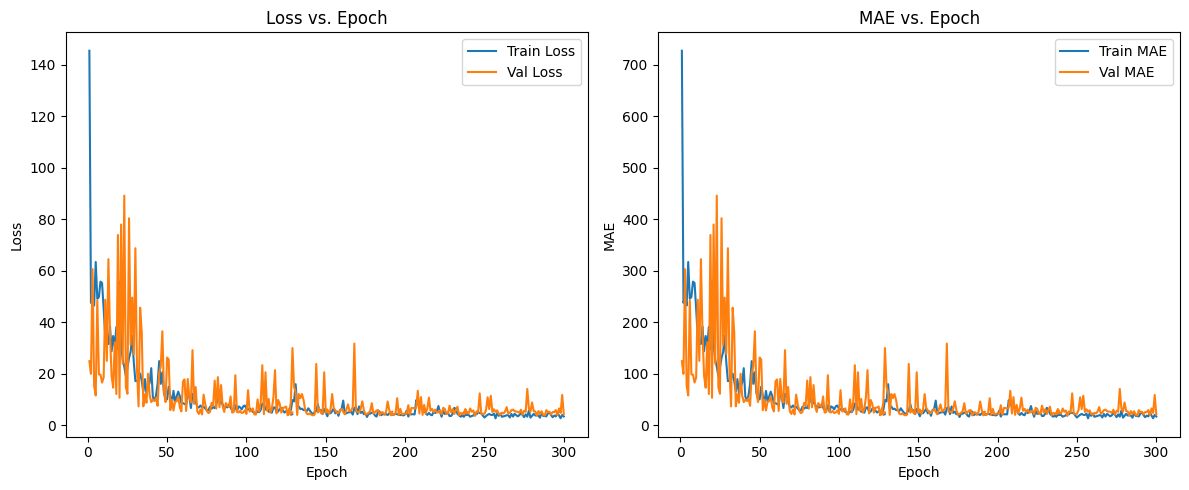

In [ ]:
import re
import matplotlib.pyplot as plt

log_file_path = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_train_log.txt"

epochs = []
train_loss_list = []
train_mae_list = []
val_loss_list = []
val_mae_list = []

with open(log_file_path, "r") as f:
    for line in f:
        match = re.search(r"Epoch \[(\d+)/\d+\], Train Loss: ([\d\.]+), Train MAE: ([\d\.]+).*?\|\| Val Loss: ([\d\.]+), Val MAE: ([\d\.]+)", line)
        if match:
            epochs.append(int(match.group(1)))
            train_loss_list.append(float(match.group(2)))
            train_mae_list.append(float(match.group(3)))
            val_loss_list.append(float(match.group(4)))
            val_mae_list.append(float(match.group(5)))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label="Train Loss")
plt.plot(epochs, val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_mae_list, label="Train MAE")
plt.plot(epochs, val_mae_list, label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("MAE vs. Epoch")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation

In [ ]:
def evaluate_model(model, dataset, batch_size=1, device='cuda', plot=False):
    """
    Evaluate the CSRNet crowd counting model with additional metrics:
    - MAE (Mean Absolute Error)
    - RMSE (Root Mean Squared Error)
    - MSE (Mean Squared Error)
    - MAPE (Mean Absolute Percentage Error)
    - Pearson's Correlation Coefficient (r)
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=custom_collate)

    total_mae = 0.0
    total_mse = 0.0
    total_samples = 0
    all_gt = []
    all_pred = []

    with torch.no_grad():
        for imgs, dmaps, counts in tqdm(loader, desc="Evaluating", total=len(loader)):
            imgs = imgs.to(device)
            dmaps = dmaps.to(device)
            gt_counts = torch.tensor(counts, dtype=torch.float32, device=device).view(-1)

            outputs = model(imgs)
            outputs_up = F.interpolate(outputs, size=dmaps.shape[-2:], mode='bilinear', align_corners=False)
            pred_counts = outputs_up.sum(dim=(2, 3)).view(-1)

            batch_mae = torch.abs(pred_counts - gt_counts).sum().item()
            batch_mse = torch.pow(pred_counts - gt_counts, 2).sum().item()

            total_mae += batch_mae
            total_mse += batch_mse
            total_samples += imgs.size(0)

            all_gt.extend(gt_counts.cpu().numpy())
            all_pred.extend(pred_counts.cpu().numpy())

    all_gt = np.array(all_gt)
    all_pred = np.array(all_pred)

    mae = total_mae / total_samples
    mse = total_mse / total_samples
    rmse = np.sqrt(mse)

    # MAPE
    epsilon = 1e-7
    mape = np.mean(np.abs((all_pred - all_gt) / (all_gt + epsilon))) * 100

    # Pearson's correlation coefficient
    pearson_r = np.corrcoef(all_gt, all_pred)[0, 1]

    print(f"Evaluation Results:")
    print(f"- MAE:  {mae:.2f}")
    print(f"- MSE:  {mse:.2f}")
    print(f"- RMSE: {rmse:.2f}")
    print(f"- MAPE: {mape:.2f}%")
    print(f"- Pearson's r: {pearson_r:.3f}")

    if plot:
        plt.figure(figsize=(12, 5))

        # Scatter plot with regression line
        plt.subplot(1, 2, 1)
        plt.scatter(all_gt, all_pred, alpha=0.5)
        plt.plot([min(all_gt), max(all_gt)], [min(all_gt), max(all_gt)], "r--", label="Ideal")

        # Add regression line
        coeffs = np.polyfit(all_gt, all_pred, 1)
        x_range = np.linspace(min(all_gt), max(all_gt), 100)
        plt.plot(x_range, np.polyval(coeffs, x_range), 'g-', label="Regression Line")

        plt.xlabel("Ground Truth Count")
        plt.ylabel("Predicted Count")
        plt.title(f"Predicted vs. GT (r = {pearson_r:.3f})")
        plt.legend()

        # Error histogram
        plt.subplot(1, 2, 2)
        errors = all_pred - all_gt
        plt.hist(errors, bins=30, alpha=0.7, color='blue')
        plt.xlabel("Prediction Error (Predicted - GT)")
        plt.ylabel("Frequency")
        plt.title("Error Distribution")

        plt.tight_layout()
        plt.show()

    return mae, rmse, mse, mape, pearson_r

In [ ]:
test_dataset = Subset(test_dataset_all, list(range(val_subset_size, len(test_dataset_all))))
print("Test Dataset:", len(test_dataset))

Test Dataset: 158


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-4-10fdb1c5c0c1>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_counts = torch.tensor(counts, dtype=torch.float32, device=device).view(-1)
Evaluating: 100%|██████████| 40/40 [13:03<00:00, 19.59s/it]


Evaluation Results:
- MAE:  22.47
- MSE:  1601.83
- RMSE: 40.02
- MAPE: 22.27%
- Pearson's r: 0.921


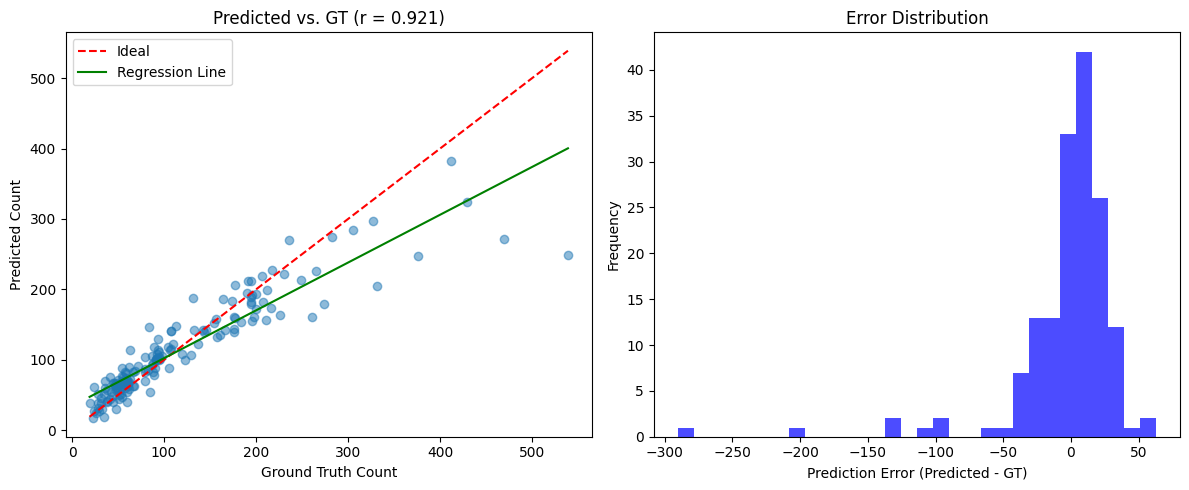

In [ ]:
model_path = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_175.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CSRNet()
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)

mae, rmse, mse, mape, pearson_r = evaluate_model(model, test_dataset, batch_size=4, device=device, plot=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 138MB/s]
Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]<ipython-input-4-10fdb1c5c0c1>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Evaluation Results:
- MAE:  21.55
- MSE:  1356.10
- RMSE: 36.83
- MAPE: 22.97%
- Pearson's r: 0.933


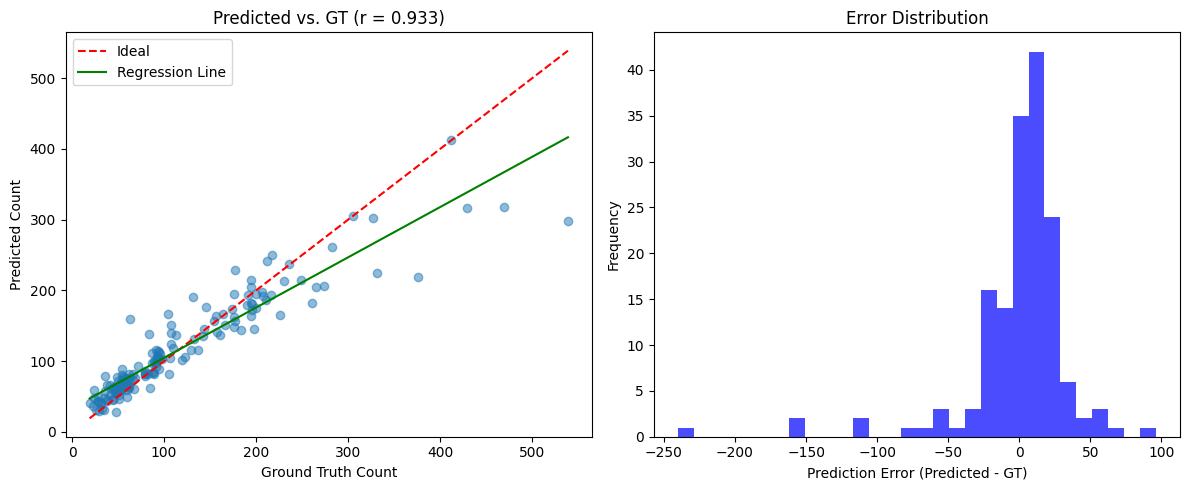

In [ ]:
model_path = r"/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_300.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CSRNet()
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)

mae, rmse, mse, mape, pearson_r = evaluate_model(model, test_dataset, batch_size=4, device=device, plot=True)

# Performance Analysis

In [ ]:
def performance_analysis(model, image_path, device='cuda', mat_dir=None, target_size=(640, 480)):
    """
    Runs inference on a single image.
    """
    # Read and resize the image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")

    if target_size is not None:
        img_bgr = cv2.resize(img_bgr, target_size, interpolation=cv2.INTER_LINEAR)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W, _ = img_rgb.shape

    # Load ground-truth .mat to get GT count
    gt_count = None
    if mat_dir is not None:
        image_basename = os.path.splitext(os.path.basename(image_path))[0]
        mat_filename = "GT_" + image_basename + ".mat"
        mat_path = os.path.join(mat_dir, mat_filename)

        if os.path.isfile(mat_path):
            mat_data = sio.loadmat(mat_path)
            if "image_info" in mat_data:
                points = mat_data["image_info"][0,0]["location"][0,0]
                gt_count = points.shape[0]
        else:
            print(f"Warning: .mat file not found at {mat_path}. GT count not available.")

    # Convert image to tensor and run inference
    img_norm = img_rgb.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_norm.transpose(2, 0, 1)).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        output = model(img_tensor)
        outputs_up = F.interpolate(output, size=(H, W), mode='bilinear', align_corners=False)
        pred_density = outputs_up.squeeze().cpu().numpy()
        pred_count = pred_density.sum()

    # Visualization
    plt.figure(figsize=(12, 6))

    # Left: Input image
    title_left = "Input Image"
    if gt_count is not None:
        title_left += f"\n(GT count: {gt_count})"

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title(title_left)
    plt.axis("off")

    # Right: Predicted density map with count overlay
    plt.subplot(1, 2, 2)
    plt.imshow(pred_density, cmap='hot')
    plt.title(f"Predicted Density Map\nCount: {pred_count:.2f}")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

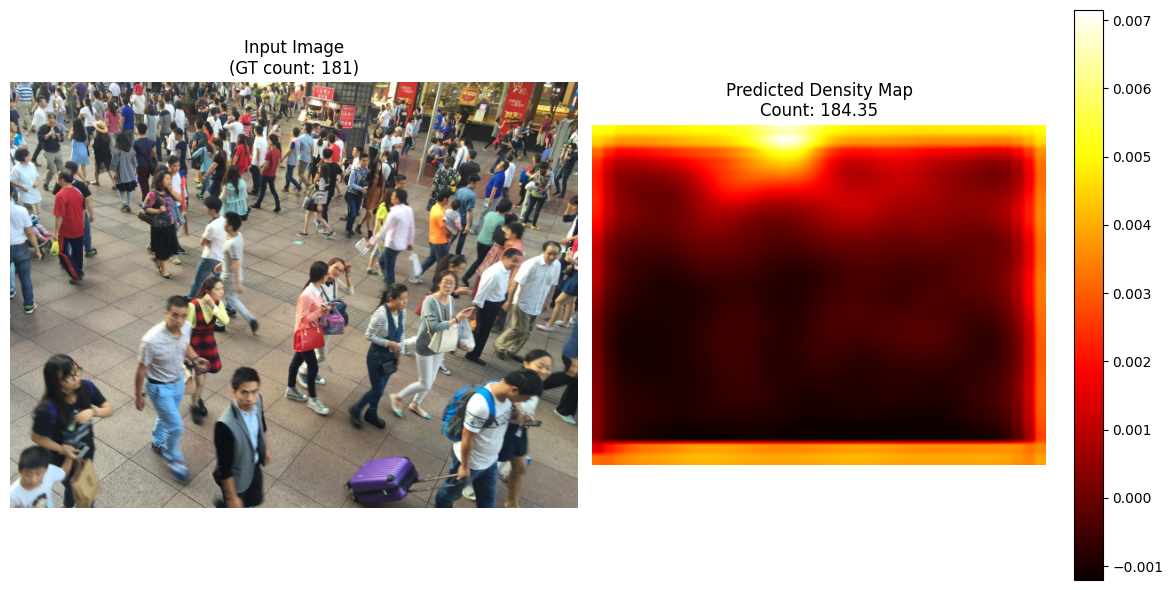

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_175.pth"
checkpoint = torch.load(model_path, map_location=device)
model = CSRNet()
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)

image_path = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/images/IMG_10.jpg"
mat_dir = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/ground_truth"

performance_analysis(model, image_path, device=device, mat_dir=mat_dir, target_size=(640, 480))

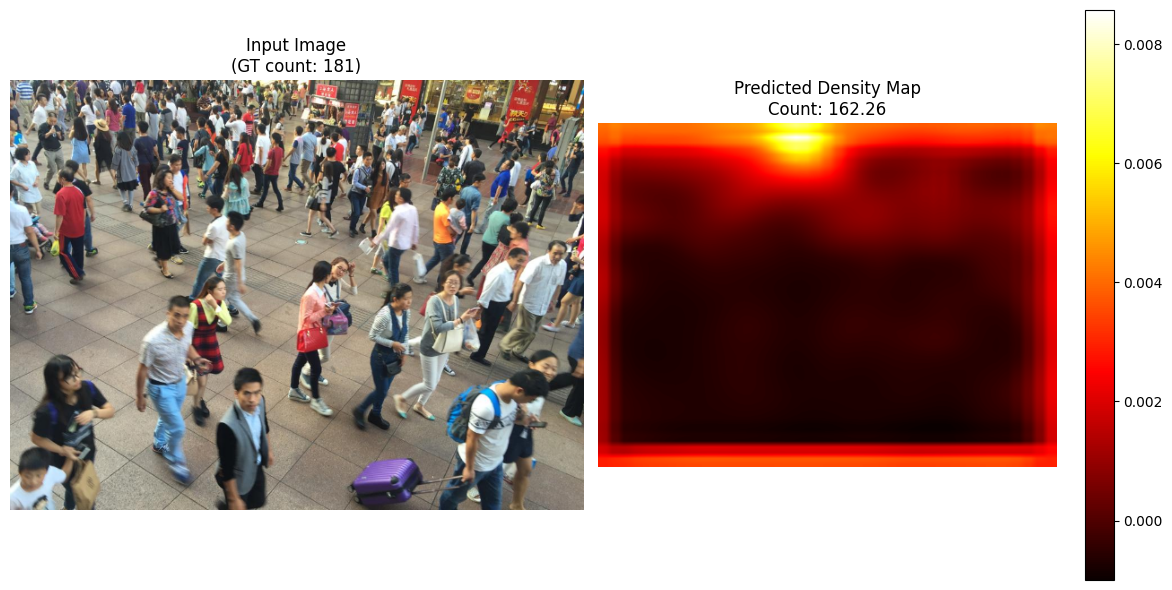

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_300.pth"
checkpoint = torch.load(model_path, map_location=device)
model = CSRNet()
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)

image_path = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/images/IMG_10.jpg"
mat_dir = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/ground_truth"

performance_analysis(model, image_path, device=device, mat_dir=mat_dir, target_size=(640, 480))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


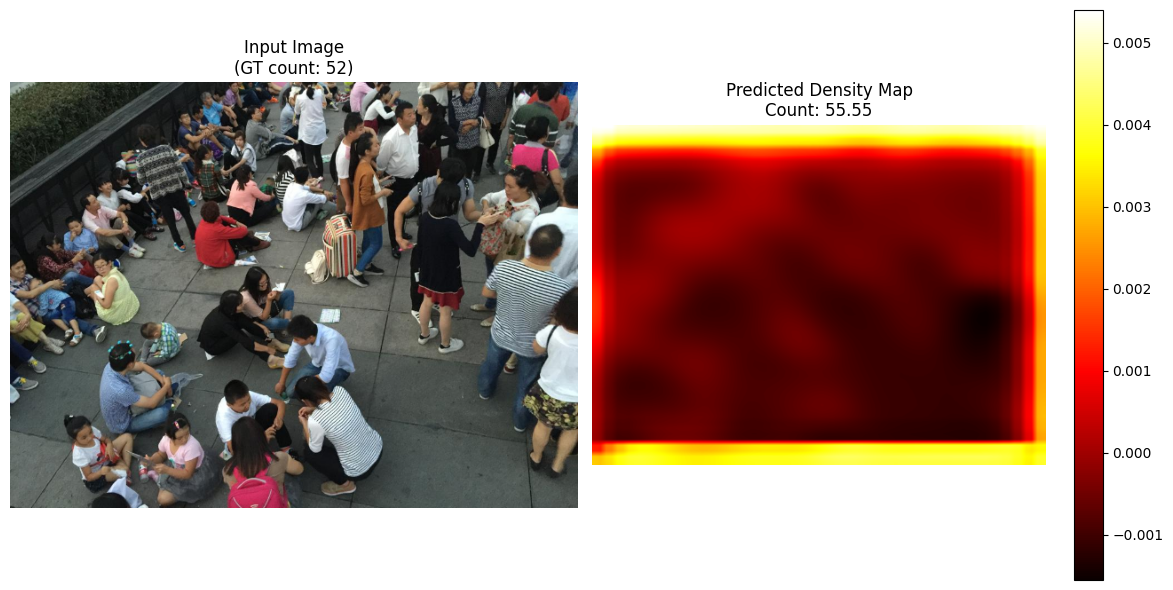

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_175.pth"
checkpoint = torch.load(model_path, map_location=device)
model = CSRNet()
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)

image_path = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/images/IMG_2.jpg"
mat_dir = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/ground_truth"

performance_analysis(model, image_path, device=device, mat_dir=mat_dir, target_size=(640, 480))

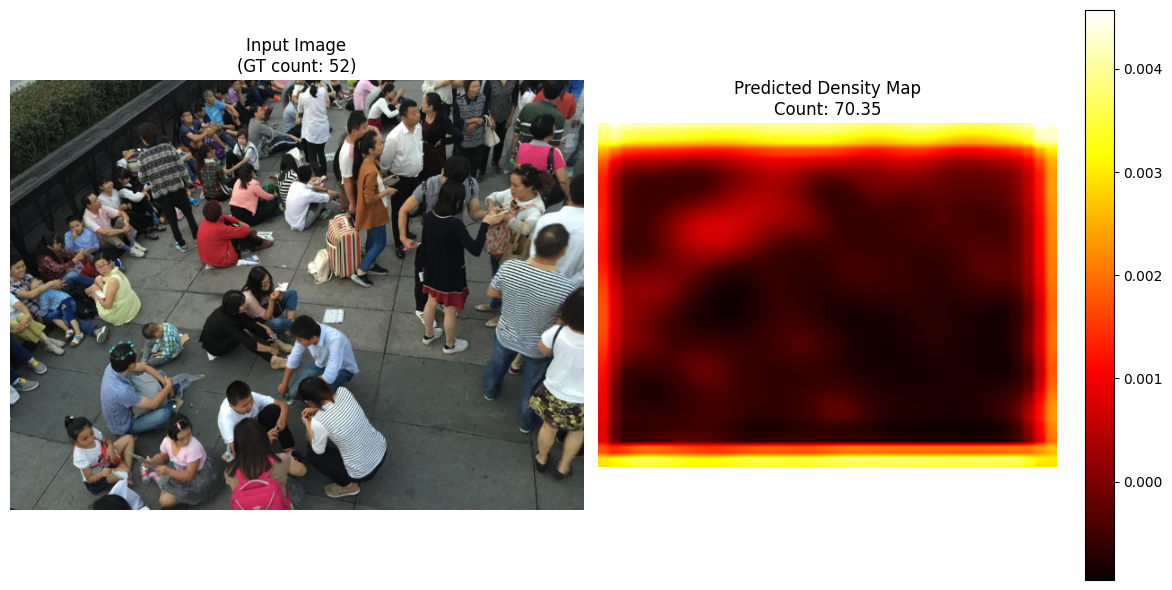

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_300.pth"
checkpoint = torch.load(model_path, map_location=device)
model = CSRNet()

model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)

image_path = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/images/IMG_2.jpg"
mat_dir = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/test_data/ground_truth"

performance_analysis(model, image_path, device=device, mat_dir=mat_dir, target_size=(640, 480))

# Prototype

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import models

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
def make_backend(cfg, in_channels, dilation_rate=2):
    layers = []
    for v in cfg:
        layers.append(nn.Conv2d(in_channels, v, kernel_size=3, padding=dilation_rate, dilation=dilation_rate))
        layers.append(nn.ReLU(inplace=True))
        in_channels = v
    return nn.Sequential(*layers)


class CSRNet(nn.Module):
    def __init__(self, load_weights=True):
        super(CSRNet, self).__init__()
        self.frontend = nn.Sequential(*list(models.vgg16(pretrained=True).features)[:23])
        self.backend_cfg = [512, 512, 512, 256, 128, 64]
        self.backend = make_backend(self.backend_cfg, in_channels=512, dilation_rate=2)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


def inference(model, image_path, device='cuda', target_size=(640, 480)):
    """
    Runs inference on a single image.
    """
    # Read and resize the image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not load image: {image_path}")

    if target_size is not None:
        img_bgr = cv2.resize(img_bgr, target_size, interpolation=cv2.INTER_LINEAR)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W, _ = img_rgb.shape

    # Convert image to tensor and run inference
    img_norm = img_rgb.astype(np.float32) / 255.0
    img_tensor = torch.from_numpy(img_norm.transpose(2, 0, 1)).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        output = model(img_tensor)
        outputs_up = F.interpolate(output, size=(H, W), mode='bilinear', align_corners=False)
        pred_density = outputs_up.squeeze().cpu().numpy()
        pred_count = pred_density.sum()

    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_density, cmap='hot')
    plt.title(f"Predicted Density Map\nCount: {pred_count:.2f}")
    plt.colorbar()
    plt.axis("off")

    plt.tight_layout()
    plt.show()

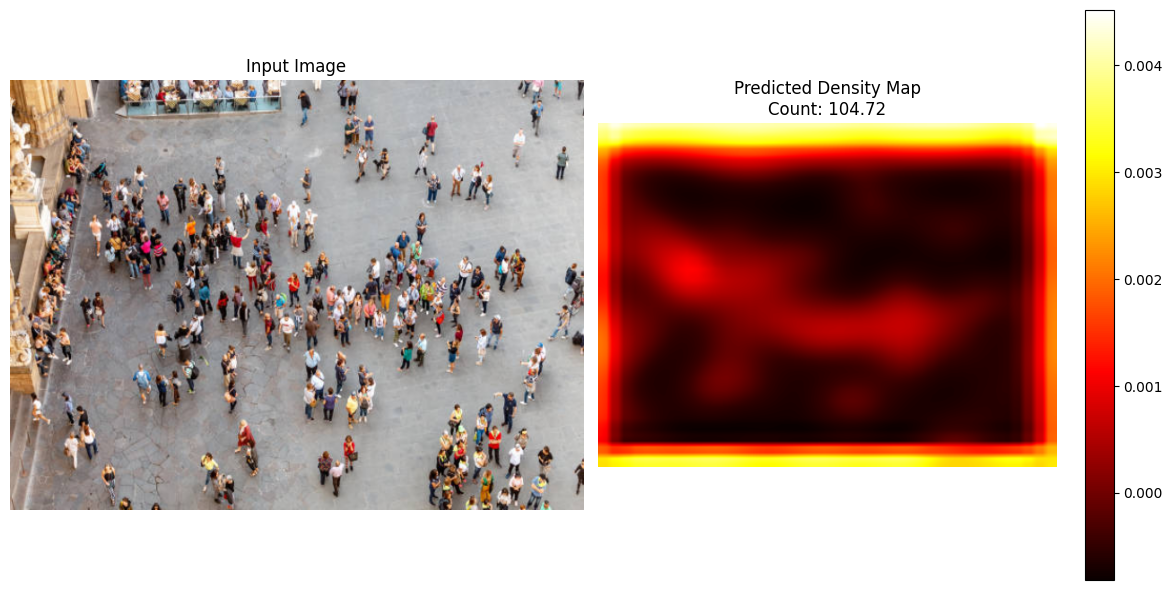

In [4]:
model = CSRNet()
checkpoint = torch.load("/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/CSRNET_model_epoch_300.pth", map_location='cpu')
model.load_state_dict(checkpoint["model_state_dict"])
model.to('cpu')

image_path = "/content/drive/MyDrive/MV_CW/data/ShanghaiTech/part_B_final/crowd.jpg"
inference(model, image_path=image_path, device='cpu', target_size=(640,480))